<a href="https://colab.research.google.com/github/sep-corbett/GLOBEM-preprocessing/blob/main/GLOBEM_Preprocessing_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialising Datsets

In [25]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

!pip install feature-engine


import pandas as pd
from sklearn.datasets import make_classification

# pass relevant files here
target_dir = "/content/drive/MyDrive/FYP Data/"
features = pd.read_csv(f"{target_dir}rapids.csv", index_col=0)
ema = pd.read_csv(f"{target_dir}ema.csv", index_col=0)
ema = ema[['pid', 'date', 'phq4_depression_EMA']].dropna()

# set personality data filename for later
personality_filename = f"{target_dir}pre.csv"

# assign constants for datetime splits, determined by analysing the missingness patterns
START_DATE = pd.to_datetime('2019-03-31')
END_DATE = pd.to_datetime('2019-06-02')

# relevant if splitting by time rather than patient, set to None if splitting by PID
CUTOFF_DATE=pd.to_datetime('2019-05-19')

# assign relevant datetimes
features['date'] = pd.to_datetime(features['date'], format='%Y-%m-%d')
ema['date'] = pd.to_datetime(ema['date'], format='%Y-%m-%d')

# remove any empty columns
features = features.dropna(how='all', axis=1)

# remove columns containing _dis, _norm, or wifi
features = features.loc[:, ~features.columns.str.contains('_dis|_norm|wifi')]
features

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


pid       date  \
0      INS-W_300 2019-03-21   
1      INS-W_300 2019-03-22   
2      INS-W_300 2019-03-23   
3      INS-W_300 2019-03-24   
4      INS-W_300 2019-03-25   
...          ...        ...   
21141  INS-W_572 2019-06-21   
21142  INS-W_572 2019-06-22   
21143  INS-W_572 2019-06-23   
21144  INS-W_572 2019-06-24   
21145  INS-W_572 2019-06-25   

       f_slp:fitbit_sleep_summary_rapids_sumdurationafterwakeupmain:14dhist  \
0                                                    NaN                      
1                                                    NaN                      
2                                                    NaN                      
3                                                    NaN                      
4                                                    NaN                      
...                                                  ...                      
21141                                                NaN                      
21142                                                NaN                      
21143                                                NaN                      
21144                                                NaN                      
21145                                                NaN                      

       f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:14dhist  \
0                                                    NaN                 
1                                                    NaN                 
2                                                    NaN                 
3                                                    NaN                 
4                                                    NaN                 
...                                                  ...                 
21141                                                NaN                 
21142                                                NaN                 
21143                                                NaN                 
21144                                                NaN                 
21145                                                NaN                 

       f_slp:fitbit_sleep_summary_rapids_sumdurationawakemain:14dhist  \
0                                                    NaN                
1                                                    NaN                
2                                                    NaN                
3                                                    NaN                
4                                                    NaN                
...                                                  ...                
21141                                                NaN                
21142                                                NaN                
21143                                                NaN                
21144                                                NaN                
21145                                                NaN                

       f_slp:fitbit_sleep_summary_rapids_sumdurationtofallasleepmain:14dhist  \
0                                                    NaN                       
1                                                    NaN                       
2                                                    NaN                       
3                                                    NaN                       
4                                                    NaN                       
...                                                  ...                       
21141                                                NaN                       
21142                                                NaN                       
21143                                                NaN                       
21144                                                NaN                       
21145                                        

### Optional Analysis: Determine Start and End Dates
Use this process to determine what portion of the data you are comfortable removing. For our process, we only look at data after the fitbit has started tracking data, and we have target depression labels in EMA.

This essentially just selects dates between when the weekly depression score tracking began and ended.


In [26]:
def get_date_ranges(df, group_name, keywords):
    """
    Finds the earliest and latest dates with non-null values for specified keywords, in the 'allday' category
    """
    relevant_cols = [col for col in df.columns if any(keyword in col for keyword in keywords) and 'allday' in col]
    if not relevant_cols:
        return None, None  # Return None if no relevant columns are found

    # Drop rows where all relevant columns are null for each group
    df_filtered = df.dropna(subset=relevant_cols, how='all')

    earliest_date = df_filtered['date'].min().date()
    latest_date = df_filtered['date'].max().date()
    return earliest_date, latest_date



fitbit_earliest, fitbit_latest = get_date_ranges(features, 'fitbit', ['slp', 'steps'])
phone_earliest, phone_latest = get_date_ranges(features, 'phone', ['call', 'screen', 'bluetooth'])

# Find date ranges for ema data
ema_earliest = ema['date'].min().date()
ema_latest = ema['date'].max().date()

print(f"Fitbit:\tEarliest - {fitbit_earliest},\tLatest - {fitbit_latest}")
print(f"Phone:\tEarliest - {phone_earliest},\tLatest - {phone_latest}")
print(f"EMA:\tEarliest - {ema_earliest},\tLatest - {ema_latest}")

print(f'\nRecommended range: \t\t{ema_earliest} to {ema_latest}')
print(f'Currently selected range: \t{START_DATE.strftime("%Y-%m-%d")} to {END_DATE.strftime("%Y-%m-%d")}')

Fitbit:	Earliest - 2019-03-29,	Latest - 2019-06-03
Phone:	Earliest - 2019-03-21,	Latest - 2019-06-12
EMA:	Earliest - 2019-03-31,	Latest - 2019-06-02

Recommended range: 		2019-03-31 to 2019-06-02
Currently selected range: 	2019-03-31 to 2019-06-02


In [27]:
# assign constants for datetime splits, determined by analysing the missingness patterns
START_DATE = pd.to_datetime(ema_earliest)
END_DATE = pd.to_datetime(ema_latest)

# select date 75% between start and end date
CUTOFF_DATE = START_DATE + (END_DATE - START_DATE) * 0.75
CUTOFF_DATE = pd.to_datetime(CUTOFF_DATE.date())
print(CUTOFF_DATE)

2019-05-17 00:00:00


In [28]:
CUTOFF_DATE=pd.to_datetime('2019-05-19')

## Graphs and Displays

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def categorise_features(df, time_categories = ['weekday', 'weekend', '7dhist', '14dhist', 'allday', 'morning', 'afternoon', 'evening', 'night'], type_categories = ['screen', 'steps', 'slp', 'locations', 'bluetooth', 'call']):

    def get_category_totals(df, categories):
        category_totals = {}
        for category in categories:
            category_totals[category] = [col_name for col_name in df.columns if category in col_name]
        return category_totals

    # Get feature counts for the first set of categories
    time_categories_totals = get_category_totals(df, time_categories)
    labels1 = list(time_categories_totals.keys())
    sizes1 = [len(values) for values in time_categories_totals.values()]

    # If a second category list is given, process it
    if type_categories:
        type_categories_totals = get_category_totals(df, type_categories)
        labels2 = list(type_categories_totals.keys())
        sizes2 = [len(values) for values in type_categories_totals.values()]

        # Create side-by-side pie charts
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Reversed Viridis for the first pie chart
        cmap1 = cm.get_cmap('viridis') #<-----Reversed
        colors1 = cmap1(np.linspace(0, 1, len(labels1)))
        wedges1, texts1, autotexts1 = axes[0].pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=90, colors=colors1)
        axes[0].set_title('Time Based Proportions')
        axes[0].axis('equal')

        for i, autotext in enumerate(autotexts1):
            r, g, b, _ = colors1[i]
            luminance = (0.299 * r + 0.587 * g + 0.114 * b)
            if luminance < 0.5:
                autotext.set_color('white')

        # Reversed Viridis for the second pie chart
        cmap2 = cm.get_cmap('viridis_r') #<-----Reversed
        colors2 = cmap2(np.linspace(0, 1, len(labels2)))
        wedges2, texts2, autotexts2 = axes[1].pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=90, colors=colors2)
        axes[1].set_title('Feature Type Based Proportions')
        axes[1].axis('equal')

        for i, autotext in enumerate(autotexts2):
            r, g, b, _ = colors2[i]
            luminance = (0.299 * r + 0.587 * g + 0.114 * b)
            if luminance < 0.5:
                autotext.set_color('white')

        plt.tight_layout()
        plt.show()

        return time_categories_totals, type_categories

    # If only one category list is given, show a single pie chart
    plt.figure(figsize=(5, 5))

    # Reversed Viridis for the single pie chart
    cmap3 = cm.get_cmap('viridis_r') #<-----Reversed
    colors3 = cmap3(np.linspace(0, 1, len(labels1)))
    wedges3, texts3, autotexts3 = plt.pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=90, colors=colors3)
    plt.title('Score per Category')
    plt.axis('equal')

    for i, autotext in enumerate(autotexts3):
        r, g, b, _ = colors3[i]
        luminance = (0.299 * r + 0.587 * g + 0.114 * b)
        if luminance < 0.5:
            autotext.set_color('white')

    plt.show()

    return time_categories_totals

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

def categorise_feature_importance(df, time_categories = ['BFI10', 'weekday', 'weekend', '7dhist', '14dhist', 'allday', 'morning', 'afternoon', 'evening', 'night'], type_categories = ['BFI10', 'screen', 'steps', 'slp', 'locations', 'bluetooth', 'call']):


    def get_category_totals(df, categories):
        category_totals = {}
        for category in categories:
            category_totals[category] = 0
            for col in df.columns:
                if category in col:
                    category_totals[category] += df[col][0]
        return category_totals

    df = df.set_index('feature')
    df = df.transpose()

    # Process time categories
    time_categories_totals = get_category_totals(df, time_categories)
    labels1 = list(time_categories_totals.keys())
    sizes1 = list(time_categories_totals.values())

    # Process type categories
    if type_categories:
        type_categories_totals = get_category_totals(df, type_categories)
        labels2 = list(type_categories_totals.keys())
        sizes2 = list(type_categories_totals.values())

        # Create side-by-side pie charts
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Reversed Viridis for the first pie chart (time)
        cmap1 = cm.get_cmap('viridis_r')
        colors1 = cmap1(np.linspace(0, 1, len(labels1)))
        wedges1, texts1, autotexts1 = axes[0].pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=90, colors=colors1)
        axes[0].set_title('Feature Importance (Time)')
        axes[0].axis('equal')

        for i, autotext in enumerate(autotexts1):
            r, g, b, _ = colors1[i]
            luminance = (0.299 * r + 0.587 * g + 0.114 * b)
            if luminance < 0.5:
                autotext.set_color('white')

        # Reversed Viridis for the second pie chart (type)
        cmap2 = cm.get_cmap('viridis_r')
        colors2 = cmap2(np.linspace(0, 1, len(labels2)))
        wedges2, texts2, autotexts2 = axes[1].pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=90, colors=colors2)
        axes[1].set_title('Feature Importance (Type)')
        axes[1].axis('equal')

        for i, autotext in enumerate(autotexts2):
            r, g, b, _ = colors2[i]
            luminance = (0.299 * r + 0.587 * g + 0.114 * b)
            if luminance < 0.5:
                autotext.set_color('white')

        plt.tight_layout()
        plt.show()

        display_feature_table_counts(df, max_val=df.shape[1]//5)

        return time_categories_totals, type_categories

    # If only time categories are given, show a single pie chart
    plt.figure(figsize=(5, 5))

    # Reversed Viridis for the single pie chart
    cmap3 = cm.get_cmap('viridis_r')
    colors3 = cmap3(np.linspace(0, 1, len(labels1)))
    wedges3, texts3, autotexts3 = plt.pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=90, colors=colors3)
    plt.title('Feature Importance (Time)')
    plt.axis('equal')

    for i, autotext in enumerate(autotexts3):
        r, g, b, _ = colors3[i]
        luminance = (0.299 * r + 0.587 * g + 0.114 * b)
        if luminance < 0.5:
            autotext.set_color('white')

    plt.show()
    display_feature_table_counts(df, max_val=df.shape[1]//5)

    return time_categories_totals

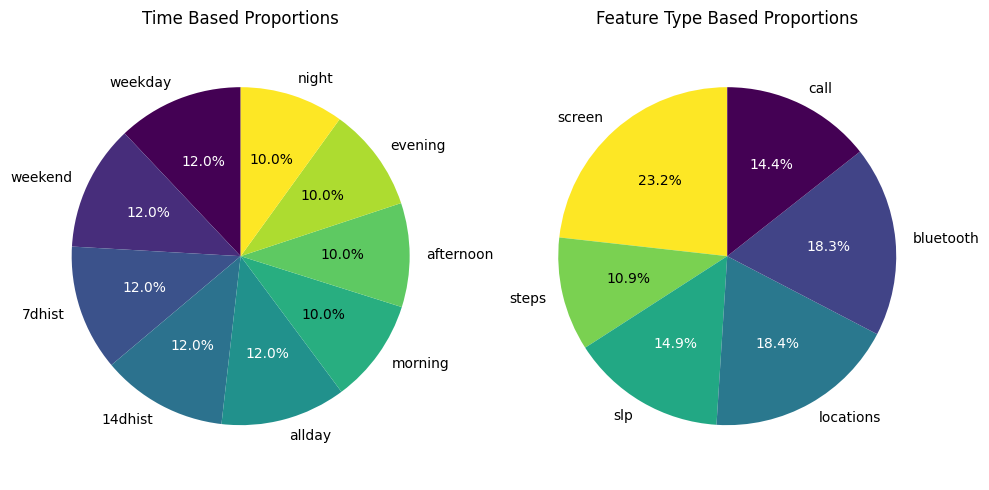

In [30]:
_ = categorise_features(features, ['weekday', 'weekend', '7dhist', '14dhist', 'allday', 'morning', 'afternoon', 'evening', 'night'], ['screen', 'steps', 'slp', 'locations', 'bluetooth', 'call'])

In [31]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

def plot_missingness_over_time(df, keywords=None, by_time=True, by_locmap=False,
                                cutoff_date=CUTOFF_DATE, plotwidth=12,
                                title='Missing Value Proportions Over Time'):

    # Choose keyword list
    if keywords is None:
        if by_locmap:
            keywords = ['locmap_exercise', 'locmap_living', 'locmap_study', 'locmap_greens', 'locmap_home']
        elif by_time:
            keywords = ['morning', 'afternoon', 'evening', 'night', 'allday', '14dhist', '7dhist', 'weekend', 'weekday']
        else:
            keywords = ['screen', 'steps', 'slp', 'locations', 'bluetooth', 'call']

    plt.figure(figsize=(plotwidth, 8))

    # Format dates
    df['date'] = pd.to_datetime(df['date'])
    unique_dates = sorted(df['date'].unique())

    # Highlight weekends
    if not by_time:
        for date in unique_dates:
            if date.weekday() in [5, 6]:  # Saturday or Sunday
                plt.axvspan(date, date + pd.Timedelta(days=1), color='grey', alpha=0.2)

    # Set up color palette
    cmap = cm.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(keywords)))

    # Collect custom legend handles
    legend_handles = []

    for i, keyword in enumerate(keywords):
        feature_cols = [col for col in df.columns if keyword in col and col != 'date']

        if not feature_cols:
            print(f"No columns found with keyword '{keyword}'. Skipping.")
            continue

        missingness_by_date = []
        for date in unique_dates:
            subset = df[df['date'] == date]
            if len(subset) > 0 and len(feature_cols) > 0:
                missing = subset[feature_cols].isnull().sum().sum()
                total = len(subset) * len(feature_cols)
                missingness = (missing / total) * 100
            else:
                missingness = 0
            missingness_by_date.append((date, missingness))

        if missingness_by_date:
            dates, missing_percentages = zip(*missingness_by_date)
            plt.plot(dates, missing_percentages, color=colors[i], lw=2)
            legend_label = keyword.replace('locmap_', '') if by_locmap else keyword
            handle = Line2D([0], [0], color=colors[i], lw=2, label=legend_label)
            legend_handles.append(handle)

    # Reference lines
    if min(df['date']) < START_DATE:
        plt.axvline(START_DATE, color='black', linestyle='--', linewidth=1, label='Start Date')
    if max(df['date']) > END_DATE:
        plt.axvline(END_DATE, color='black', linestyle='--', linewidth=1, label='End Date')
    if cutoff_date:
        plt.axvline(cutoff_date, color='firebrick', linestyle='--', linewidth=1, label='Train/Test Split')

    # Final formatting
    plt.xlabel('Date', fontsize=20)
    plt.ylabel('% Null Values', fontsize=20)
    plt.title(title, fontsize=24)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(handles=legend_handles, fontsize=16)
    plt.tight_layout()
    plt.show()

    return df


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def display_feature_table(df, count=True, missingness=True, max_val=100):
    """Displays a heatmap of feature counts or missingness categorized by time and type."""
    time_categories = ['morning', 'afternoon', 'evening', 'night', 'allday', 'weekend','weekday', '7dhist', '14dhist']
    type_categories = ['location', 'bluetooth', 'steps', 'slp', 'screen', 'call']

    # Initialize data containers
    counts = []
    missingness_data = []

    for cat1 in time_categories:
        for cat2 in type_categories:
            count_value = sum(1 for col in df.columns if cat1 in col and cat2 in col)
            counts.append([cat1, cat2, count_value])

            total_features = sum(1 for col in df.columns if cat1 in col and cat2 in col)
            missing_value = sum(df[col].isnull().sum() for col in df.columns if cat1 in col and cat2 in col)

            missingness_percentage = (missing_value / (len(df) * total_features)) * 100 if total_features > 0 else 0
            missingness_data.append([cat1, cat2, missingness_percentage])

    count_df = pd.DataFrame(counts, columns=['Time Categories', 'Type Categories', 'Count'])
    missingness_df = pd.DataFrame(missingness_data, columns=['Time Categories', 'Type Categories', 'Missingness (%)'])

    count_df = count_df.sort_values(by='Count', ascending=False)
    missingness_df = missingness_df.sort_values(by='Missingness (%)', ascending=False)

    count_pivot = count_df.pivot(index="Time Categories", columns="Type Categories", values="Count")
    missingness_pivot = missingness_df.pivot(index="Time Categories", columns="Type Categories", values="Missingness (%)")

    count_pivot = count_pivot.reindex(index=time_categories, columns=type_categories, fill_value=0)
    missingness_pivot = missingness_pivot.reindex(index=time_categories, columns=type_categories, fill_value=0)

    # Determine number of plots needed
    num_plots = count + missingness  # True evaluates to 1, False to 0
    fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 10))

    if num_plots == 1:
        axes = [axes]  # Ensure axes is iterable

    plot_idx = 0
    annot_font_size = 13
    if count:
        sns.heatmap(count_pivot, annot=True, cmap="viridis", fmt="d", vmin=0, vmax=max_val, ax=axes[plot_idx], annot_kws={"size": annot_font_size},)
        axes[plot_idx].set_title("Feature Counts by Category")
        axes[plot_idx].set_xlabel("Type Categories")
        axes[plot_idx].set_ylabel("Time Categories")
        plot_idx += 1

    if missingness:
        sns.heatmap(missingness_pivot, annot=True, cmap="viridis_r", fmt=".2f", vmin=0, vmax=max_val, ax=axes[plot_idx], annot_kws={"size": annot_font_size},)
        axes[plot_idx].set_title("Missingness (%) by Category")
        axes[plot_idx].set_xlabel("Type Categories")
        axes[plot_idx].set_ylabel("Time Categories")

    plt.tight_layout()
    plt.show()

    return df

def display_feature_table_counts(df, max_val=100):
    _ = display_feature_table(df, count=True, missingness=False, max_val=max_val)
    return df

def display_feature_table_missingness(df):
    _ = display_feature_table(df, count=False, missingness=True)
    return df

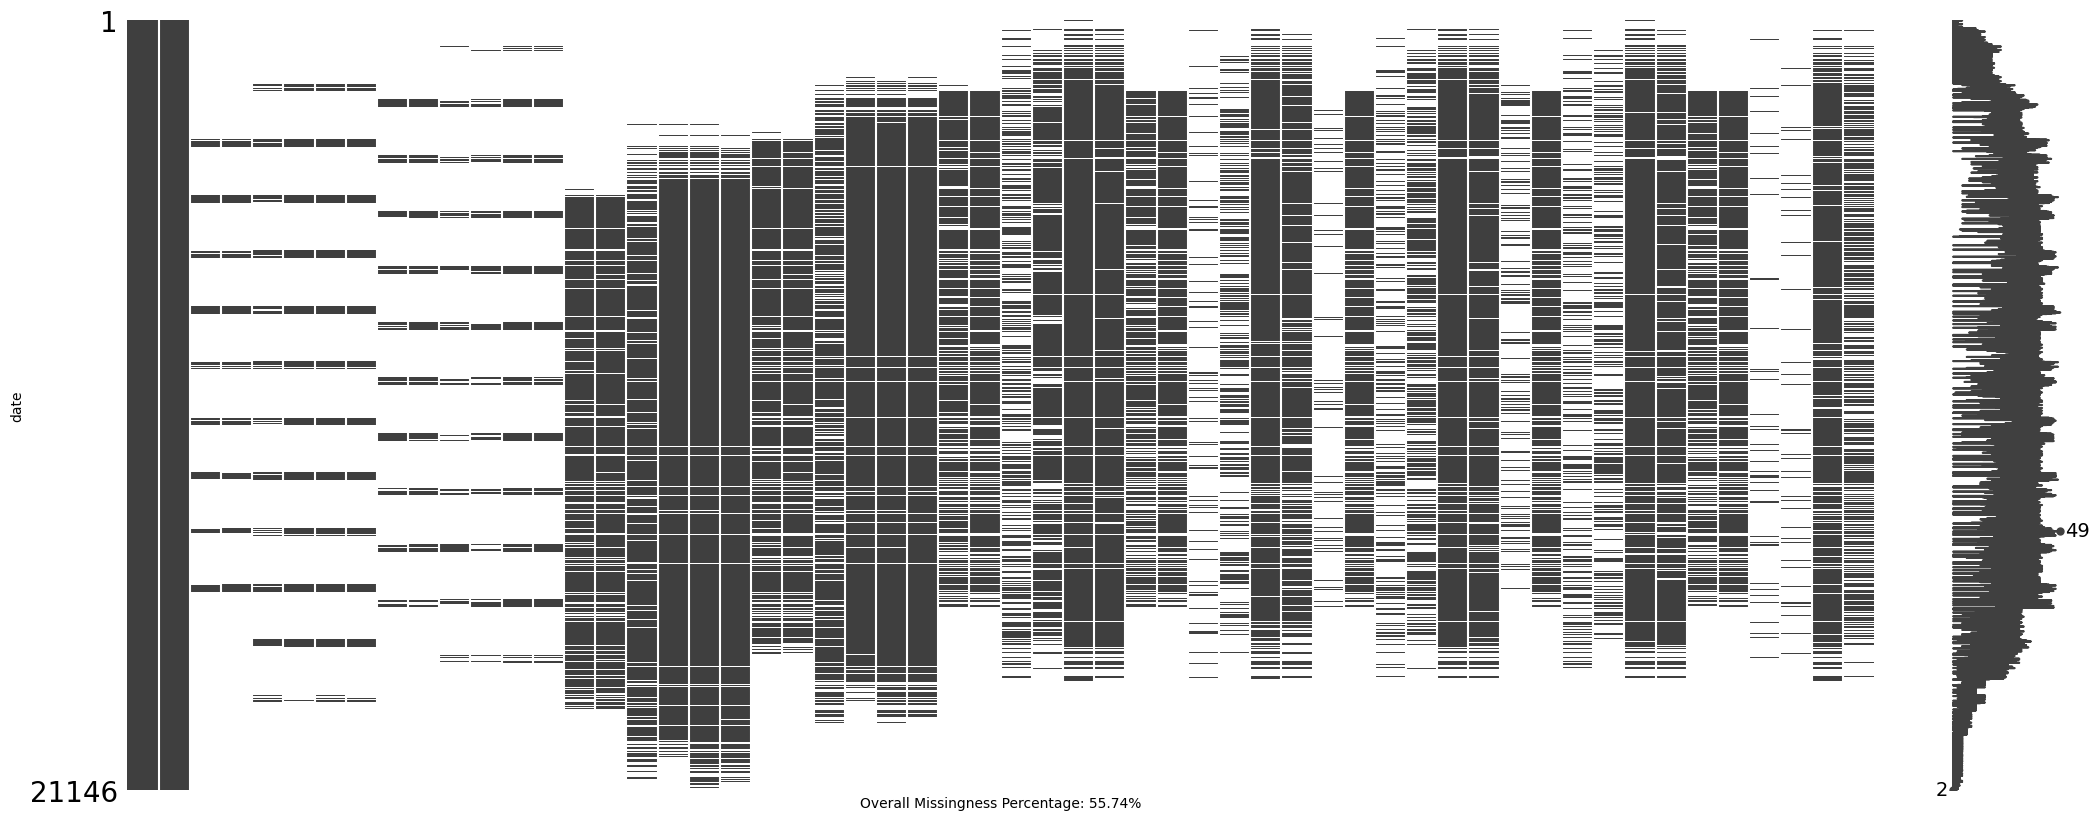

In [33]:
import missingno as msno

def group_msno_plot(df, title=None, sort_by='date', add_locmap=False):
  time_categories = ['weekday', 'weekend', '14dhist', '7dhist', 'allday', 'morning', 'afternoon', 'evening', 'night']
  type_categories = ['slp', 'steps', 'call',  'screen', 'locations', 'bluetooth']
  if add_locmap:
    type_categories.append('locmap')
  df = df.sort_values(by=sort_by)

  grouped_columns = {}
  for t_time in time_categories:
      for t_type in type_categories:
          key = f'{t_time}_{t_type}'
          matching_cols = [col for col in df.columns if t_time in col.lower() and t_type in col.lower()]
          if matching_cols:
              grouped_columns[key] = matching_cols

  # Create binary missingness dataframe
  binary_missing_df = df[['date', 'pid']]

  for group_name, cols in grouped_columns.items():
      pct_missing = df[cols].isna().sum(axis=1) / len(cols)
      binary_missing_df[group_name] = np.where(pct_missing < 0.5, 1, np.nan)

  msno.matrix(binary_missing_df)
  if title:
    plt.title(title)
  plt.ylabel(sort_by)
  length = df.shape[1]
  if 'phq4_depression_EMA' in df.columns:
    length -= 1
  plt.xlabel(f'Overall Missingness Percentage: {df.isna().sum().sum() / (df.shape[0] * length) * 100:.2f}%')
  plt.show()

group_msno_plot(features)

In [34]:
def graphs(df):
  print('Shape:', df.shape)
  _ = categorise_features(df)
  _ = plot_missingness_over_time(df, by_time=True)
  _ = plot_missingness_over_time(df, by_time=False)
  _ = display_feature_table(df)
  _ = group_msno_plot(df)
  return df

Shape: (21146, 1629)


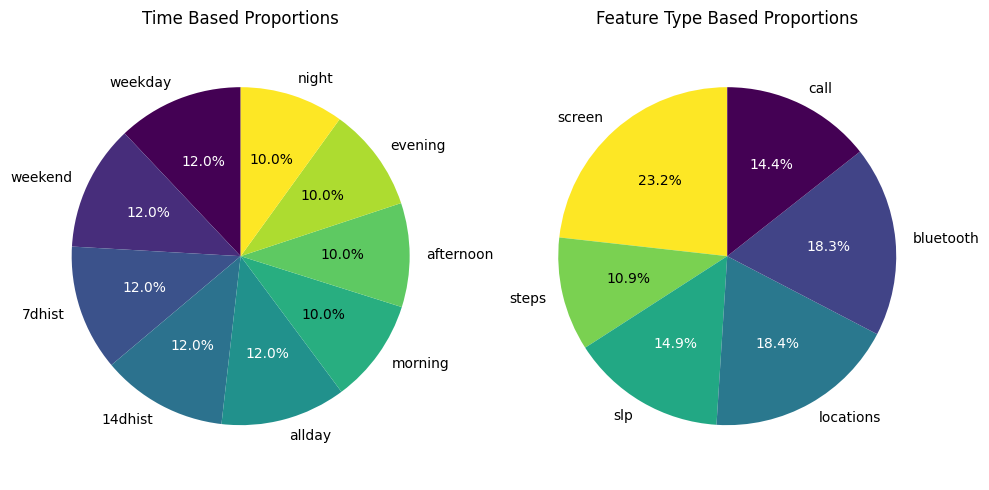

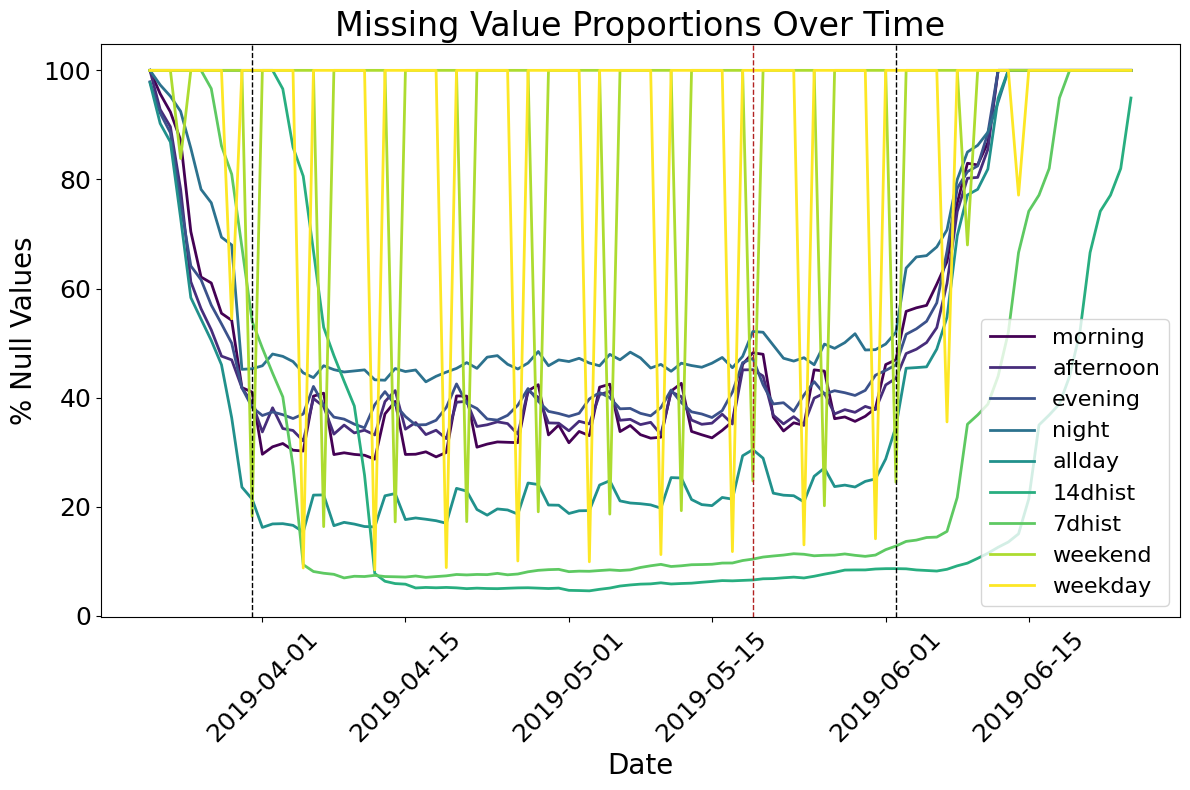

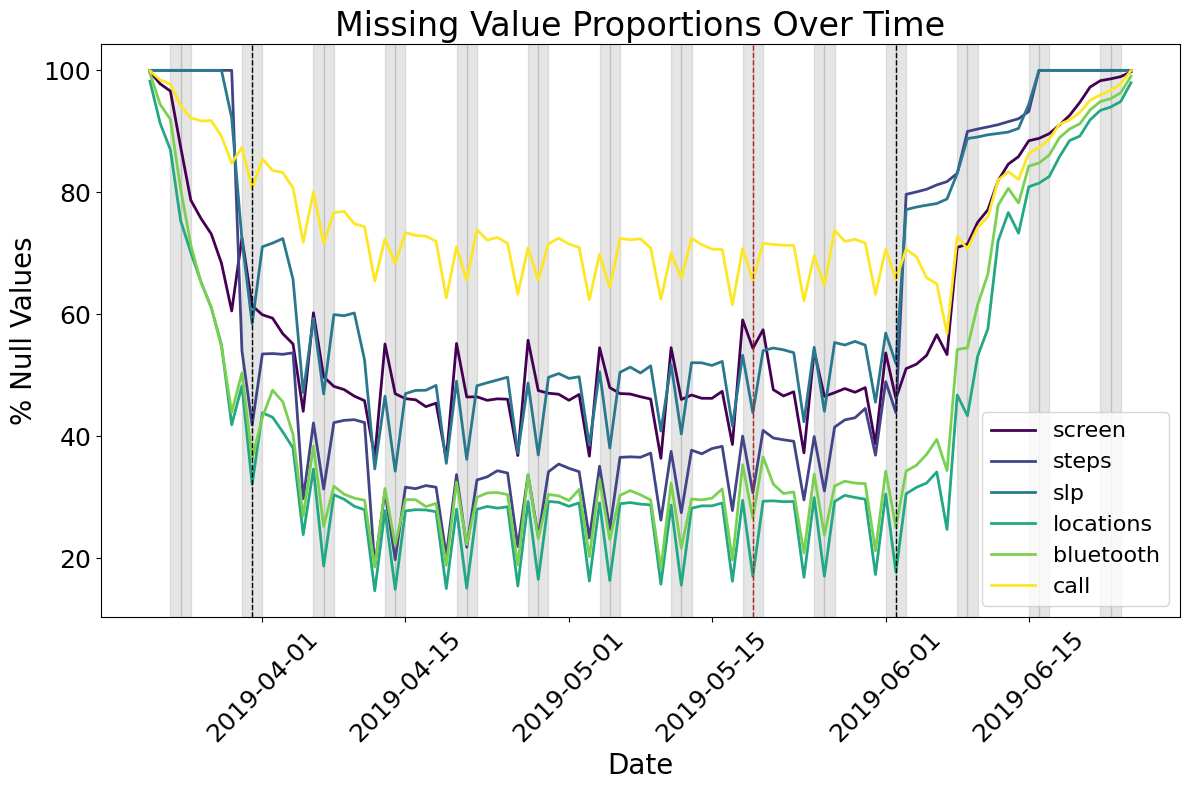

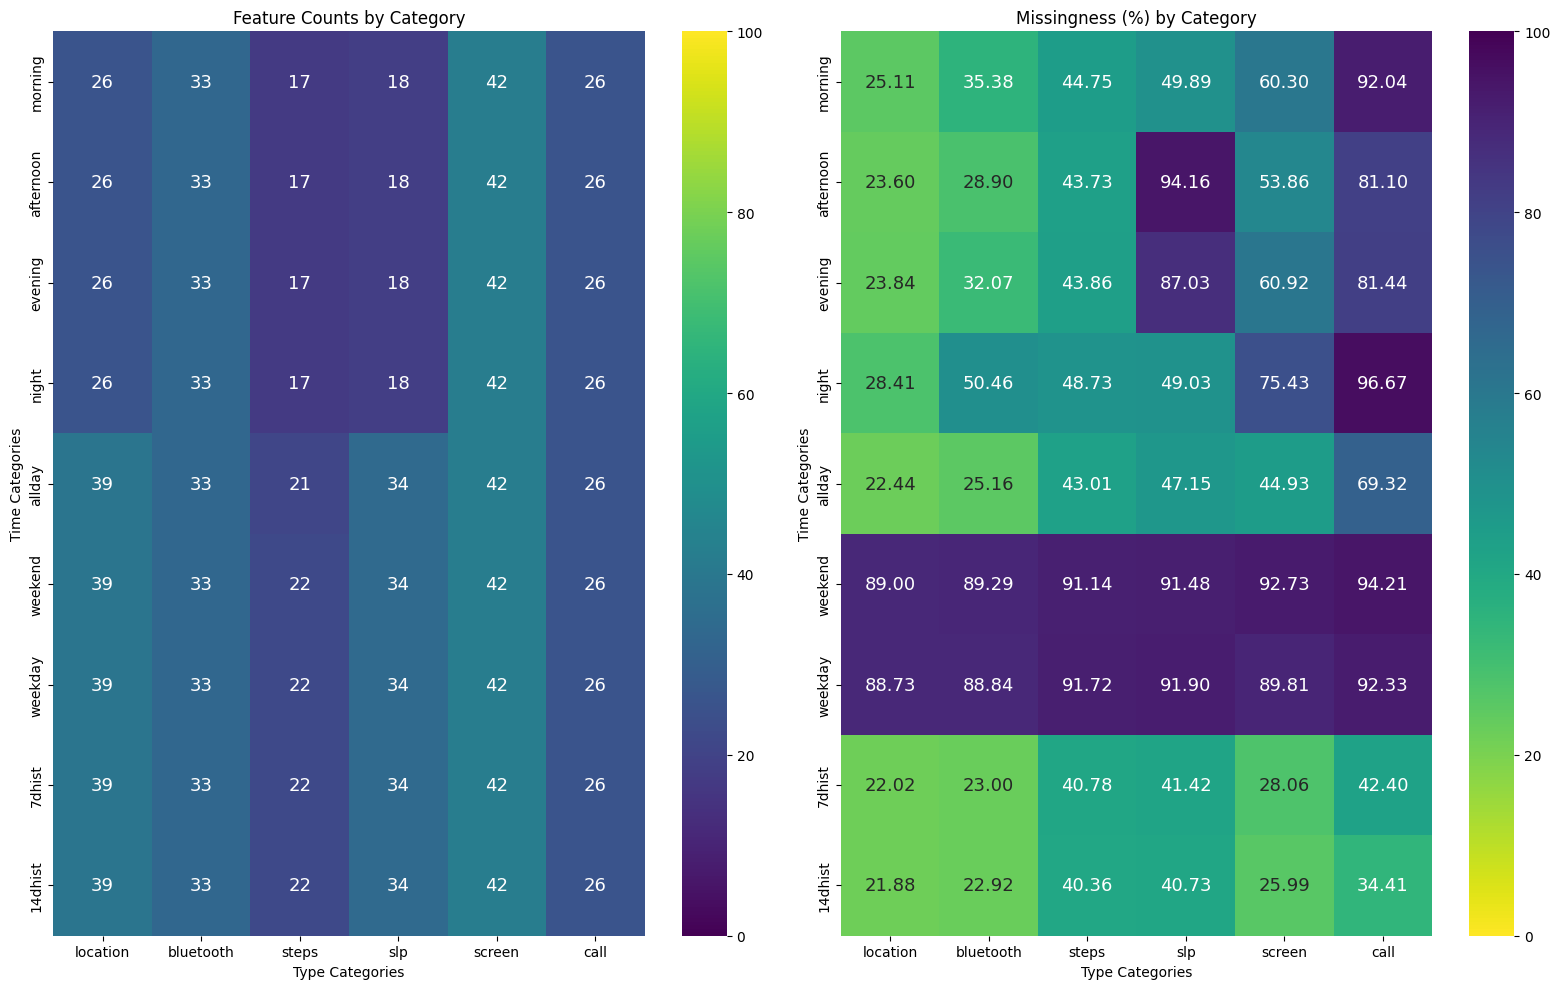

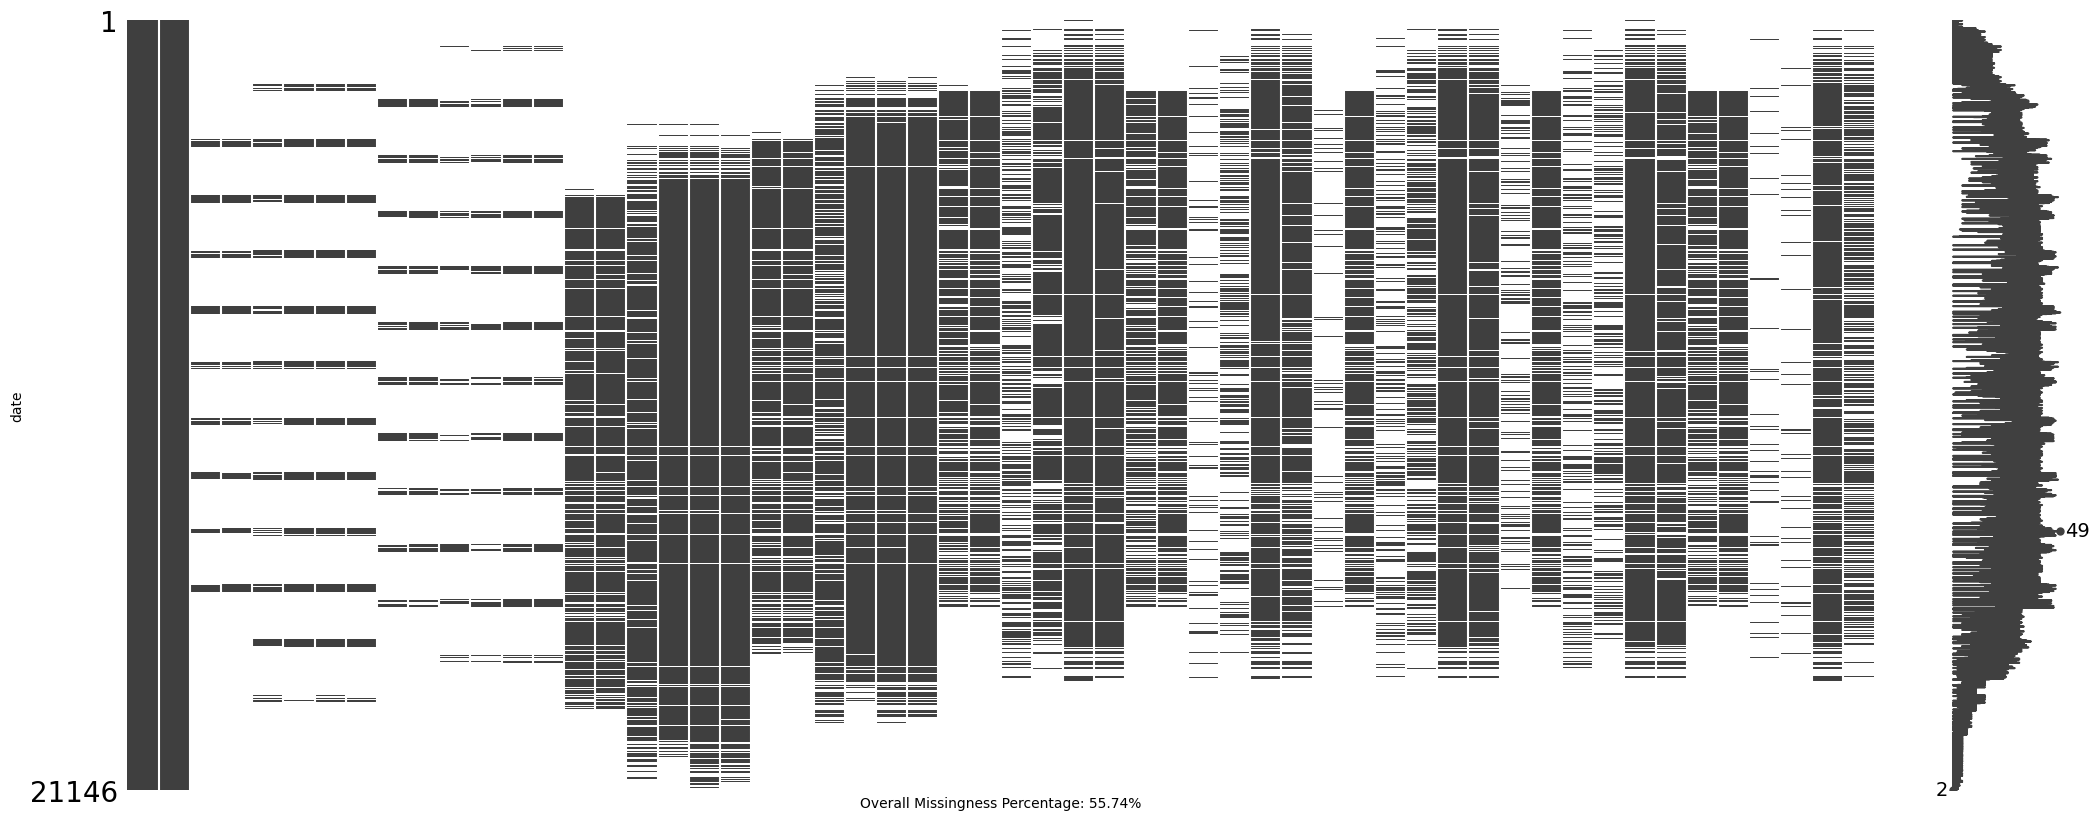

In [35]:
_ = graphs(features)

# Missing Value Preprocessing

## Fill forward weekly values
Values are collected once weekly, on Fridays and Sundays, so these values are filled forward for the following 7 days. This should be applied early in the preprocessing, before analysing any specific missingness patterns.

In [36]:
def weekly_ff_features(df):
  print(f"=== Inital shape: {df.shape}, with {df['pid'].nunique()} participants === \n")
  print(f"Missingness before week fill forward: {df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100:.2f}%")
  weekly_features = ['pid', 'date'] + [col for col in df.columns if 'week' in col]
  temp_df = df.copy()
  new_df = temp_df[weekly_features]
  new_df = new_df.groupby('pid', dropna=False).apply(lambda group: group.ffill(limit=7)).reset_index(drop=True)
  temp_df[weekly_features] = new_df[weekly_features]
  print(f"Missingness after week fill forward: {temp_df.isnull().sum().sum() / (len(temp_df) * len(temp_df.columns)) * 100:.2f}%")
  return temp_df

week_filled = weekly_ff_features(features)

=== Inital shape: (21146, 1629), with 218 participants === 

Missingness before week fill forward: 55.74%
Missingness after week fill forward: 42.09%


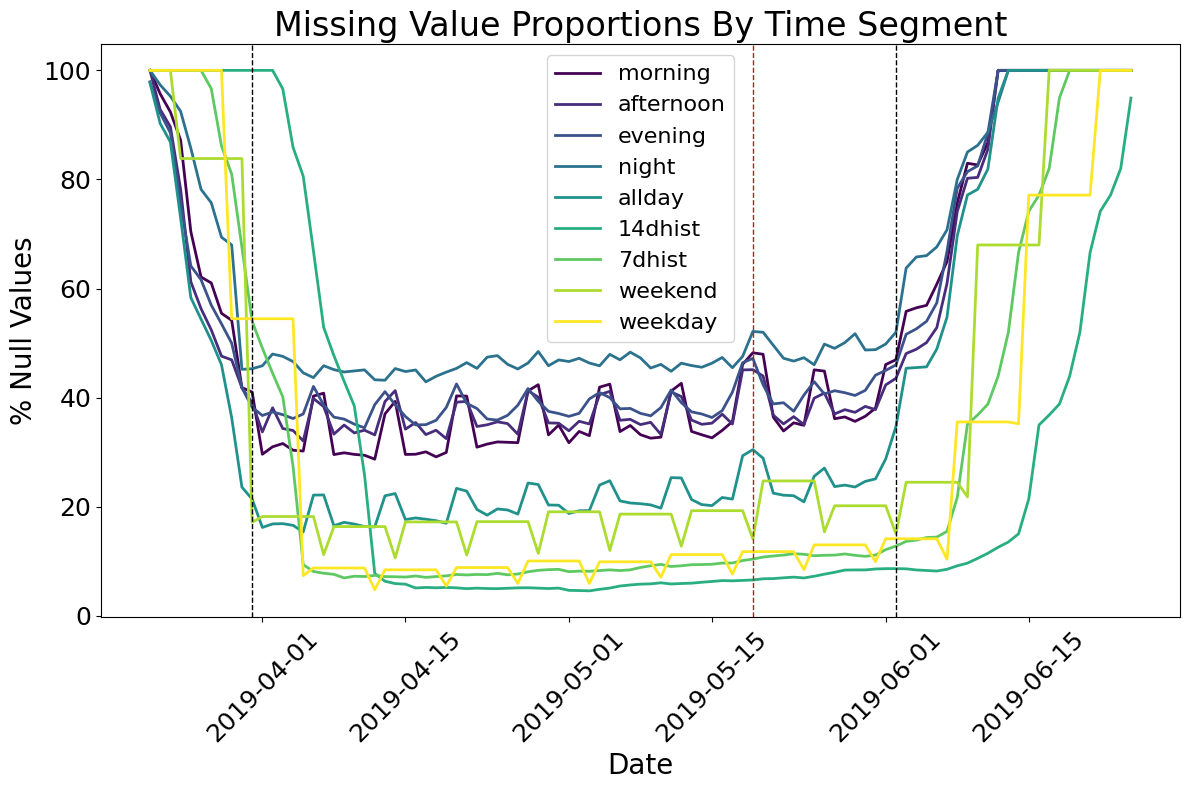

pid       date  \
0      INS-W_300 2019-03-21   
1      INS-W_300 2019-03-22   
2      INS-W_300 2019-03-23   
3      INS-W_300 2019-03-24   
4      INS-W_300 2019-03-25   
...          ...        ...   
21141  INS-W_572 2019-06-21   
21142  INS-W_572 2019-06-22   
21143  INS-W_572 2019-06-23   
21144  INS-W_572 2019-06-24   
21145  INS-W_572 2019-06-25   

       f_slp:fitbit_sleep_summary_rapids_sumdurationafterwakeupmain:14dhist  \
0                                                    NaN                      
1                                                    NaN                      
2                                                    NaN                      
3                                                    NaN                      
4                                                    NaN                      
...                                                  ...                      
21141                                                NaN                      
21142                                                NaN                      
21143                                                NaN                      
21144                                                NaN                      
21145                                                NaN                      

       f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:14dhist  \
0                                                    NaN                 
1                                                    NaN                 
2                                                    NaN                 
3                                                    NaN                 
4                                                    NaN                 
...                                                  ...                 
21141                                                NaN                 
21142                                                NaN                 
21143                                                NaN                 
21144                                                NaN                 
21145                                                NaN                 

       f_slp:fitbit_sleep_summary_rapids_sumdurationawakemain:14dhist  \
0                                                    NaN                
1                                                    NaN                
2                                                    NaN                
3                                                    NaN                
4                                                    NaN                
...                                                  ...                
21141                                                NaN                
21142                                                NaN                
21143                                                NaN                
21144                                                NaN                
21145                                                NaN                

       f_slp:fitbit_sleep_summary_rapids_sumdurationtofallasleepmain:14dhist  \
0                                                    NaN                       
1                                                    NaN                       
2                                                    NaN                       
3                                                    NaN                       
4                                                    NaN                       
...                                                  ...                       
21141                                                NaN                       
21142                                                NaN                       
21143                                                NaN                       
21144                                                NaN                       
21145                                        

In [37]:
plot_missingness_over_time(week_filled, title='Missing Value Proportions By Time Segment')

## Select Date Range



In [38]:
def select_date_range(df):
  print(f'=== Selecting dates only between {START_DATE} and {END_DATE} ===')
  print(f'Missingness before date filtering: {df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100:.2f}%')

  mask = (df['date'] >= START_DATE) & (df['date'] <= END_DATE)
  print(f"Missingness after date filtering: {df.loc[mask].isnull().sum().sum() / (df.loc[mask].shape[0] * df.loc[mask].shape[1]) * 100:.2f}%")
  return df.loc[mask]

selected_dates = select_date_range(week_filled)

=== Selecting dates only between 2019-03-31 00:00:00 and 2019-06-02 00:00:00 ===
Missingness before date filtering: 42.09%
Missingness after date filtering: 25.68%


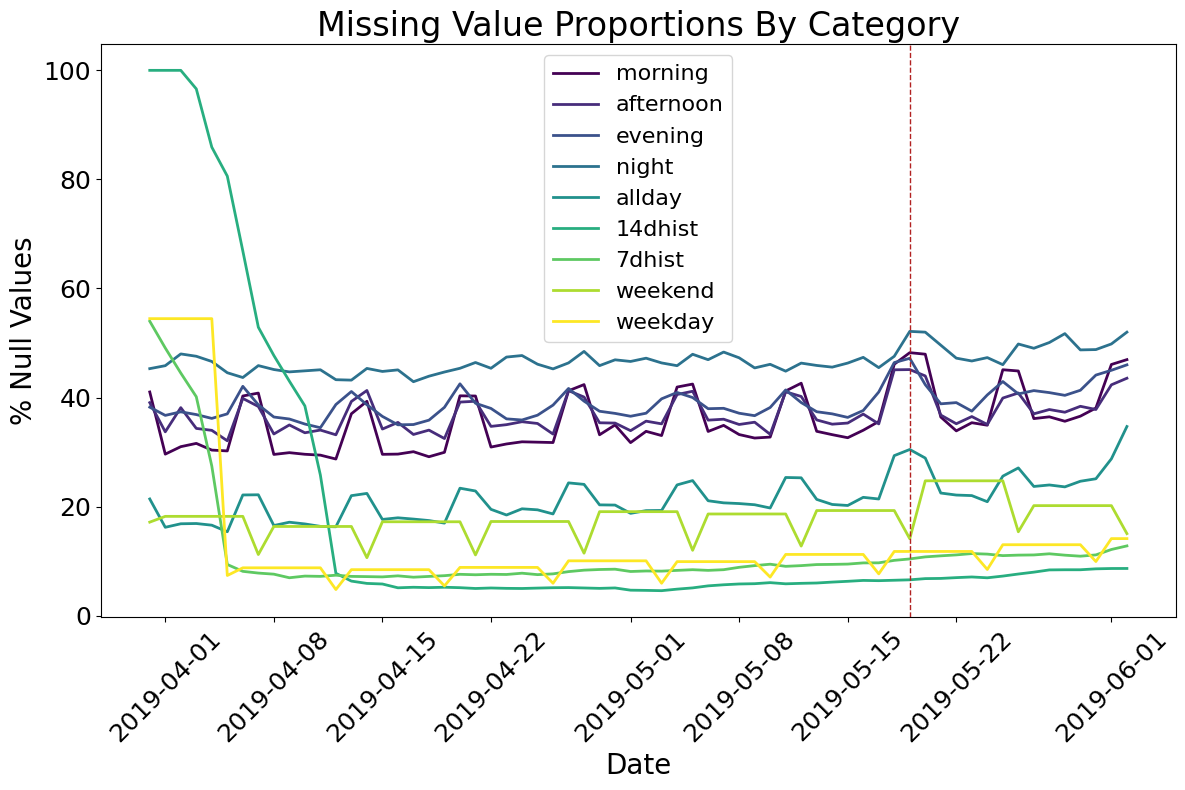

pid       date  \
10     INS-W_300 2019-03-31   
11     INS-W_300 2019-04-01   
12     INS-W_300 2019-04-02   
13     INS-W_300 2019-04-03   
14     INS-W_300 2019-04-04   
...          ...        ...   
21118  INS-W_572 2019-05-29   
21119  INS-W_572 2019-05-30   
21120  INS-W_572 2019-05-31   
21121  INS-W_572 2019-06-01   
21122  INS-W_572 2019-06-02   

       f_slp:fitbit_sleep_summary_rapids_sumdurationafterwakeupmain:14dhist  \
10                                                   NaN                      
11                                                   NaN                      
12                                                   NaN                      
13                                                   NaN                      
14                                                   NaN                      
...                                                  ...                      
21118                                                6.0                      
21119                                                6.0                      
21120                                                6.0                      
21121                                                6.0                      
21122                                                6.0                      

       f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:14dhist  \
10                                                   NaN                 
11                                                   NaN                 
12                                                   NaN                 
13                                                   NaN                 
14                                                   NaN                 
...                                                  ...                 
21118                                             6338.0                 
21119                                             6358.0                 
21120                                             6311.0                 
21121                                             6327.0                 
21122                                             5898.0                 

       f_slp:fitbit_sleep_summary_rapids_sumdurationawakemain:14dhist  \
10                                                   NaN                
11                                                   NaN                
12                                                   NaN                
13                                                   NaN                
14                                                   NaN                
...                                                  ...                
21118                                              241.0                
21119                                              252.0                
21120                                              235.0                
21121                                              247.0                
21122                                              229.0                

       f_slp:fitbit_sleep_summary_rapids_sumdurationtofallasleepmain:14dhist  \
10                                                   NaN                       
11                                                   NaN                       
12                                                   NaN                       
13                                                   NaN                       
14                                                   NaN                       
...                                                  ...                       
21118                                                0.0                       
21119                                                0.0                       
21120                                                0.0                       
21121                                                0.0                       
21122                                        

In [39]:
plot_missingness_over_time(selected_dates, title='Missing Value Proportions By Category')

## Apply Null Adjustment

This process finds null values that we can guess to be of real value zero, and replace these nulls with zero where appropriate.

This method applies the following process:


1.   Select all daily data to create a new dataframe, and drop any rows that are completely empty, as we don't want to apply the correction to these completely empty days of the data.
2.   On this new data frame, replace all null values with zero, with some exceptions. The exceptions we have included are:
   

*   Location: The missingness proportions are already at an acceptable level.
*   First/Last timestamps: a zero value means midnight in this system
*   Standard deviations: a zero value may skew data (could also consider 'entropy')
*   14 day histories: when dealing with the longer data later, we limit these periods to 7 days instead of 14, as we are missing much of the data at the start of the survey, before the 14 day averages can kick in.

You could also look at including 'ratioduration', as this often has null values based on other values being zero. For now, we also impute these values with zero.


3. In the daily data, where all null values are now zero, we identify rows where the fitbit appears to be faulty. We do this by looking at certain variables to determine if any sleep or steps are logged for that day of the data. Any rows we find that have 0 sleep and steps recorded can be assumed to be faulty (or that the fitbit was not being worn), and we change all sleep and steps values in that row back to null.

4. Same as step 3, but for the 'phone' data, ie screen, bluetooth, and calls.

5. Apply a similar process to the longer periods of data (ie 7 day history and weekends/weekdays), but only adjusting the call and 'locmap' variables.

If graphs == True, as it is by default, this function plots the missingness of the daily data in the two sensors separately, and also plots the 'locmap' missingness in relation to the screen variables.


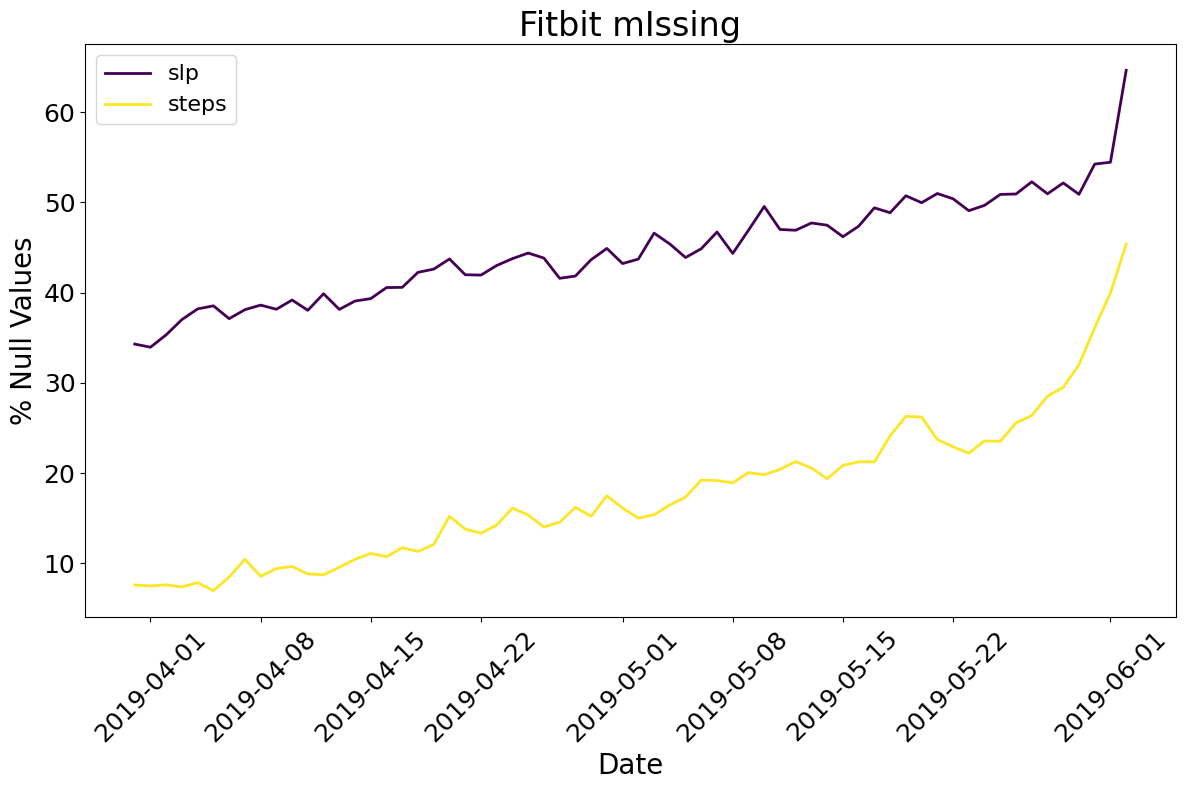

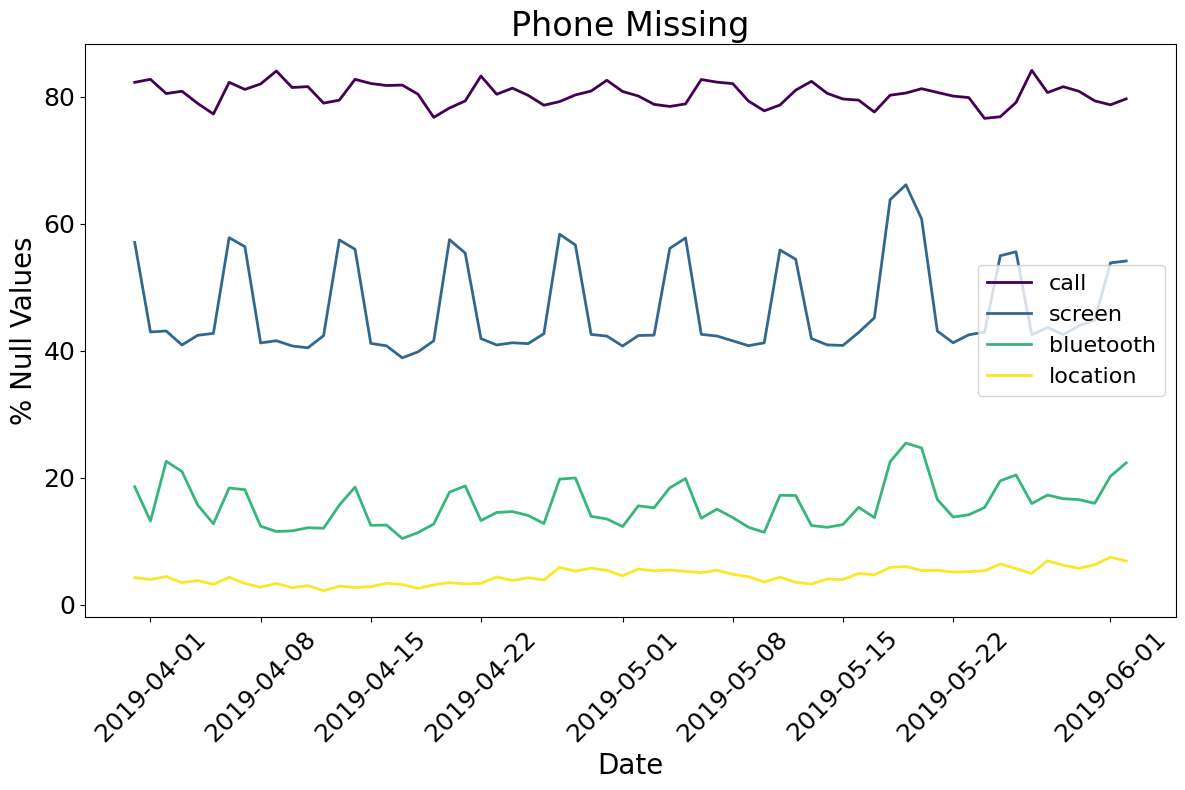

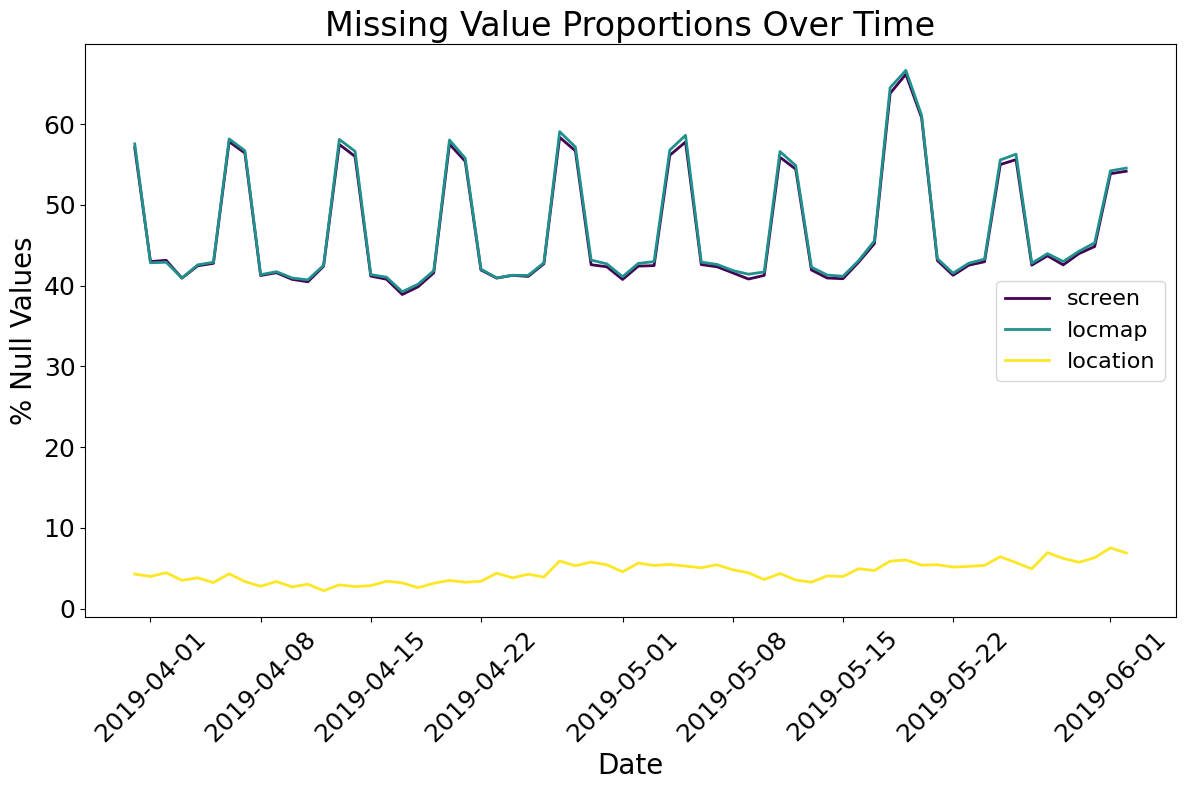

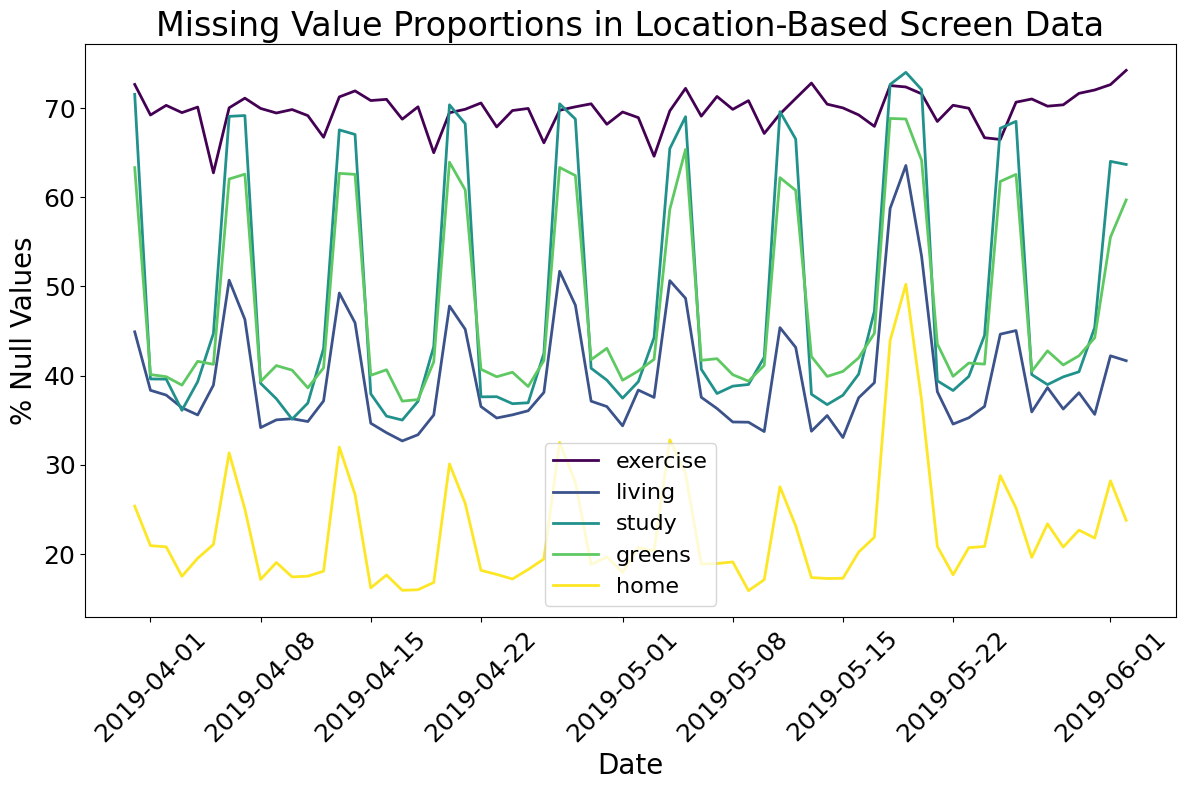

Shape before empty removal: (13952, 850)
Shape after empty removal: (13952, 850)
Total fitbit faulty rows: 1887
Total phone faulty rows: 362

=== Checking for Empty Daily Values After Null Adjustment ===
Total rows before drop: 13952
Total rows after drop: 13952
Total empty daily values after: 1558174
Percentage of empty daily values after: 13.2%


In [40]:
import pandas as pd
import numpy as np

def null_adjustment(df, graphs = True):
    daily_segments = 'morning|afternoon|evening|night|allday'
    longer_segments = 'week|hist'

    ignore = 'time|first|_std' # features that it might not make sense to replace with zero


    # identify where values are missing on a daily scale
    faulty_df = features[['pid', 'date']].copy()

    # fitbit faulty
    faulty_df['f_slp:logged_allday'] = features[f'f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:allday'] > 0
    faulty_df[f'f_steps:logged_allday'] = features['f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout:allday'] > 0
    faulty_df['f_slp:logged_allday'] |= features['f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:allday'] > 0

    # phone faulty
    faulty_df[f'f_screen:logged_allday'] = features[f'f_screen:phone_screen_rapids_countepisodeunlock:allday'] > 0
    faulty_df[f'f_call:logged_allday'] = features['f_call:phone_calls_rapids_incoming_count:allday'] > 0
    faulty_df['f_call:logged_allday'] |= features['f_call:phone_calls_rapids_outgoing_count:allday'] > 0
    faulty_df['f_blue:logged_allday'] = features['f_blue:phone_bluetooth_rapids_countscans:allday'] > 0


    temp = df.copy()
    temp['date'] = pd.to_datetime(temp['date'], format='%Y-%m-%d')

    # make adjustments to daily data
    daily = temp.loc[:, df.columns.str.contains(daily_segments)]
    daily['pid'] = temp['pid']
    daily['date'] = pd.to_datetime(temp['date'], format='%Y-%m-%d')

    if graphs:
      plot_missingness_over_time(daily, keywords = ['slp', 'steps'], cutoff_date=None, title='Fitbit mIssing')
      plot_missingness_over_time(daily, keywords = ['call', 'screen','bluetooth', 'location'], cutoff_date=None, title='Phone Missing')
      plot_missingness_over_time(daily, keywords = ['screen', 'locmap', 'location'], cutoff_date=None)
      plot_missingness_over_time(daily, by_locmap= True, cutoff_date=None, title='Missing Value Proportions in Location-Based Screen Data')


    daily = daily.merge(faulty_df, on=['pid', 'date'], how='left')

    print('Shape before empty removal:', daily.shape)
    # Drop rows from daily if entirely null except pid and date
    daily = daily[daily.notna().sum(axis=1) > 2]
    print('Shape after empty removal:', daily.shape)

    # Replace nulls with zeros across all qualifying rows and columns
    fill_cols = [col for col in daily.columns if not any(substring in col for substring in ignore.split('|'))]
    daily.loc[:, fill_cols] = daily.loc[:, fill_cols].fillna(0)

    # Undo zeros with nulls where Fitbit data is faulty (no steps and no sleep)
    fitbit_cols = [col for col in daily.columns if 'f_slp' in col or 'f_steps' in col]
    faulty_indices = (daily['f_slp:logged_allday'] == False) & (daily[f'f_steps:logged_allday'] == False)
    print(f"Total fitbit faulty rows: {sum(faulty_indices)}")

    # Use the boolean mask to replace zeros with NaN in faulty rows
    daily.loc[faulty_indices, fitbit_cols] = daily.loc[faulty_indices, fitbit_cols].replace(0, np.nan)

    # Undo zeros when phone faulty
    phone_cols = [col for col in daily.columns if ('f_screen' in col or 'f_call' in col or 'f_blue' in col) and 'week' not in col]
    faulty_indices = (daily['f_screen:logged_allday'] == False) & (daily['f_call:logged_allday'] == False) & (daily['f_blue:logged_allday'] == False)
    print(f"Total phone faulty rows: {sum(faulty_indices)}")

    # Use the boolean mask to replace zeros with NaN in faulty rows
    daily.loc[faulty_indices, phone_cols] = daily.loc[faulty_indices, phone_cols].replace(0, np.nan)

    # Drop 'logged' traits (those columns containing 'logged' in the name)
    daily = daily.drop(columns=[col for col in daily.columns if 'logged' in col])

    # Print count of empty daily values
    print("\n=== Checking for Empty Daily Values After Null Adjustment ===")
    print(f"Total rows before drop: {len(df)}")
    print(f"Total rows after drop: {len(daily)}")
    print(f"Total empty daily values after: {daily.isnull().sum().sum()}")
    print(f"Percentage of empty daily values after: {daily.isnull().sum().sum() / (len(daily) * len(daily.columns)):.1%}")


    pid_dates = temp[['pid', 'date']]
    merged = pid_dates.merge(daily, on=['pid', 'date'], how='left')

    for segment in longer_segments.split('|'):
        longer = df.loc[:, df.columns.str.contains(segment)]
        longer['pid'] = temp['pid']
        longer['date'] = pd.to_datetime(temp['date'], format='%Y-%m-%d')
        longer = longer[longer.notna().sum(axis=1) > 2]

        # # replace any columns containing locmap or call with zero unless in ignore
        filling_columns = [col for col in longer.columns if not any(substring in col for substring in ignore.split('|')) and ('locmap' in col or 'call' in col)]
        longer.loc[:, filling_columns] = longer.loc[:, filling_columns].fillna(0)

        merged = merged.merge(longer, on=['pid', 'date'], how='left')

    return merged

adjusted = null_adjustment(selected_dates)

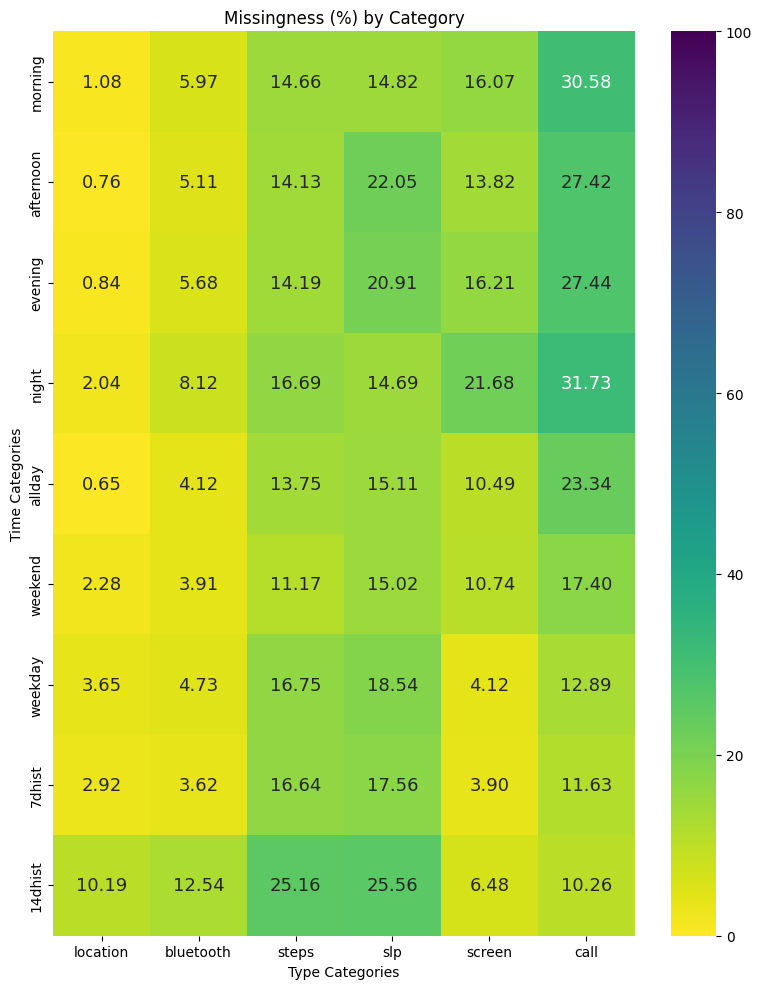

In [41]:
_ = display_feature_table_missingness(adjusted)

## Remove high missingness

In [42]:
def remove_features_with_high_missingness(df, feature_threshold=0.5, participant_threshold=0.3):
    # Store original dimensions
    original_shape = df.shape
    original_participants = df['pid'].nunique()

    temp = df.copy()

    # Feature-level removal
    feature_missing = temp.isnull().mean()
    features_to_keep = feature_missing[feature_missing <= feature_threshold].index
    features_removed = set(temp.columns) - set(features_to_keep)
    temp = temp[features_to_keep]


    print("\n=== Missing Data Removal Summary ===")
    print(f"Original shape: {original_shape}")
    print(f"Final shape: {temp.shape}")
    print(f"Participants removed: {original_participants - temp['pid'].nunique()} ({(original_participants - temp['pid'].nunique())/original_participants:.1%})")
    print(f"\nFeatures removed: {len(features_removed)} ({len(features_removed)/original_shape[1]:.1%})")

    print("\n=== Missingness After Cleaning ===")
    print(f"Average feature missingness: {temp.isnull().mean().mean():.1%}")
    print(f"Average participant missingness: {temp.isnull().mean(axis=1).mean():.1%}")

    return temp

def remove_pids_with_high_missingness(df, threshold=0.3):
    print(f'=== Participant removal with {threshold*100}% missingness threshold. === \n')
    # Calculate the mean proportion of missing values for each pid
    missing_percentages = df.groupby("pid").apply(lambda x: x.isnull().mean().mean())

    # Identify pids to remove
    pids_to_remove = missing_percentages[missing_percentages >= threshold].index.tolist()

    # Filter out pids
    filtered_df = df[~df["pid"].isin(pids_to_remove)].copy()

    print(f"Removed {len(pids_to_remove)} participants (pids): {pids_to_remove}")
    print(f"Shape before cleaning: {df.shape}")
    print(f"Shape after cleaning: {filtered_df.shape}")


    return filtered_df

def remove_days_with_high_missingness(df, threshold=0.8):
    print(f'=== Row removal with {threshold*100}% missingness threshold. === \n')
    # Calculate the proportion of missing values for each row
    missing_percentages = df.isnull().sum(axis=1) / len(df.columns)

    # Filter out rows where the missing percentage is greater than or equal to the threshold
    filtered_df = df[missing_percentages < threshold]

    return filtered_df

selected_dates_cleaned = remove_days_with_high_missingness(adjusted)
selected_dates_cleaned = remove_pids_with_high_missingness(selected_dates_cleaned)


=== Row removal with 80.0% missingness threshold. === 

=== Participant removal with 30.0% missingness threshold. === 

Removed 10 participants (pids): ['INS-W_316', 'INS-W_361', 'INS-W_436', 'INS-W_460', 'INS-W_479', 'INS-W_527', 'INS-W_535', 'INS-W_536', 'INS-W_555', 'INS-W_556']
Shape before cleaning: (13820, 1629)
Shape after cleaning: (13304, 1629)


## Impute by PID

Imputes remaining missing values by participant ID. So for example, if a participant forgets to wear their fitbit for a day, that missing data is imputed based on the other days for that participant.

When the null adjustment is applied before this imputation, many variables that previously did not contain any zero values can now be imputed with a value of zero.

By default, this function uses the global CUTOFF_DATE to train each KNN imputer on a participant's training data, and apply it to both the train and test portions for that PID. If you wish to split by participant instead of by a cutoff date, set this to None.

In [43]:
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd

def impute_by_participant(df, pid_col='pid', use_global_imputation=False, n_neighbors=5, cutoff_date=CUTOFF_DATE):
    print("\n=== Starting participant-wise KNN imputation ===")
    original_shape = df.shape

    df_imputed = df.copy()

    non_feature_cols = [pid_col, 'date', 'phq4_depression_EMA', 'label', 'week']
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    numeric_features = [col for col in numeric_features if col not in non_feature_cols]

    df_imputed['date'] = pd.to_datetime(df_imputed['date'])  # Ensure date is in correct format

    total_missing_numeric = df[numeric_features].isnull().sum().sum()
    participant_imputed_numeric = 0
    global_imputed_numeric = 0

    print(f"\nInitially missing {total_missing_numeric} values across {len(numeric_features)} features and {df[pid_col].nunique()} participants")

    for pid in df[pid_col].unique():
        mask = df_imputed[pid_col] == pid
        if cutoff_date is not None: # default
            train_mask = mask & (df_imputed['date'] < cutoff_date)
        else:
            train_mask = mask

        if numeric_features:
            participant_data = df_imputed.loc[mask, numeric_features]
            train_data = df_imputed.loc[train_mask, numeric_features]

            if train_data.isnull().all().all():
                print(f"Skipping KNN for pid {pid}: No usable data in training set")
                continue

            imputer = KNNImputer(n_neighbors=n_neighbors, keep_empty_features=True)
            imputer.fit(train_data)
            imputed_values = imputer.transform(participant_data)

            df_imputed.loc[mask, numeric_features] = pd.DataFrame(imputed_values, index=participant_data.index, columns=numeric_features)
            participant_imputed_numeric += participant_data.isnull().sum().sum()

    if use_global_imputation and df_imputed[numeric_features].isnull().sum().sum() > 0:
        train_mask = df_imputed['date'] < CUTOFF_DATE
        global_imputer = KNNImputer(n_neighbors=n_neighbors, keep_empty_features=True)
        imputed_values = global_imputer.fit_transform(df_imputed[numeric_features])

        if imputed_values.shape[1] == len(numeric_features):
            df_imputed[numeric_features] = pd.DataFrame(imputed_values, index=df_imputed.index, columns=numeric_features)
        else:
            print("Warning: Global imputation produced shape mismatch. Skipping global imputation.")

        global_imputed_numeric = df_imputed[numeric_features].isnull().sum().sum()

    final_missing_numeric = df_imputed[numeric_features].isnull().sum().sum() if numeric_features else 0

    print("\n=== Imputation Summary ===")
    print(f"Values imputed using participant KNN: {participant_imputed_numeric}")
    if use_global_imputation:
        print(f"Values imputed using global KNN: {global_imputed_numeric}")
    print(f"Remaining missing values: {final_missing_numeric}")

    assert df_imputed.shape == original_shape, "Shape of DataFrame changed during imputation"
    assert df_imputed[numeric_features].isnull().sum().sum() == 0, "Some numerical missing values remain"

    return df_imputed



# imputed = impute_by_participant(selected_dates_cleaned)

## Smart Correlation - outside pipeline

Applying this outside the pipeline makes it easier for us to analyse the groups of correlated variables. However, I would recommend applying this within the pipeline if cross-validation is being used.

Because the variables fit neatly into several categories, applying a correlation filter can help to remove variables that offer similar information about the participants' habits.

We can also use this to identify if any whole time segments are highly correlated, and potentially provide the same information.

In [44]:
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.feature_selection import VarianceThreshold
from datetime import datetime
import pickle

def remove_correlated(df, cutoff_date=None, date_column='date', return_dict=False):
    print('\n=== Apply Variance and Correlation Filters ===\n')

    # Ensure date_column is datetime
    if cutoff_date is not None:
        df = df.copy()
        df[date_column] = pd.to_datetime(df[date_column])
        train_mask = df[date_column] <= pd.to_datetime(cutoff_date)
    else:
        train_mask = pd.Series([True] * len(df), index=df.index)

    # Get numeric features (for both full and training set)
    df_numeric = df.select_dtypes(include=['number'])
    if 'phq4_depression_EMA' in df_numeric.columns:
        df_numeric = df_numeric.drop(columns=['phq4_depression_EMA'])

    df_train_numeric = df_numeric.loc[train_mask]

    # === Variance Filter ===
    variance_filter = VarianceThreshold(threshold=0.0)
    variance_filter.fit(df_train_numeric)

    retained_after_variance = df_numeric.columns[variance_filter.get_support()]
    df_filtered = df_numeric[retained_after_variance]
    print(f"Number of features removed after variance filter: {df_numeric.shape[1] - len(retained_after_variance)}")

    # === Correlation Filter ===
    correlation_filter = SmartCorrelatedSelection(
        method="spearman",
        threshold=0.7,
        missing_values="ignore",
        selection_method="variance"
    )
    correlation_filter.fit(df_filtered.loc[train_mask])

    if return_dict:
        return correlation_filter.correlated_feature_sets_

    # Use features_to_drop_ to get features to retain
    features_to_drop = correlation_filter.features_to_drop_  # Get features to drop
    retained_after_correlation = [f for f in df_filtered.columns if f not in features_to_drop] # Get features to keep


    df_filtered = df_filtered[retained_after_correlation]
    print(f"Number of features removed after correlation filter: {len(retained_after_variance) - len(retained_after_correlation)}")

    # Concatenate non-numeric and filtered numeric features
    df_final = pd.concat([df.select_dtypes(exclude=['number']), df_filtered], axis=1)

    # Save correlation dictionary with current timestamp
    now = datetime.now().strftime("%Y-%m-%d %H:%M")
    corr_dict = correlation_filter.correlated_feature_sets_
    with open(f'{target_dir}corr_dict_{now}.pkl', 'wb') as f:
        pickle.dump(corr_dict, f)

    return df_final


## Add Depression Labels

Either linearly interpolate the labels between given dates, or add a categorical variable that determines whether the participant's depression score is increasing (ie worsening) or not. This could easily be adjusted to show increasing, decreasing, and staying the same, if required.

A linear assumption in mood may not exactly replicate true behavioural patterns, but without further context about a participant's situation and other extrnal factors, it is the best way to retain as much of the data as possible. Filling values forward introduces a lot of inaccuracy in participants whose mood changes by a large amount in a week, while interpolating the value reduces the negative impact of this on the predictions.

In [45]:
def linearly_interpolate_labels(df, get_df_only=False):
    """
    This function is to assign the weekly depression scores to daily behavioral features based on EMA responses.
    Each EMA score is applied to the previous 7 days of behavioral data.
    """
    ema_df = ema[['pid', 'date', 'phq4_depression_EMA']].dropna()

    # Convert 'date' column in ema to datetime64[ns]
    ema_df['date'] = pd.to_datetime(ema_df['date'])
    df['date'] = pd.to_datetime(df['date'])

    # Use ema_df instead of ema to ensure consistent shape
    date_range = pd.date_range(start=ema_df['date'].min(), end=ema_df['date'].max(), freq='D')
    pids = ema_df['pid'].unique()

    pids_df = pd.DataFrame({'pid': pids})

    new = pd.merge(pids_df, pd.DataFrame({'date':date_range}), how='cross')
    w_labels = pd.merge(new, ema_df, on=['pid', 'date'], how='left')

    # Ensure 'pid' is of consistent type (string) before grouping
    w_labels['pid'] = w_labels['pid'].astype(str)

    # Reset index before applying interpolation to avoid index mismatches
    w_labels = w_labels.reset_index(drop=True)

    w_labels['phq4_depression_EMA'] = w_labels.groupby('pid')['phq4_depression_EMA'].apply(
    lambda group: group.interpolate(
        method='linear',
        limit_direction='both',
        limit_area='inside',  # Only fill NaNs surrounded by valid values
        limit=10  # Limit the maximum number of consecutive NaNs to fill
    )
    ).values # Get values to avoid index alignment issues

    if get_df_only:
        return w_labels

    merged = pd.merge(df, w_labels, on=['pid', 'date'], how='right')

    merged = merged.dropna() # applying labels after all other preprocessing so it's fine

    print("\n=== After Removing Missing Labels ===")
    print(f"Total rows in dataset: {len(merged)}")
    print(f"Rows with missing phq4 depression: {merged['phq4_depression_EMA'].isna().sum()}")

    return merged


def categorical_label(df, get_df_only=False):
    ema_df = ema[['pid', 'date', 'phq4_depression_EMA']].dropna()
    ema_df['date'] = pd.to_datetime(ema_df['date'])
    df['date'] = pd.to_datetime(df['date'])

    date_range = pd.date_range(start=ema_df['date'].min(), end=ema_df['date'].max(), freq='D')
    pids = ema_df['pid'].unique()
    full_grid = pd.DataFrame({'date': date_range}).assign(key=1).merge(pd.DataFrame({'pid': pids, 'key': 1}), on='key').drop('key', axis=1)

    # Add EMA scores to full grid
    full_grid = pd.merge(full_grid, ema_df, on=['pid', 'date'], how='left')
    full_grid = full_grid.sort_values(['pid', 'date'])

    # Add trend label between EMA dates
    def assign_trend_labels(group):
      group = group.reset_index(drop=True)
      group['phq4_worsening'] = None

      ema_indices = group.index[group['phq4_depression_EMA'].notna()].tolist()

      for i in range(len(ema_indices) - 1):
          idx_start = ema_indices[i]
          idx_end = ema_indices[i + 1]
          score_start = group.loc[idx_start, 'phq4_depression_EMA']
          score_end = group.loc[idx_end, 'phq4_depression_EMA']

          trend = 'yes' if score_end > score_start else 'no'
          group.loc[idx_start + 1:idx_end, 'phq4_worsening'] = trend  # from day after EMA to next EMA
      return group


    labeled_df = full_grid.groupby('pid').apply(assign_trend_labels).reset_index(drop=True)

    if get_df_only:
        return labeled_df

    merged = pd.merge(df, labeled_df[['pid', 'date', 'phq4_worsening']], on=['pid', 'date'], how='inner')
    merged = merged.dropna(subset=['phq4_worsening'])

    print("\n=== After Labeling Trends ===")
    print(f"Total rows: {len(merged)}")
    print(f"Missing trend labels: {merged['phq4_worsening'].isna().sum()}")

    return merged



## Analyze Patterns

Some final touches on the missingness. Not all of these features are used, but it helpful to retain them for if they are needed.

In [46]:
def analyze_missing_data_patterns(df):

        print("\n=== Missing Data Analysis ===")

        df['date'] = pd.to_datetime(df['date'])

        df = df.sort_values(['pid', 'date'])

        missing_data_summary = []
        total_gaps = 0
        total_missing_days = 0

        for pid, group in df.groupby('pid'):
            # Create a complete date range for this participant
            date_range = pd.date_range(start=group['date'].min(),
                                       end=group['date'].max(),
                                       freq='D')

            # Find missing dates
            existing_dates = set(group['date'].dt.date)
            expected_dates = set(date_range.date)
            missing_dates = expected_dates - existing_dates

            # Calculate gaps (consecutive missing days)
            date_diff = group['date'].diff().dt.days
            gaps = date_diff[date_diff > 1]

            summary = {
                'pid': pid,
                'total_days': len(date_range),
                'recorded_days': len(group),
                'missing_days': len(missing_dates),
                'missing_percentage': (len(missing_dates) / len(date_range)) * 100,
                'number_of_gaps': len(gaps),
                'max_gap_size': gaps.max() if not gaps.empty else 0,
                'avg_gap_size': gaps.mean() if not gaps.empty else 0
            }

            missing_data_summary.append(summary)
            total_gaps += len(gaps)
            total_missing_days += len(missing_dates)

        # Convert to DataFrame for analysis
        summary_df = pd.DataFrame(missing_data_summary)

        # Print summary statistics
        print("\nOverall Summary:")
        print(f"Total participants: {len(summary_df)}")
        print(f"Total missing days: {total_missing_days}")
        print(f"Total number of gaps: {total_gaps}")
        print(f"\nMissing Data Statistics:")
        print(summary_df[['missing_percentage', 'number_of_gaps', 'max_gap_size']].describe())

        # Identify participants with severe missing data
        severe_missing = summary_df[summary_df['missing_percentage'] > 20]

        print(f"\nParticipants with >20% missing data: {len(severe_missing)}")

        # Generate recommendations
        print("\nRecommendations:")
        if len(severe_missing) > 0:
            print(f"- Consider removing {len(severe_missing)} participants with >20% missing dates")

        return summary_df

# Remove participants with >20% missing data
def clean_dataset(df, max_missing_percentage=20):
        # Get participant-wise missing data percentage
        summary_df = analyze_missing_data_patterns(df)

        # Get valid participants
        valid_pids = summary_df[summary_df['missing_percentage'] <= max_missing_percentage]['pid']

        # Filter dataset
        cleaned_df = df[df['pid'].isin(valid_pids)].copy()

        print(f"Original participants: {df['pid'].nunique()}")
        print(f"Participants after cleaning: {cleaned_df['pid'].nunique()}")
        print(f"Original records: {len(df)}")
        print(f"Records after cleaning: {len(cleaned_df)}")

        return cleaned_df

    # Handle remaining gaps
def handle_gaps(df, max_gap_size=5):
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'])

        processed_data = []

        for pid, group in df.groupby('pid'):
            # Sort by date
            group = group.sort_values('date')

            # Create complete date range
            date_range = pd.date_range(start=group['date'].min(),
                                       end=group['date'].max(),
                                       freq='D')

            # Reindex to include missing dates
            group_reindexed = group.set_index('date').reindex(date_range)

            # Interpolate gaps smaller than max_gap_size
            group_reindexed['phq4_depression_EMA'] = group_reindexed['phq4_depression_EMA'].interpolate(
                method='linear',
                limit=max_gap_size
            )

            # Add back pid column
            group_reindexed['pid'] = pid

            processed_data.append(group_reindexed.reset_index().rename(columns={'index': 'date'}))

        final_df = pd.concat(processed_data, ignore_index=True)
        return final_df.dropna()



def verify_data_quality(df):
        print("\n=== Data Quality Verification ===")

        # Check for remaining missing values
        missing = df.isnull().sum()
        print("\nMissing values:")
        print(missing[missing > 0])

        # Verify temporal consistency
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values(['pid', 'date'])

        # Check for remaining gaps
        gaps = df.groupby('pid')['date'].diff().dt.days
        print("\nRemaining gaps summary:")
        print(gaps[gaps > 1].describe())

        print("\nTarget variable distribution:")
        print(df['phq4_depression_EMA'].describe())

        return df

# cleaned_df = clean_dataset(features_with_labels)
# final_df = handle_gaps(cleaned_df) # remove for now, not sure about label interpolation
# final_df = verify_data_quality(final_df)

## Add personality traits

In [47]:
def add_personality(df):
  # personality data - can remove if not adding
  personality = pd.read_csv(personality_filename, index_col=0)
  personality = personality[['pid', 'BFI10_extroversion_PRE', 'BFI10_agreeableness_PRE', 'BFI10_conscientiousness_PRE', 'BFI10_neuroticism_PRE', 'BFI10_openness_PRE']]
  personality.columns = personality.columns.str.replace('_PRE', '')

  w_personality = pd.merge(df, personality, on='pid', how='left')
  w_personality = w_personality.dropna()
  return w_personality
# w_personality = add_personality()

# Model

In [48]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import time
import numpy as np
from sklearn.ensemble import RandomForestRegressor

from feature_engine.selection import SmartCorrelatedSelection
from sklearn.feature_selection import VarianceThreshold

from sklearn.feature_selection import SelectKBest, f_regression

def train_regression_model(df, target_col='phq4_depression_EMA', n_features=50, cv_splits=5, random_state=42, n_iter=10):
    print("\n=== Starting Feature Selection Process ===")


    # Convert date and ensure sorting
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['pid', 'date'])

    # Check date gaps per participant
    date_diff = df.groupby('pid')['date'].diff().dt.days
    if (date_diff > 1).any():
        print("Warning: Gaps in daily data!")

    # order so time series cross validation can pick it up
    df = df.sort_values(['date', 'pid'])

    # Initialize lists to store valid indices
    train_indices = []
    test_indices = []

    # Process each participant
    for pid, group in df.groupby('pid'):
        # Calculate total duration for this participant
        duration = (group['date'].max() - group['date'].min()).days

        # Require at least 50 days of data (approximately 7 weeks)
        if duration >= 50:
            # Get indices for training and testing
            train_idx = group[group['date'] < CUTOFF_DATE].index
            test_idx = group[group['date'] >= CUTOFF_DATE].index

            if len(train_idx) >= 14 and len(test_idx) >= 3:  # Ensure minimum samples in both sets
                train_indices.extend(train_idx)
                test_indices.extend(test_idx)

    train_mask = df.index.isin(train_indices)
    test_mask = df.index.isin(test_indices)

    # Print initial split information
    print("\nInitial split information:")
    print(f"Total participants: {df['pid'].nunique()}")
    print(f"Participants with sufficient data: {len(set(df.loc[train_indices, 'pid']))}")
    print(f"Initial training samples: {len(train_indices)}")
    print(f"Initial test samples: {len(test_indices)}")


    # Prepare feature columns
    non_feature_cols = [target_col, 'previous_depression_EMA', 'next_depression_EMA', 'date', 'pid', 'phq4_depression_EMA', 'depression_change']
    numeric_features = df.select_dtypes(include=['number']).columns
    feature_cols = [col for col in numeric_features if col not in non_feature_cols]

    X = df[feature_cols]
    y = df[target_col]

    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]

    print("\nFinal data split summary:")
    print(f"Training participants: {df[train_mask]['pid'].nunique()}")
    print(f"Test participants: {df[test_mask]['pid'].nunique()}")
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Training proportion: {len(X_train) / (len(X_train) + len(X_test)):.2f}")


    # Just to ensure that we have enough data for cross-validation
    if len(X_train) < 10:
        raise ValueError("Insufficient data for training after applying all filters")

    # Adjust cv_splits based on data size
    cv_splits = min(cv_splits, len(X_train) // 2)
    cv_splits = max(2, cv_splits)  # Ensure at least 2 splits

    print(f"\nUsing {cv_splits} cross-validation splits")

    tscv = TimeSeriesSplit(n_splits=cv_splits)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize the features
        ('variance_filter', VarianceThreshold(threshold=0.0)),  # Remove zero variance features
        ('correlation_filter', SmartCorrelatedSelection(method="spearman", threshold=0.7)),  # Remove highly correlated features
        ('feature_selection', SelectKBest(score_func=f_regression, k=n_features)),  # Select top k features
        ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))  # Random Forest regressor
    ])



# Hyperparamter was intensive so I am using the best params identified here
    param_distributions = {
        'regressor__n_estimators': [200],
        'regressor__max_depth': [None],
        'regressor__max_features': [0.5]
    }

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_squared_error',
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )

    print("\nStarting hyperparameter tuning with time series cross-validation...")
    search.fit(X_train, y_train)

    # Get the indices of selected features based on the original column names
    selected_feature_indices = search.best_estimator_.named_steps['feature_selection'].get_support(indices=True)

    # Map the indices back to the original column names
    selected_feature_names = X_train.columns[selected_feature_indices].tolist()

    # Print or return the real column names of the selected features
    print("\nSelected features:", selected_feature_names)

    # Extract feature importances from the trained regressor
    feature_importances = search.best_estimator_.named_steps['regressor'].feature_importances_

    # Create DataFrame of feature importances
    feature_importance_df = pd.DataFrame({
        'feature': selected_feature_names,  # Use actual selected feature names
        'importance': feature_importances
    }).sort_values('importance', ascending=False)

    # Select the top `n_features` features
    selected_features = feature_importance_df.head(n_features)['feature'].tolist()

    y_pred_train = search.predict(X_train)
    y_pred_test = search.predict(X_test)

    performance_metrics = {
      'train':{
        'rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'mae': mean_absolute_error(y_train, y_pred_train),
        'r2': r2_score(y_train, y_pred_train)
    },

         'test': {
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'mae': mean_absolute_error(y_test, y_pred_test),
            'r2': r2_score(y_test, y_pred_test)
        }
    }


    ### Calculate performance of a model that just predicts the train set mean
    train_mean = y_train.mean()
    y_pred_test_mean = [train_mean] * len(y_test)
    performance_metrics['pred_mean'] = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred_test_mean)),
        'mae': mean_absolute_error(y_test, y_pred_test_mean),
        'r2': r2_score(y_test, y_pred_test_mean)
    }

    ### Calculate performance using per-participant mean from training set
    pid_mean_train = y_train.groupby(df.loc[train_mask, 'pid']).mean()

    # Map the per-participant mean to test set using pid
    y_pred_test_pid_mean = df.loc[test_mask, 'pid'].map(pid_mean_train)

    # Handle cases where test set contains pids not in training set
    y_pred_test_pid_mean.fillna(train_mean, inplace=True)

    performance_metrics['pid_mean'] = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred_test_pid_mean)),
        'mae': mean_absolute_error(y_test, y_pred_test_pid_mean),
        'r2': r2_score(y_test, y_pred_test_pid_mean)
    }

    # Train another model on the same data, but add the participant mean as a feature
    search2 = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_squared_error',
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )

    # Add the participant mean as a feature
    X_train_w_mean = X_train.copy()
    X_test_w_mean = X_test.copy()

    X_train_w_mean['pid_mean'] = df.loc[train_mask, 'pid'].map(pid_mean_train)
    X_test_w_mean['pid_mean'] = df.loc[test_mask, 'pid'].map(pid_mean_train)

    # Handle missing values (for test participants not in training set)
    X_test_w_mean['pid_mean'].fillna(train_mean, inplace=True)

    search2.fit(X_train_w_mean, y_train)

    y_pred_test_w_mean = search2.predict(X_test_w_mean)

    # Get the indices of selected features based on the original column names
    selected_feature_indices = search2.best_estimator_.named_steps['feature_selection'].get_support(indices=True)

    # Map the indices back to the original column names
    selected_feature_names = X_train_w_mean.columns[selected_feature_indices].tolist()

    # Print or return the real column names of the selected features
    print("\nSelected features 2nd model:", selected_feature_names)

    # Extract feature importances from the trained regressor
    feature_importances = search2.best_estimator_.named_steps['regressor'].feature_importances_

    # Create DataFrame of feature importances
    feature_importance_df2 = pd.DataFrame({
        'feature': selected_feature_names,  # Use actual selected feature names
        'importance': feature_importances
    }).sort_values('importance', ascending=False)

    # Select the top `n_features` features
    selected_features2 = feature_importance_df2.head(n_features)['feature'].tolist()

    performance_metrics['w_mean_feature'] = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred_test_w_mean)),
        'mae': mean_absolute_error(y_test, y_pred_test_w_mean),
        'r2': r2_score(y_test, y_pred_test_w_mean)
    }




    def print_results(target):
      print(f"RMSE: {performance_metrics[target]['rmse']:.4f}")
      print(f"MAE: {performance_metrics[target]['mae']:.4f}")
      print(f"R²: {performance_metrics[target]['r2']:.4f}")




    print("\n=== Results ===")
    print("\nBest parameters:", search.best_params_)
    print("\nPerformance Metrics:")
    print("\nTrain Set:")
    print_results('train')
    print('\nBaseline: predict train mean each time')
    print_results('pred_mean')
    print('\nBaseline: predict each participants train set mean')
    print_results('pid_mean')
    print("\n\nTest Set:")
    print_results('test')

    print('\n\nAnother model: with mean train value per pid included')
    print_results('w_mean_feature')

    return {
        'performance_metrics': performance_metrics,
        'best_pipeline': search.best_estimator_,
        'train_dates': (df[train_mask]['date'].min(), df[train_mask]['date'].max()),
        'test_dates': (df[test_mask]['date'].min(), df[test_mask]['date'].max()),
        'selected_features': feature_importance_df,
        'selected_features_w_mean': feature_importance_df2
    }


# Pipeline

## Functions list

*  categorise_features
*  plot_missingness_over_time
*  display_feature_table_counts
*  display_feature_table_missingness
*  display_feature_table (counts and missingness together)
*  graphs (runs all the above essentially)
*  weekly_ff_features
*  select_date_range
*  remove_pids_with_high_missingness
*  remove_high_missingness
*  null_adjustment
*  impute_by_participant
*  remove_correlated
*  linearly_interpolate_labels
*  clean_dataset
*  handle_gaps
*  verify_data_quality
*  add_personality

### Apply null adjustment

=== Inital shape: (21146, 1629), with 218 participants === 

Missingness before week fill forward: 55.74%
Missingness after week fill forward: 42.09%
=== Selecting dates only between 2019-03-31 00:00:00 and 2019-06-02 00:00:00 ===
Missingness before date filtering: 42.09%
Missingness after date filtering: 25.68%
Shape: (13952, 1629)


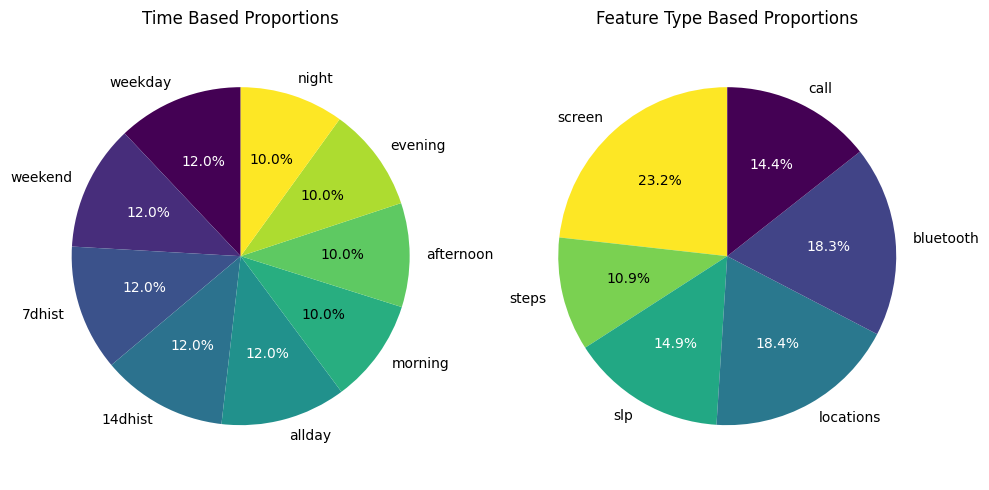

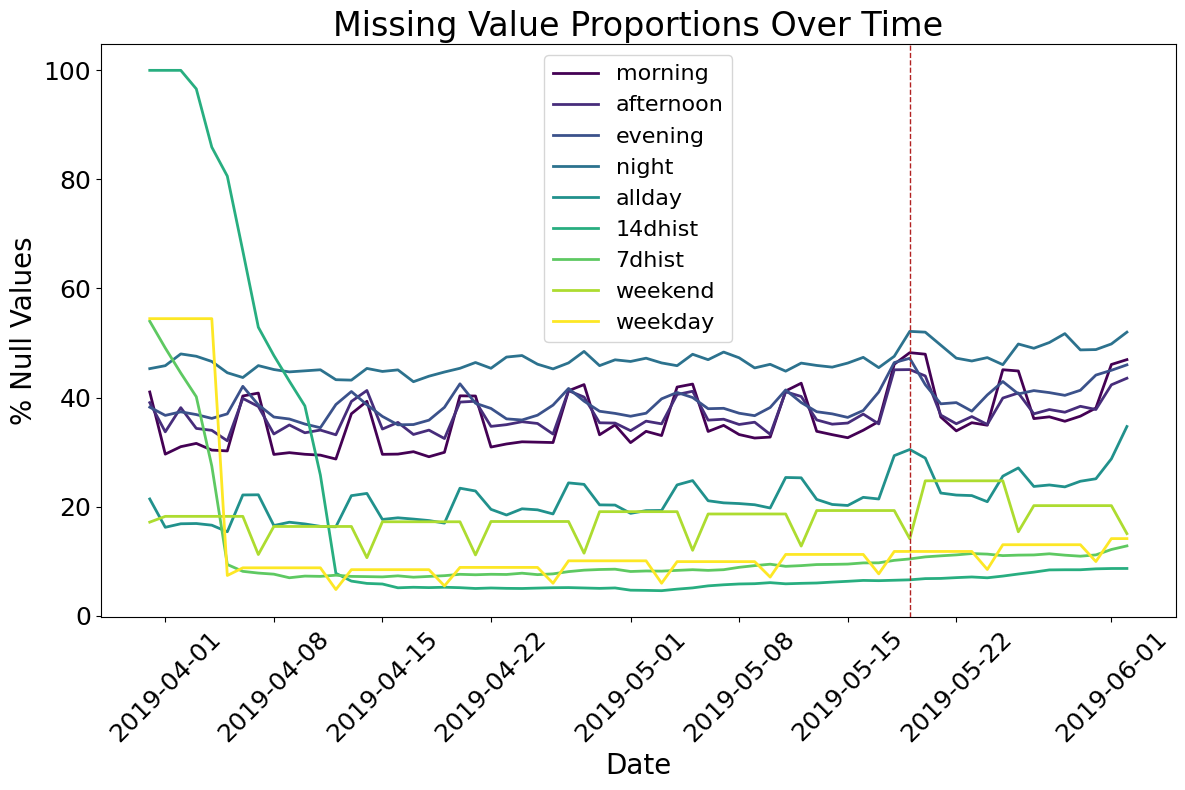

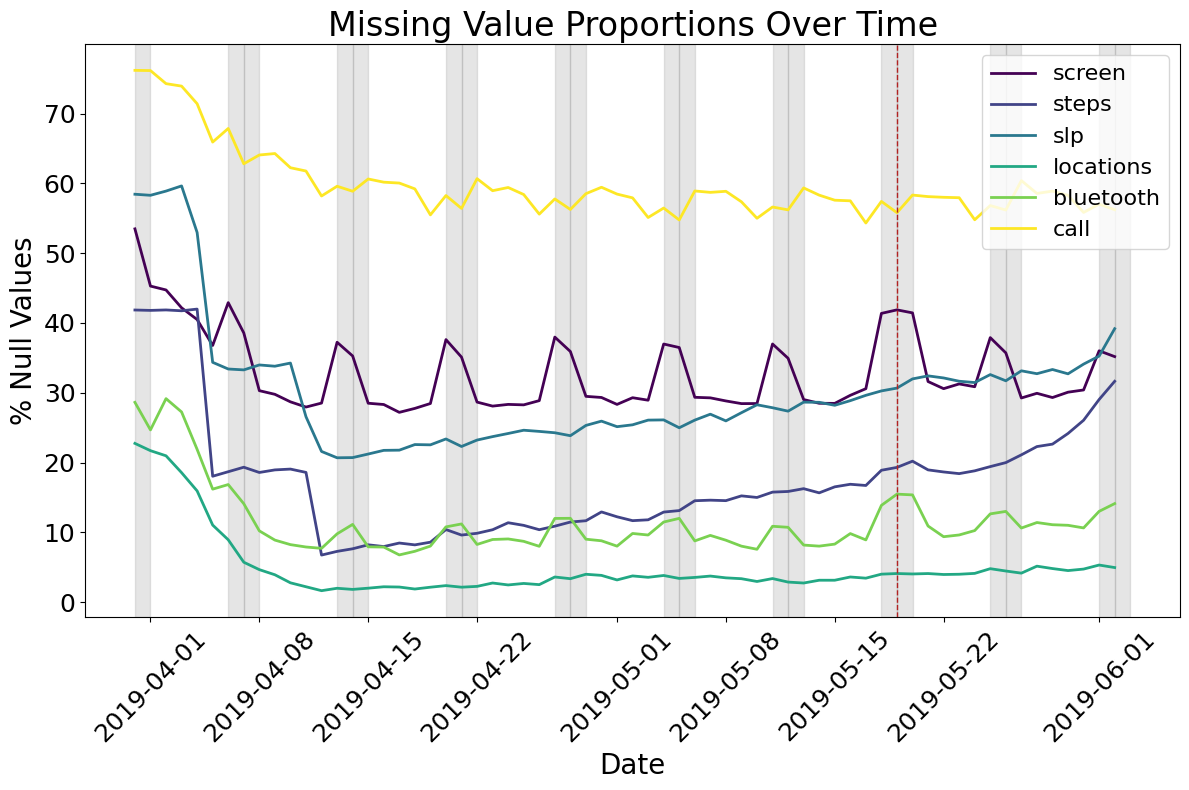

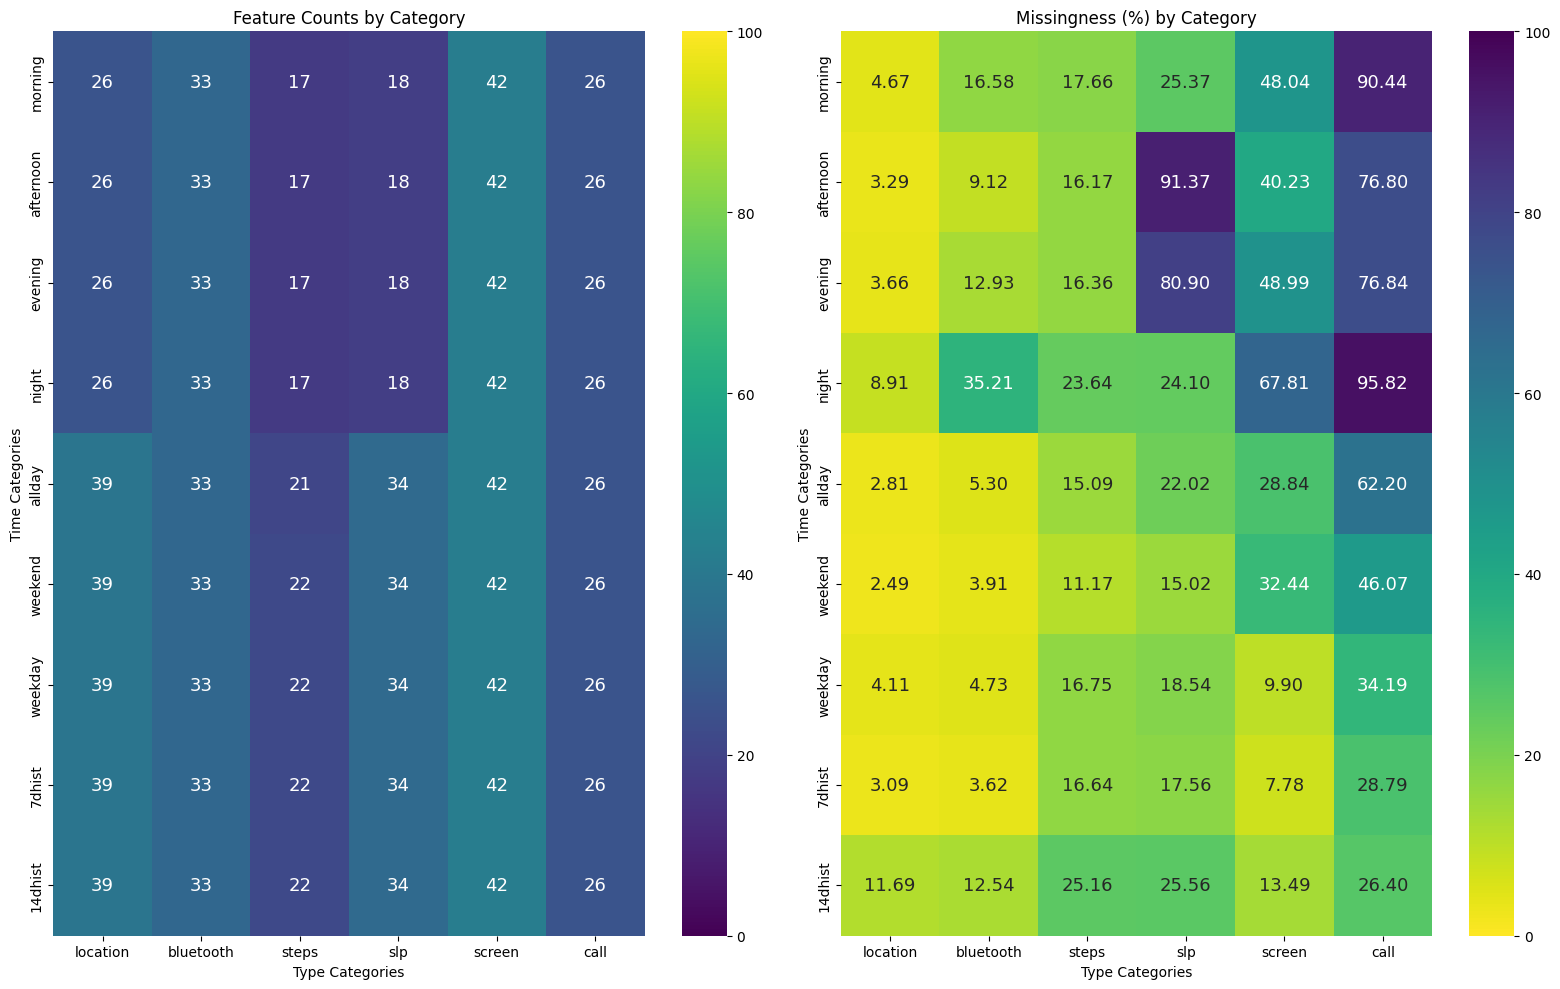

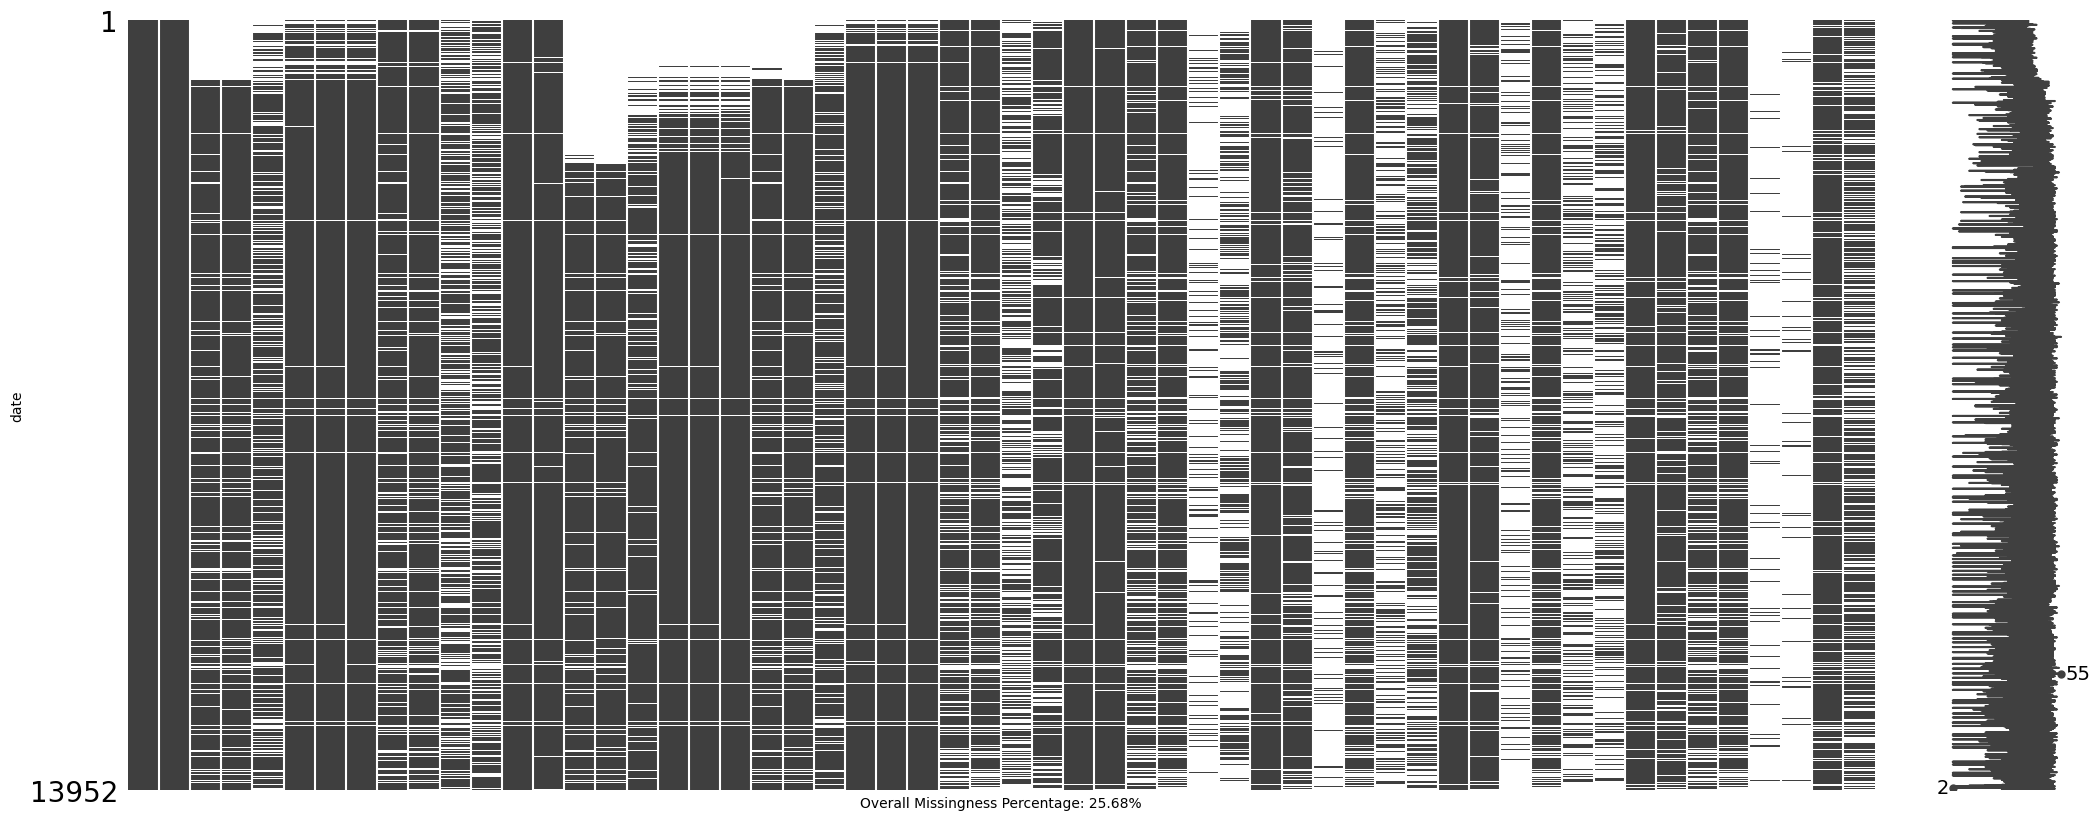

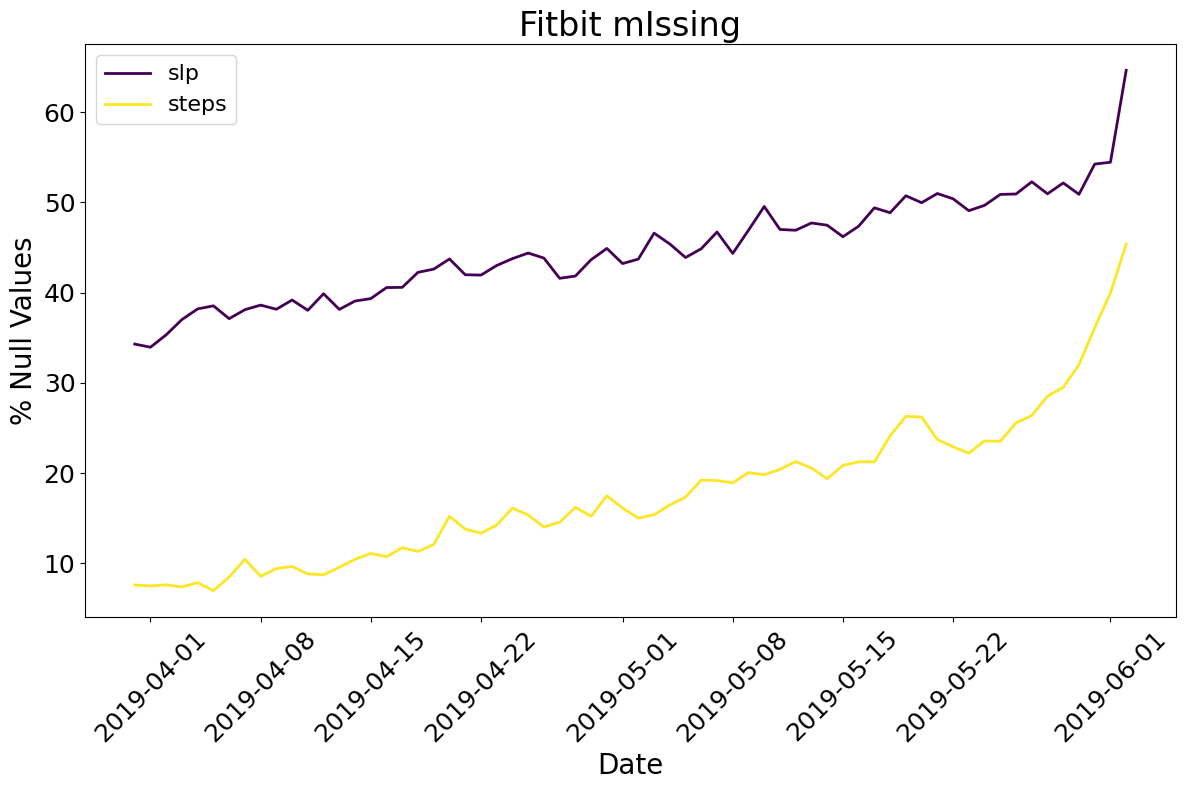

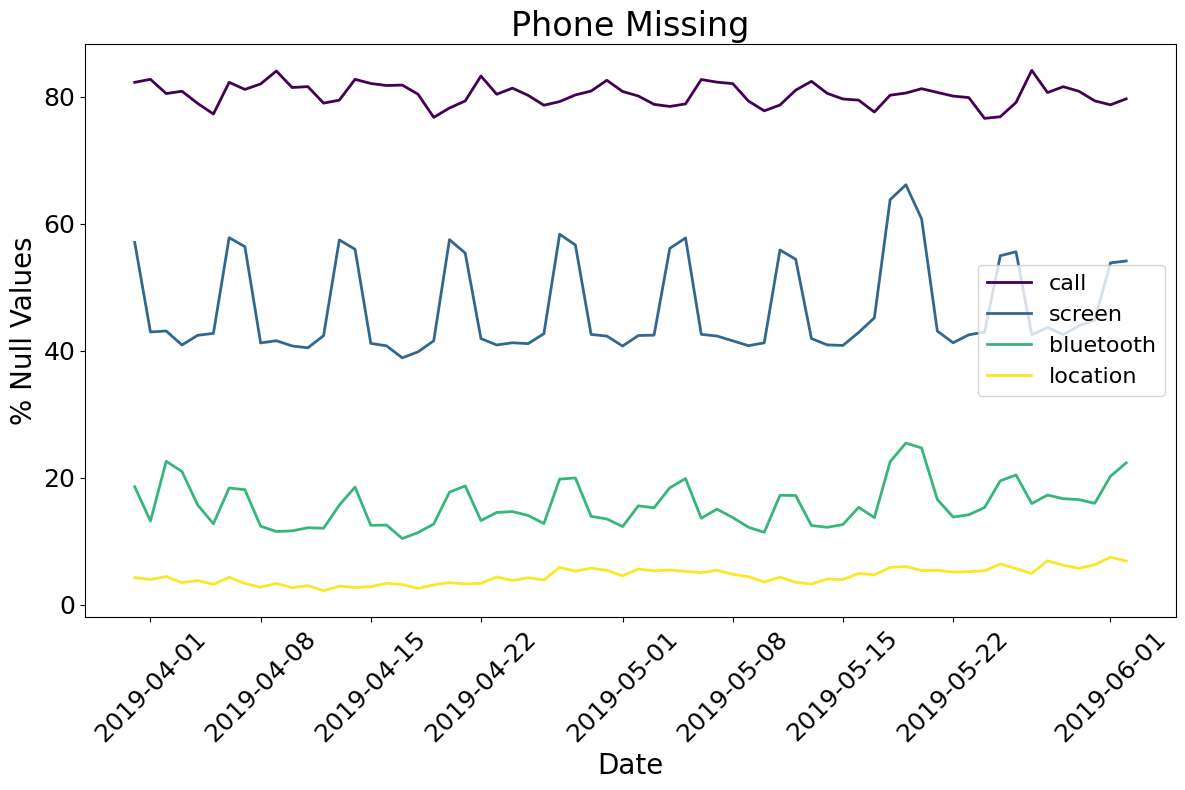

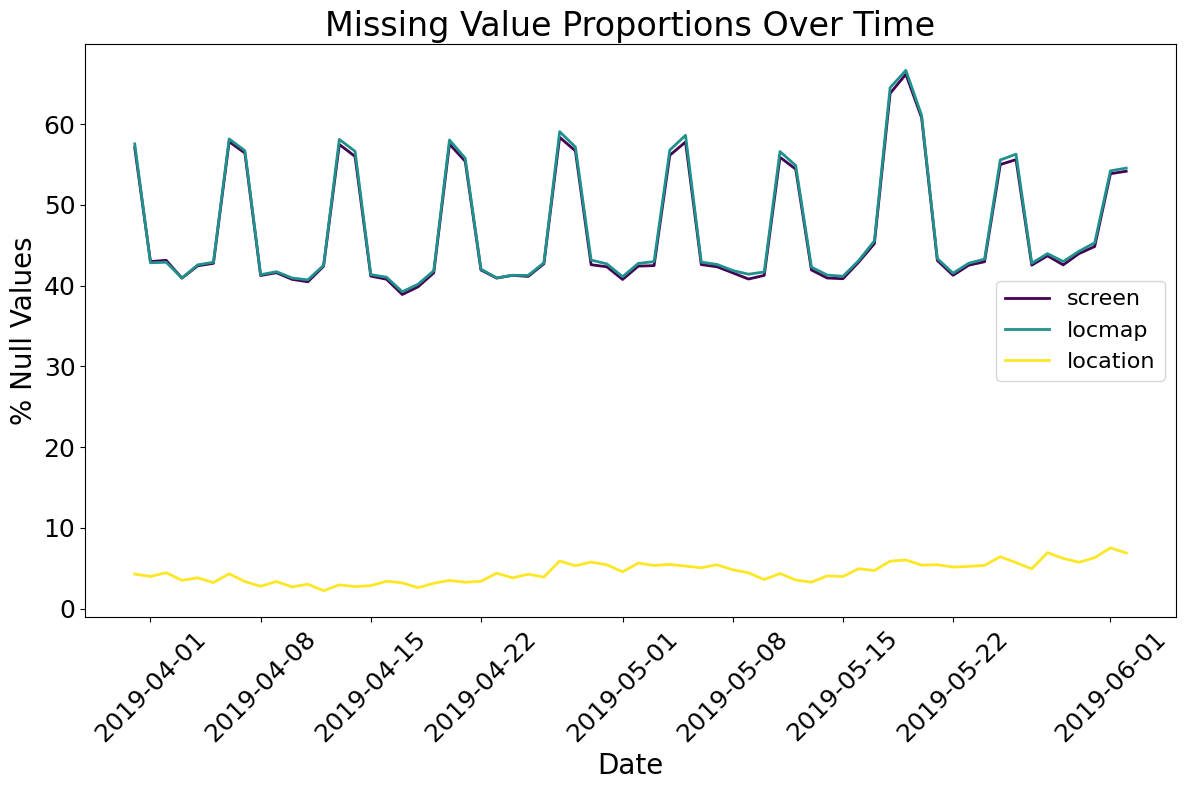

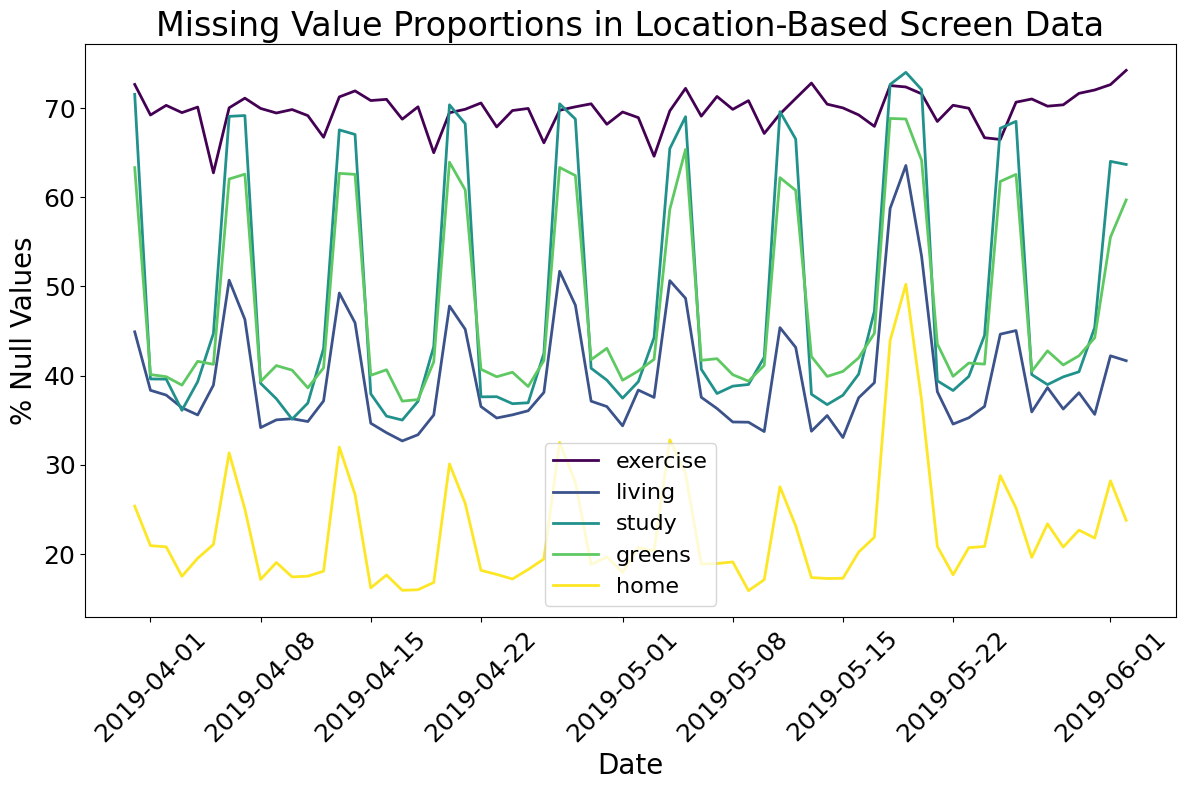

Shape before empty removal: (13952, 850)
Shape after empty removal: (13952, 850)
Total fitbit faulty rows: 1887
Total phone faulty rows: 362

=== Checking for Empty Daily Values After Null Adjustment ===
Total rows before drop: 13952
Total rows after drop: 13952
Total empty daily values after: 1558174
Percentage of empty daily values after: 13.2%
Shape: (13952, 1629)


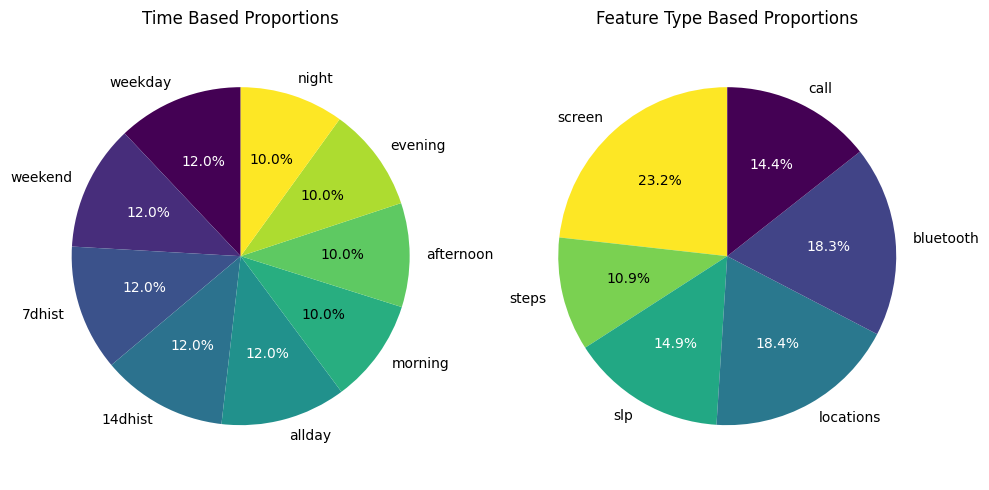

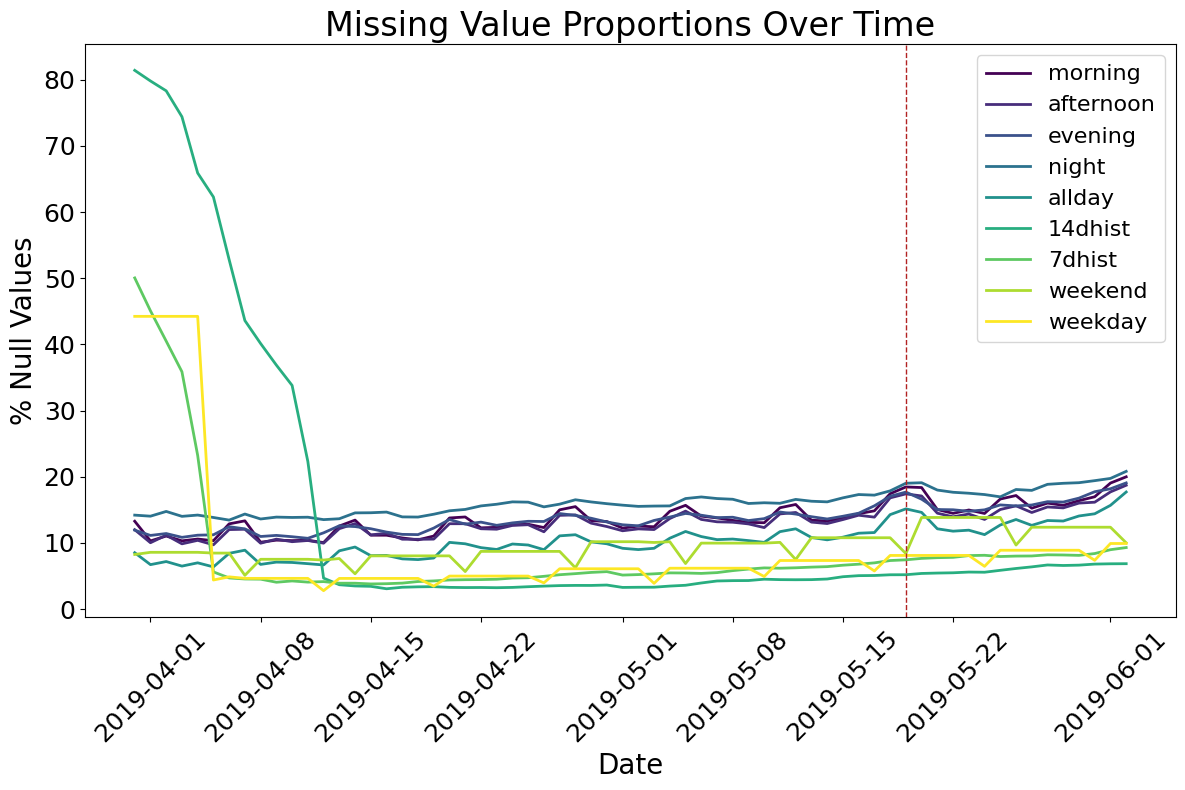

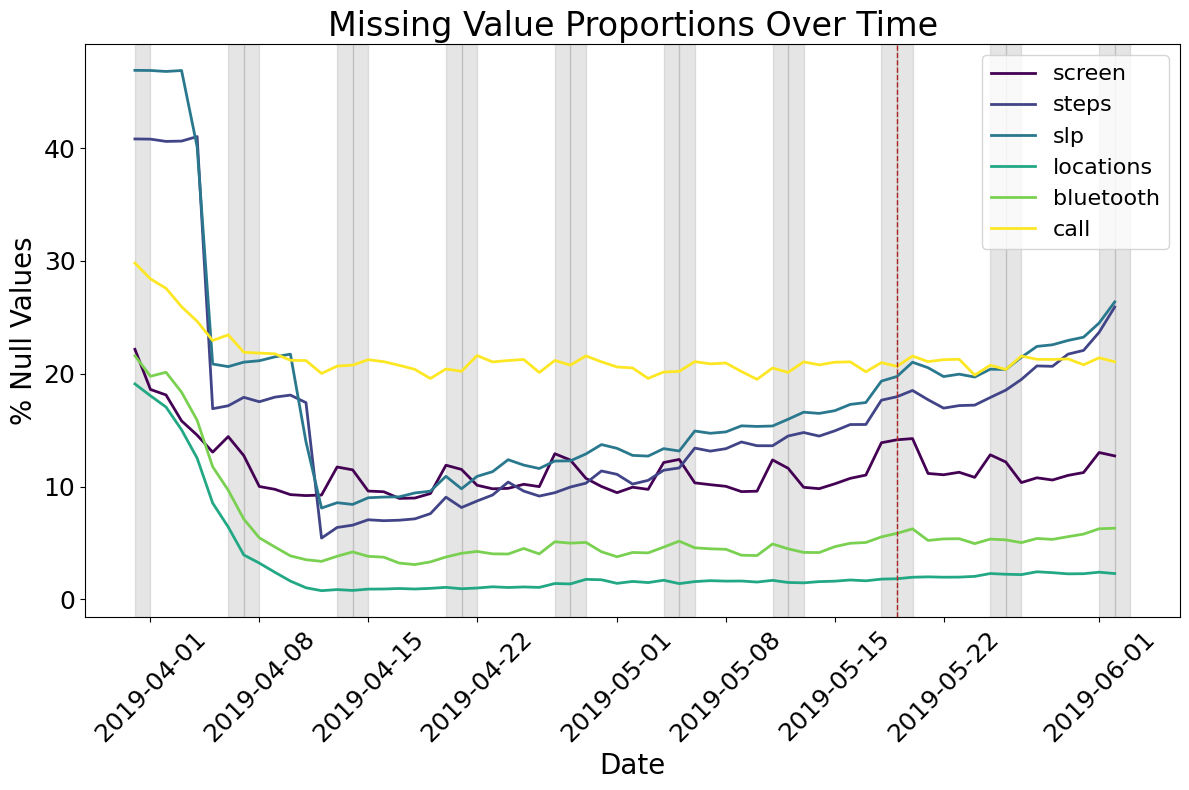

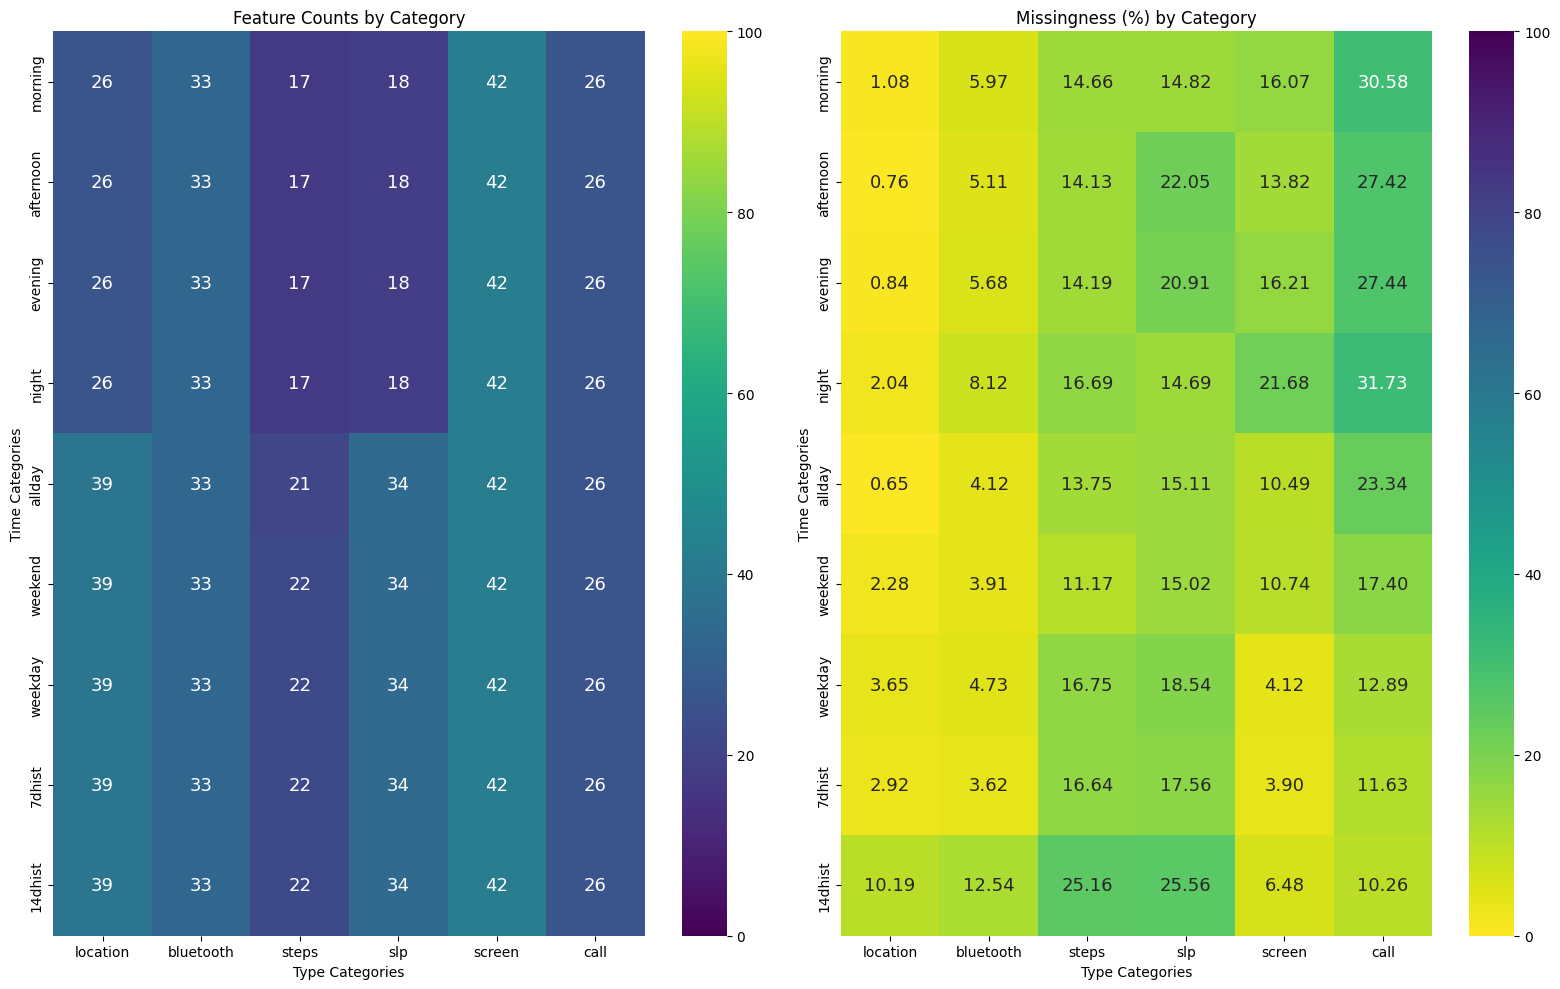

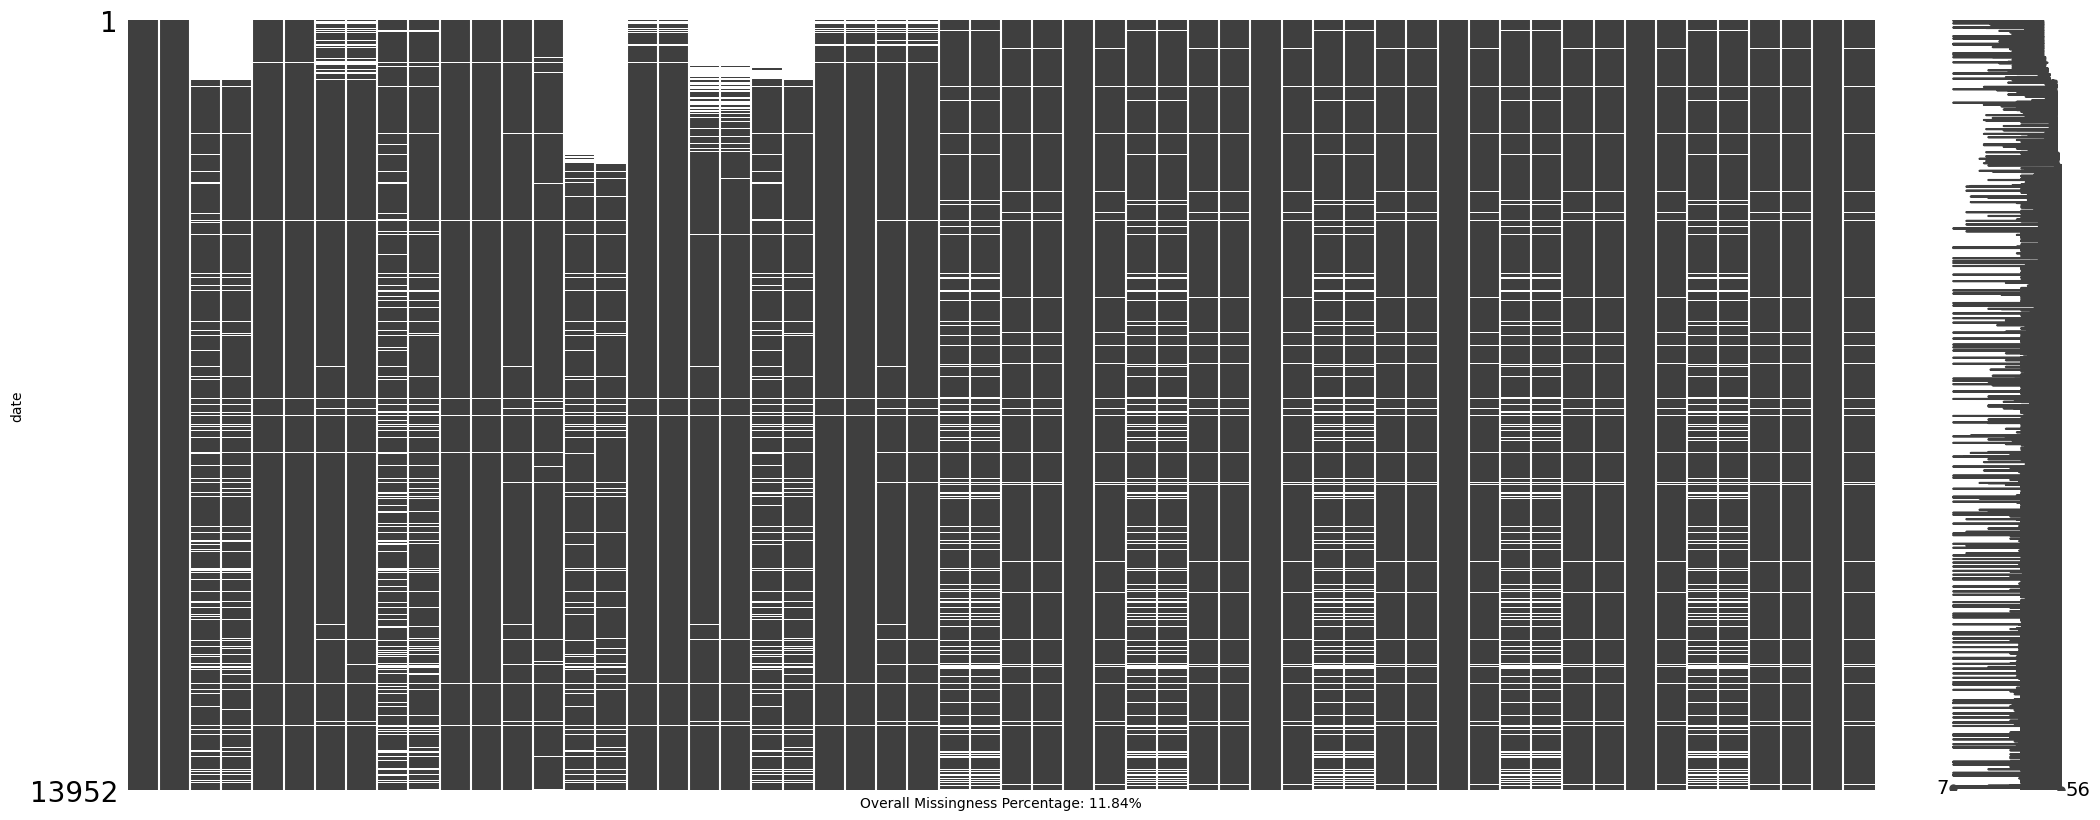

=== Row removal with 80.0% missingness threshold. === 

=== Participant removal with 30.0% missingness threshold. === 

Removed 10 participants (pids): ['INS-W_316', 'INS-W_361', 'INS-W_436', 'INS-W_460', 'INS-W_479', 'INS-W_527', 'INS-W_535', 'INS-W_536', 'INS-W_555', 'INS-W_556']
Shape before cleaning: (13820, 1629)
Shape after cleaning: (13304, 1629)
Shape: (13304, 1629)


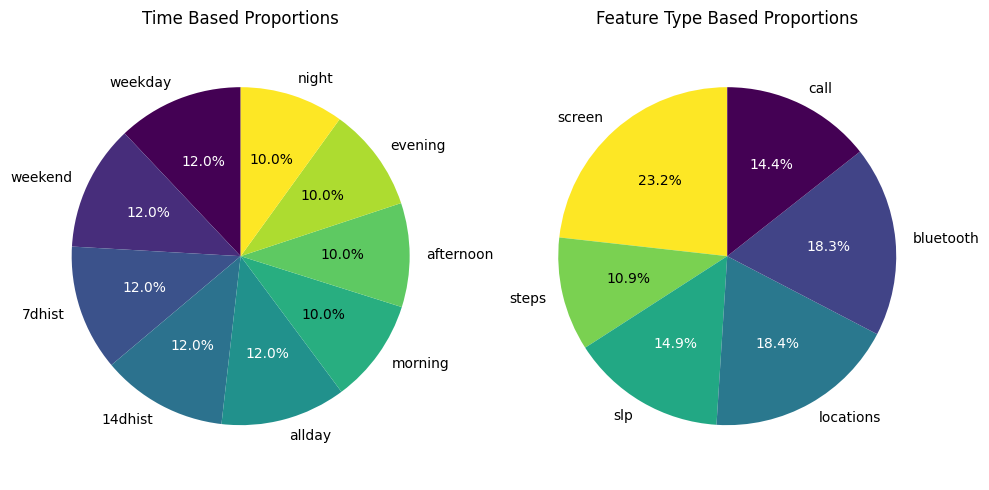

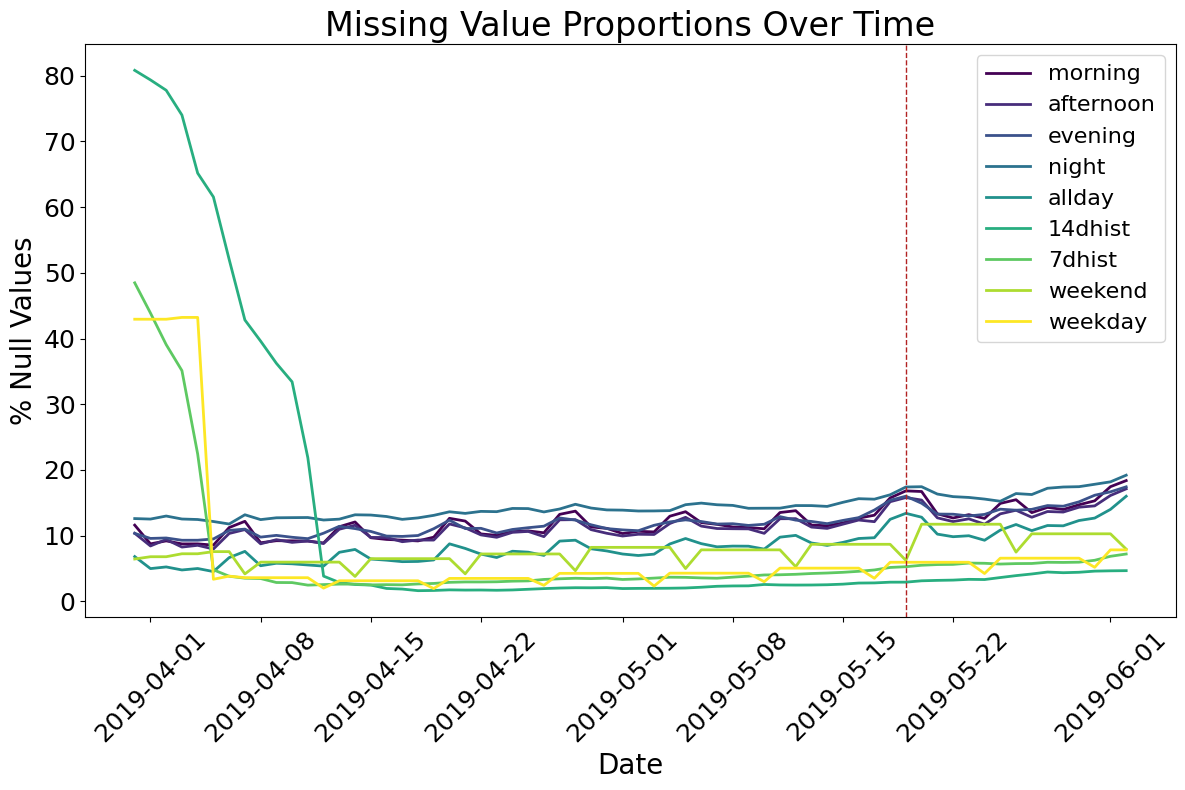

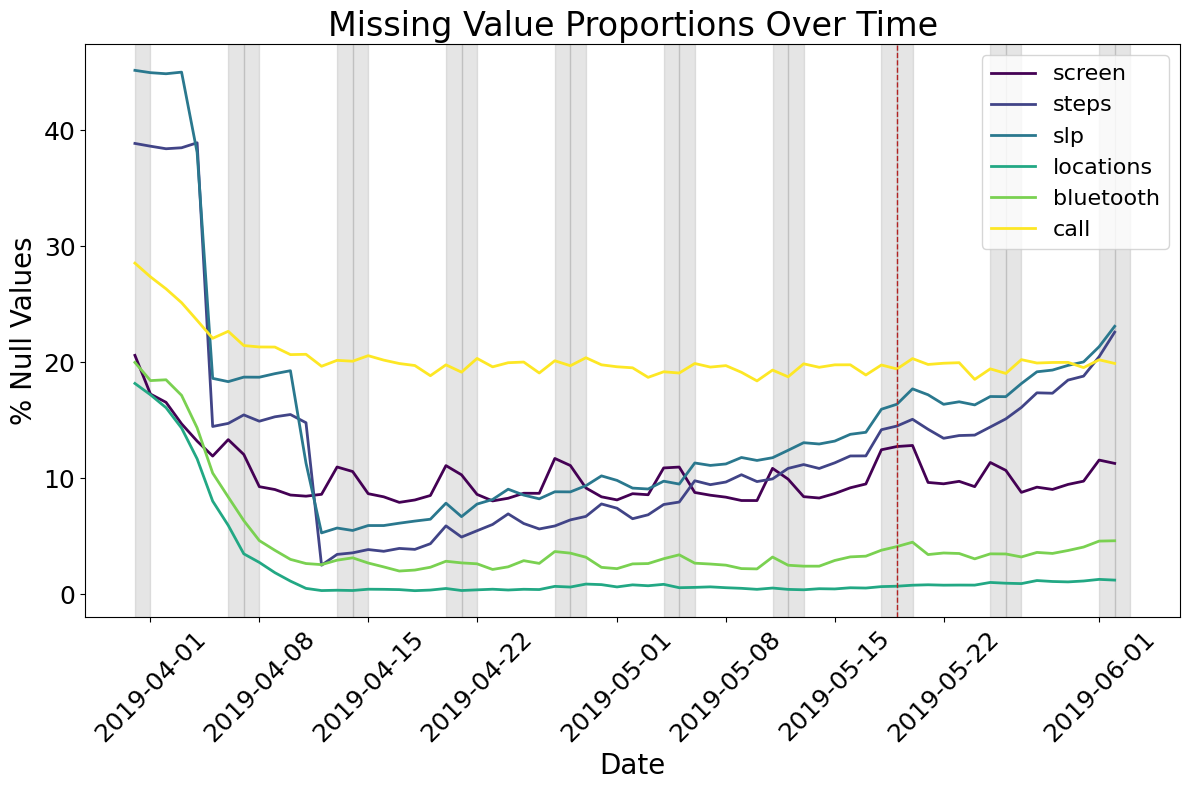

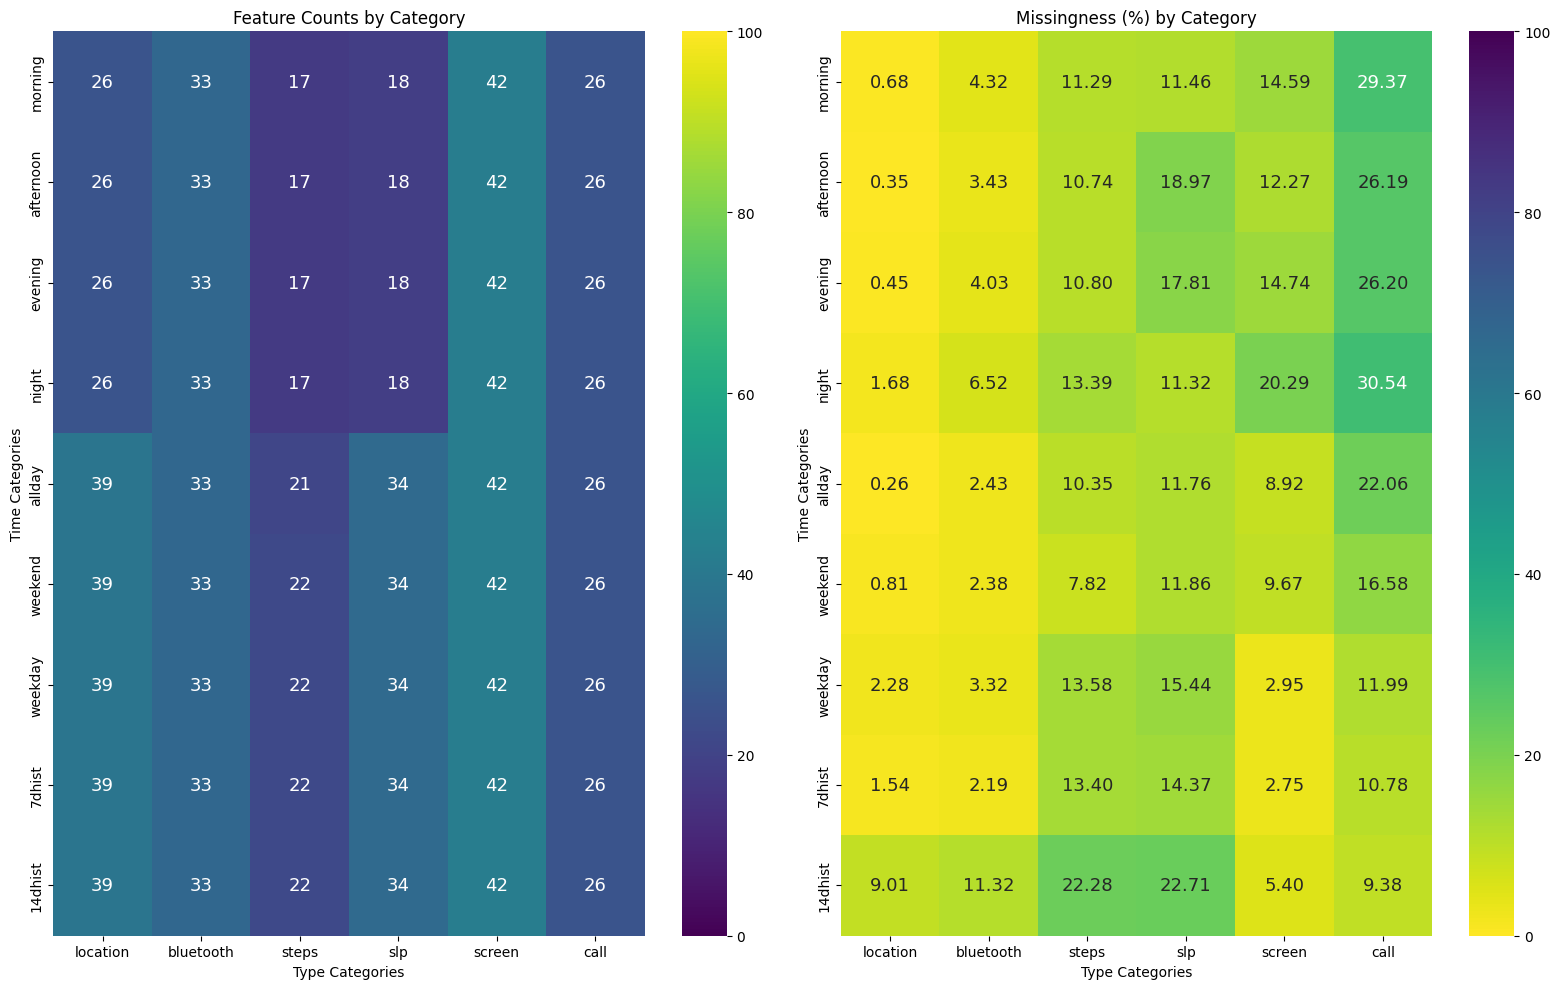

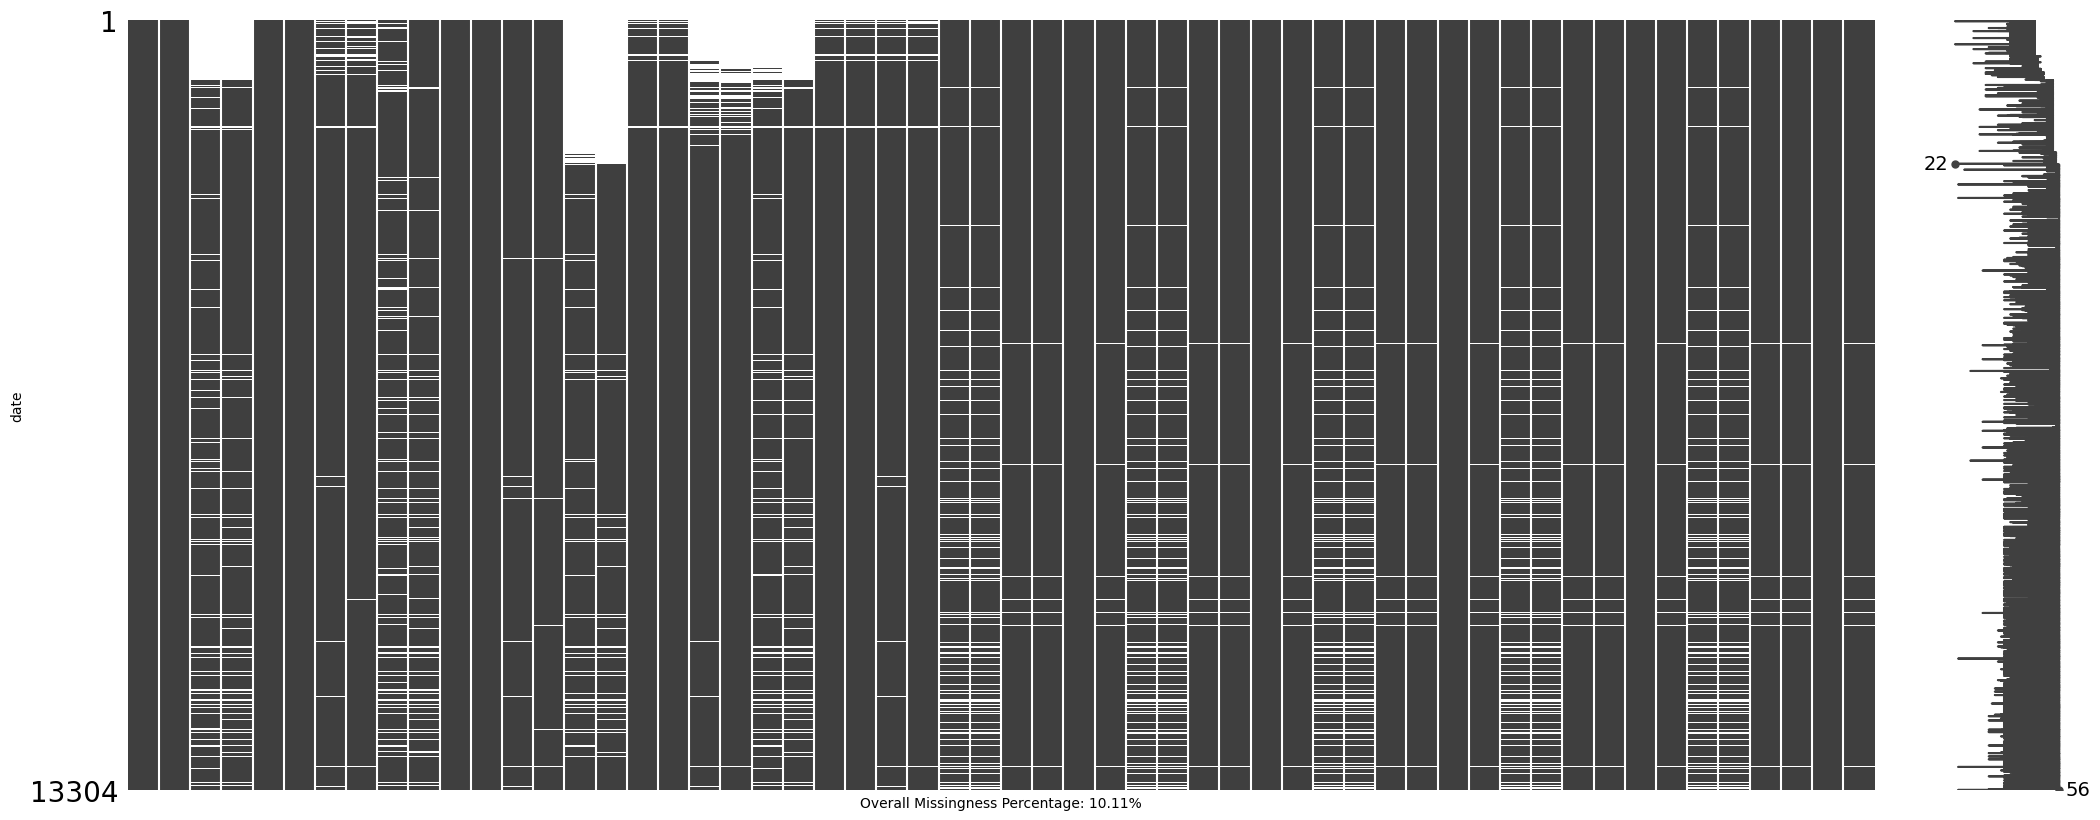


=== Starting participant-wise KNN imputation ===

Initially missing 2191030 values across 1627 features and 208 participants

=== Imputation Summary ===
Values imputed using participant KNN: 2191030
Remaining missing values: 0

=== After Removing Missing Labels ===
Total rows in dataset: 13057
Rows with missing phq4 depression: 0

=== Missing Data Analysis ===

Overall Summary:
Total participants: 208
Total missing days: 7
Total number of gaps: 1

Missing Data Statistics:
       missing_percentage  number_of_gaps  max_gap_size
count          208.000000      208.000000    208.000000
mean             0.052584        0.004808      0.038462
std              0.758379        0.069338      0.554700
min              0.000000        0.000000      0.000000
25%              0.000000        0.000000      0.000000
50%              0.000000        0.000000      0.000000
75%              0.000000        0.000000      0.000000
max             10.937500        1.000000      8.000000

Participants with

In [50]:
functions =  [weekly_ff_features, select_date_range, graphs, null_adjustment, graphs, remove_days_with_high_missingness, remove_pids_with_high_missingness, graphs, impute_by_participant, linearly_interpolate_labels, clean_dataset, verify_data_quality]

temp_df = features.copy()
for func in functions:
    temp_df = temp_df.pipe(func)
w_null_adjustment = temp_df


In [51]:
# model with null adjustment, all sections of variables, and correlation applied outside
model1 = train_regression_model(w_null_adjustment, 'phq4_depression_EMA', 50)


=== Starting Feature Selection Process ===

Initial split information:
Total participants: 208
Participants with sufficient data: 202
Initial training samples: 9796
Initial test samples: 3023

Final data split summary:
Training participants: 202
Test participants: 202
Training set shape: (9796, 1627)
Test set shape: (3023, 1627)
Training proportion: 0.76

Using 5 cross-validation splits

Starting hyperparameter tuning with time series cross-validation...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Selected features: ['f_slp:fitbit_sleep_intraday_rapids_ratiocountawakeunifiedwithinmain:afternoon', 'f_slp:fitbit_sleep_intraday_rapids_ratiodurationawakeunifiedwithinmain:afternoon', 'f_call:phone_calls_rapids_incoming_meanduration:afternoon', 'f_call:phone_calls_rapids_outgoing_minduration:afternoon', 'f_blue:phone_bluetooth_rapids_countscansmostuniquedevice:afternoon', 'f_screen:phone_screen_rapids_sumdurationunlock_locmap_living:afternoon', 'f_screen:phone_screen_rapids_

In [52]:
list(model1['selected_features']['feature'])

['f_screen:phone_screen_rapids_mindurationunlock_locmap_study:allday',
 'f_call:phone_calls_rapids_outgoing_minduration:afternoon',
 'f_loc:phone_locations_doryab_timeattop2location:afternoon',
 'f_call:phone_calls_rapids_incoming_entropyduration:morning',
 'f_slp:fitbit_sleep_intraday_rapids_stddurationasleepunifiedmain:allday',
 'f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:morning',
 'f_call:phone_calls_rapids_incoming_meanduration:evening',
 'f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout:evening',
 'f_screen:phone_screen_rapids_avgdurationunlock_locmap_living:evening',
 'f_screen:phone_screen_rapids_stddurationunlock_locmap_living:evening',
 'f_slp:fitbit_sleep_intraday_rapids_ratiodurationasleepunifiedwithinmain:evening',
 'f_screen:phone_screen_rapids_sumdurationunlock_locmap_greens:evening',
 'f_slp:fitbit_sleep_intraday_rapids_avgdurationasleepunifiedmain:morning',
 'f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain:morning',
 'f_sl

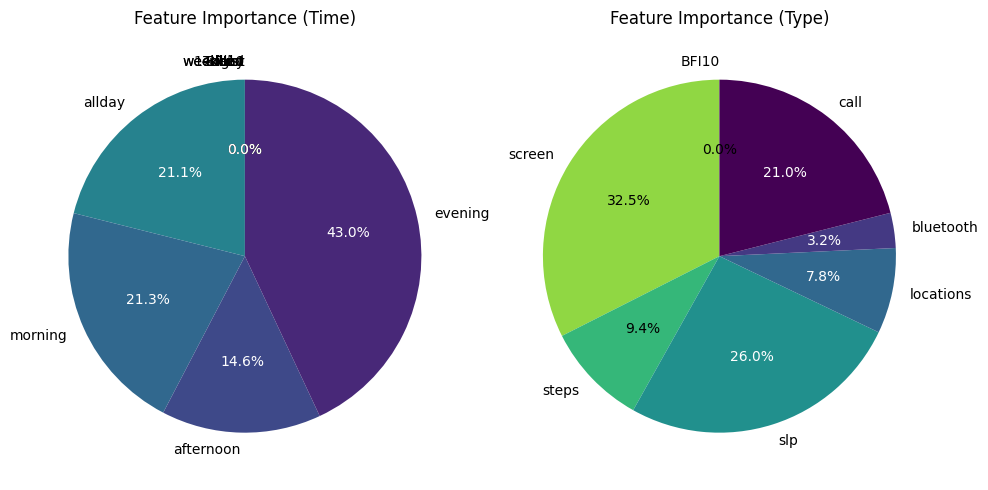

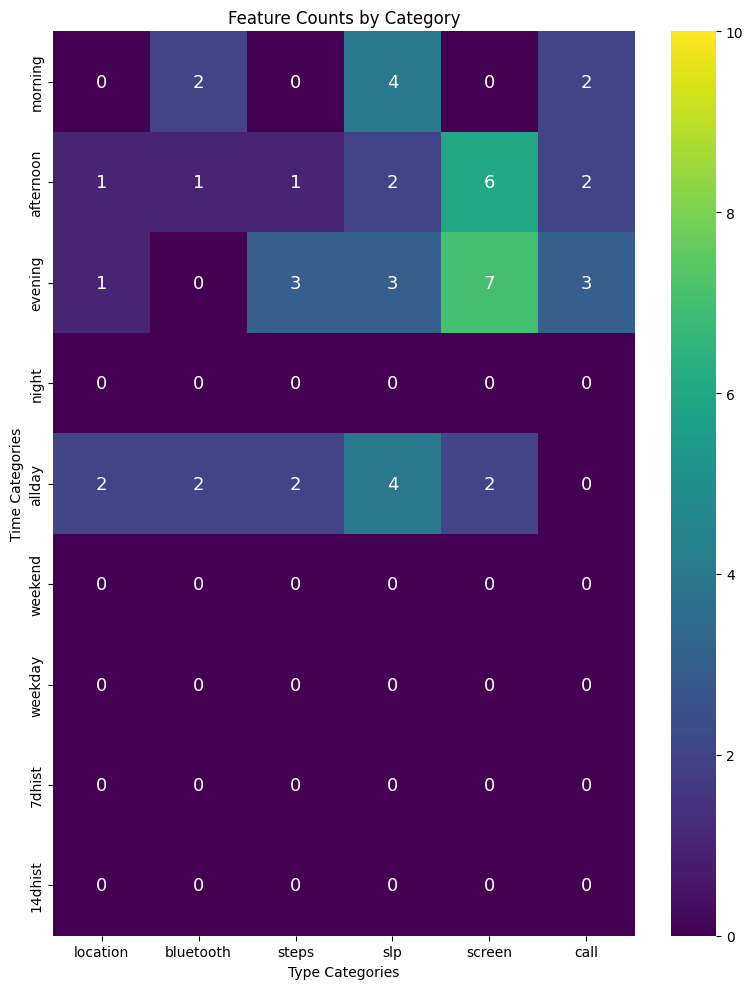

({'BFI10': 0,
  'weekday': 0,
  'weekend': 0,
  '7dhist': 0,
  '14dhist': 0,
  'allday': np.float64(0.21079043514673126),
  'morning': np.float64(0.2126432257301278),
  'afternoon': np.float64(0.14624492898887617),
  'evening': np.float64(0.43032141013426467),
  'night': 0},
 ['BFI10', 'screen', 'steps', 'slp', 'locations', 'bluetooth', 'call'])

In [53]:
categorise_feature_importance(model1['selected_features'])

### Remove highly missing features

=== Inital shape: (21146, 1629), with 218 participants === 

Missingness before week fill forward: 55.74%
Missingness after week fill forward: 42.09%
=== Selecting dates only between 2019-03-31 00:00:00 and 2019-06-02 00:00:00 ===
Missingness before date filtering: 42.09%
Missingness after date filtering: 25.68%
Shape: (13952, 1629)


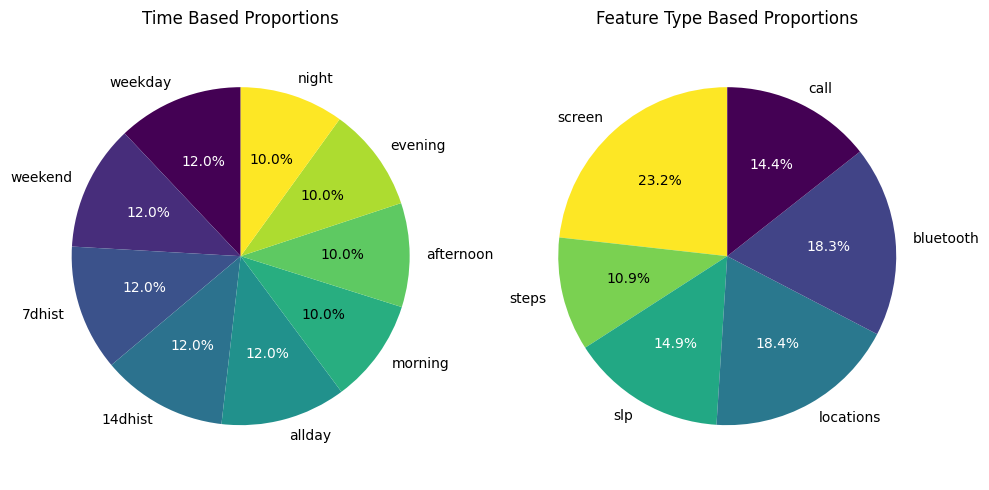

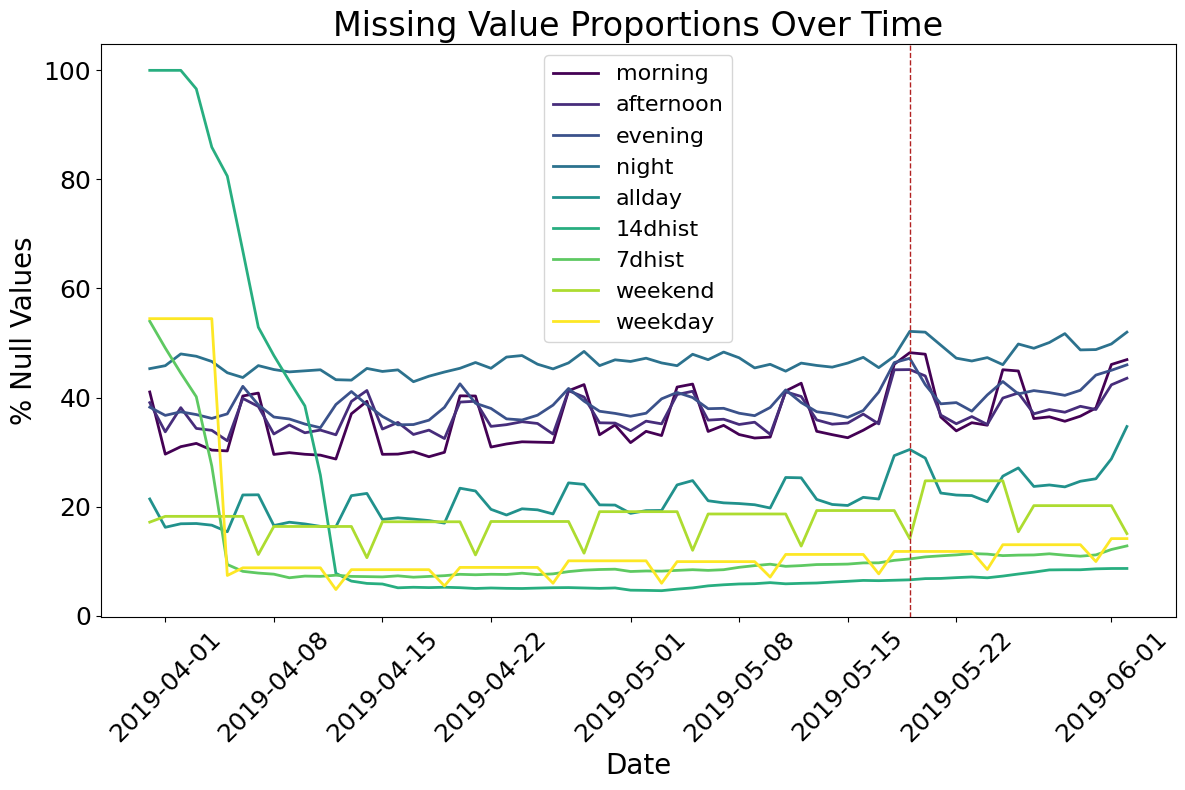

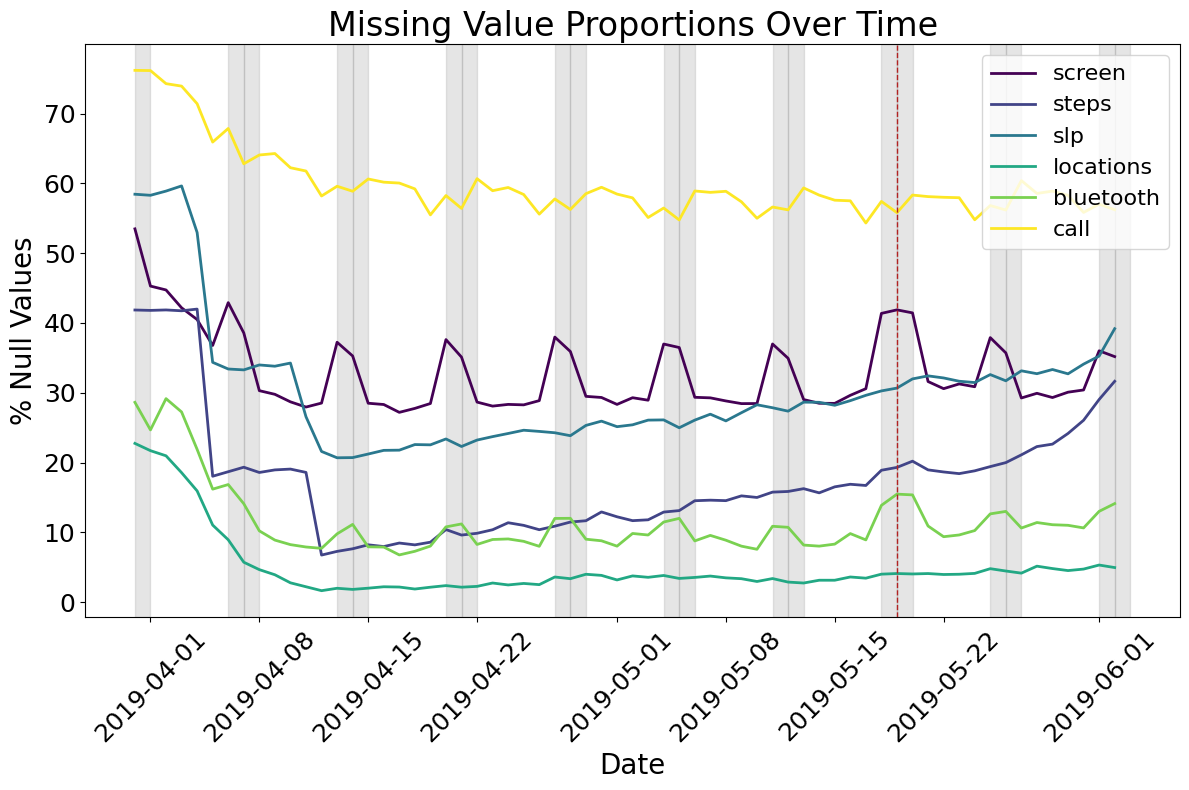

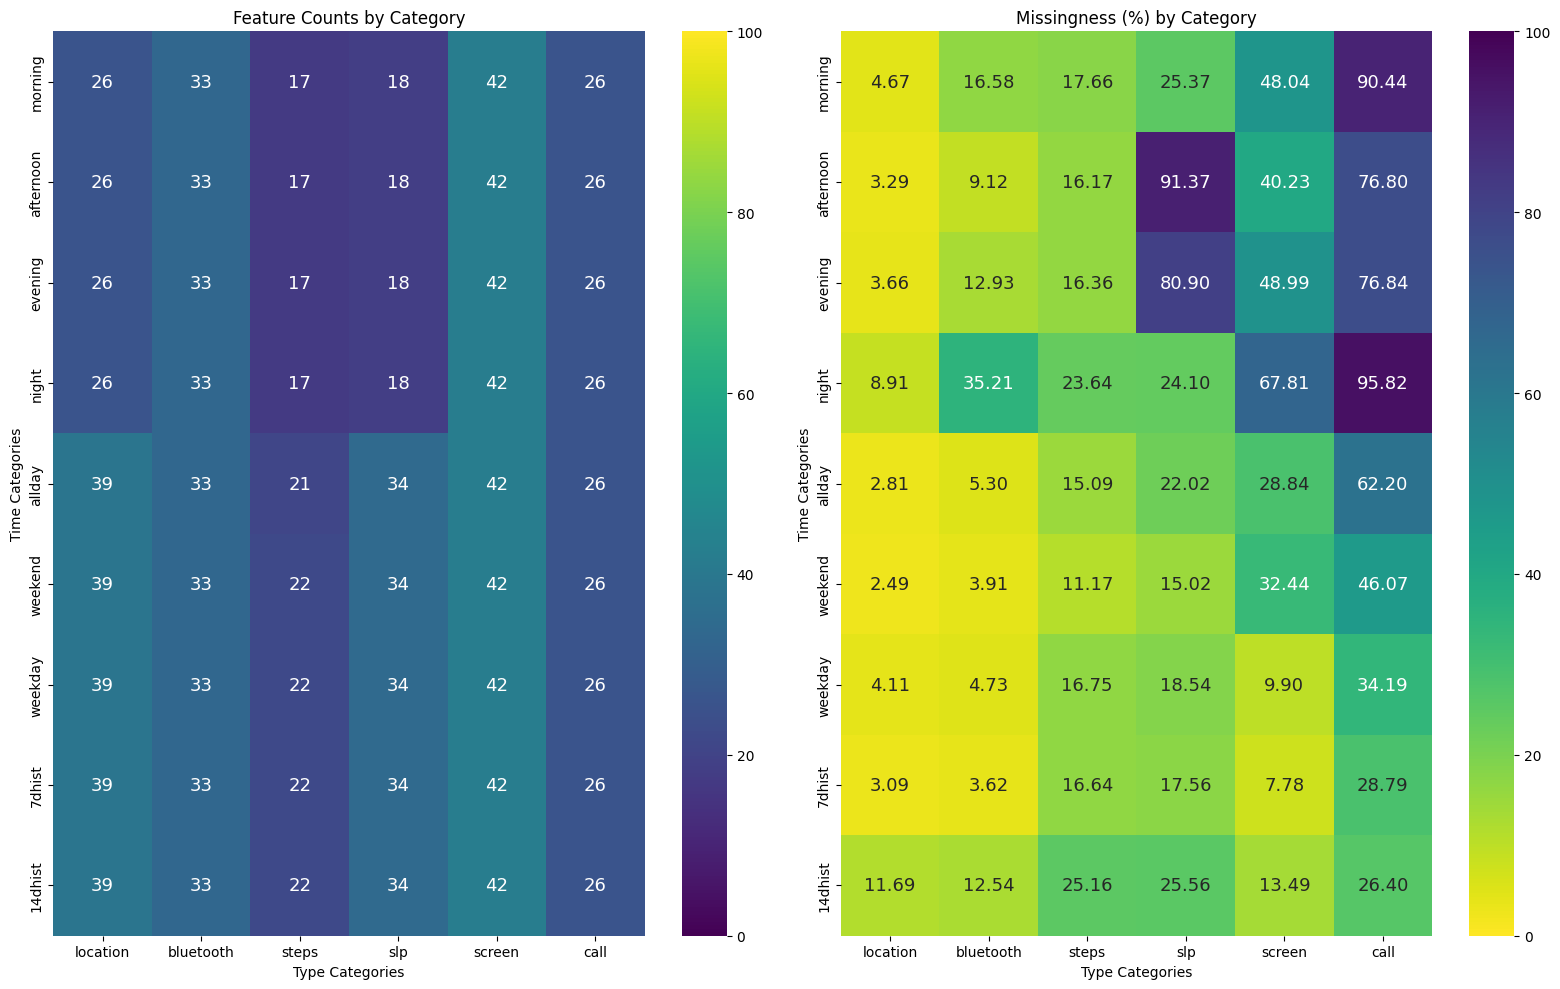

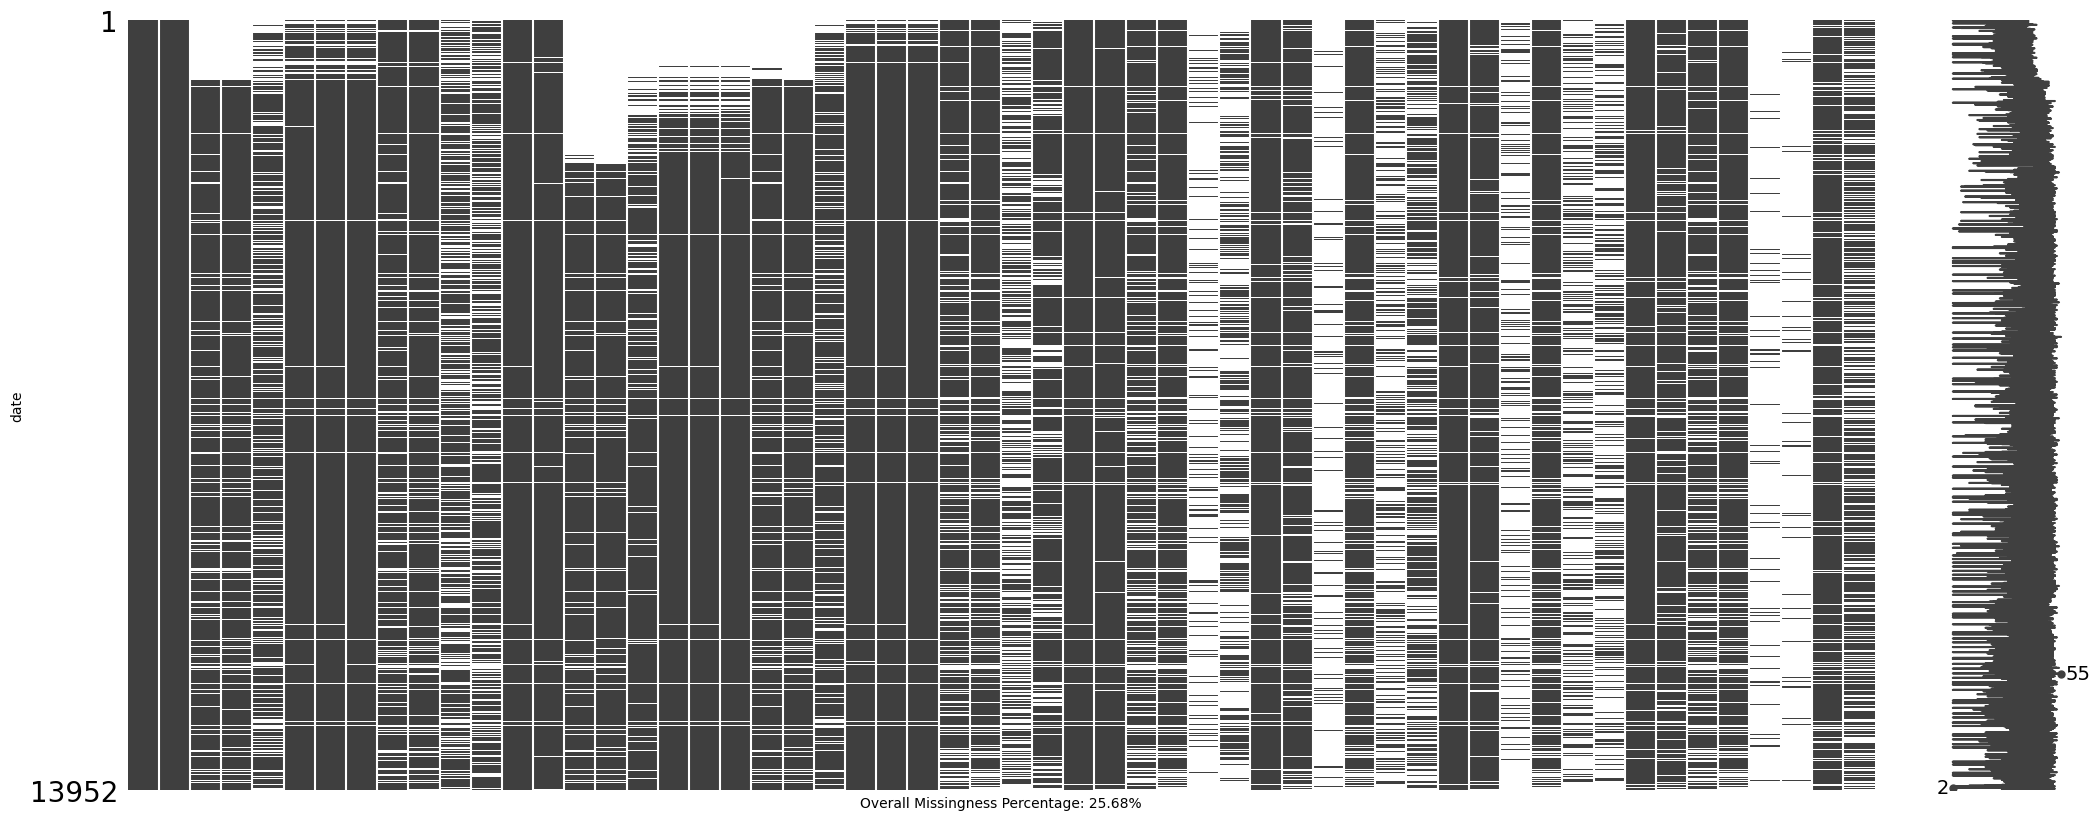


=== Missing Data Removal Summary ===
Original shape: (13952, 1629)
Final shape: (13952, 1360)
Participants removed: 0 (0.0%)

Features removed: 269 (16.5%)

=== Missingness After Cleaning ===
Average feature missingness: 15.0%
Average participant missingness: 15.0%
Shape: (13952, 1360)


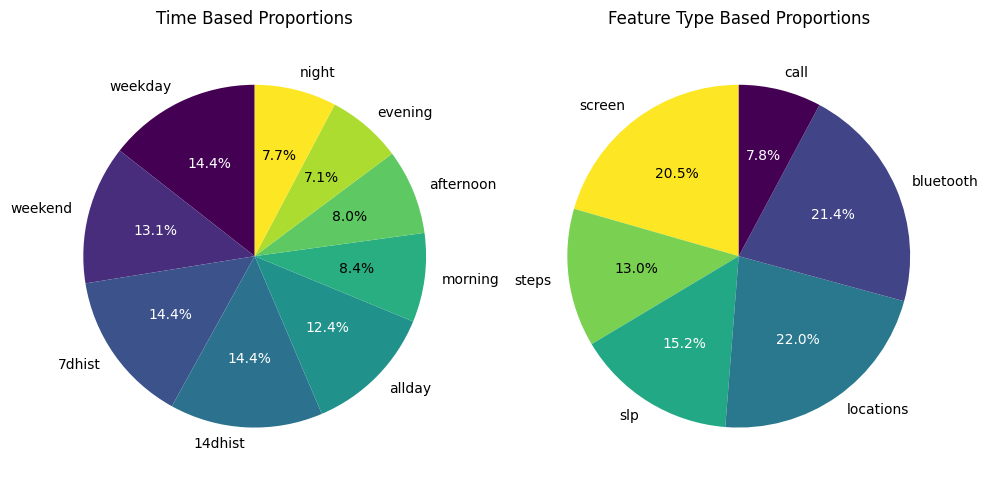

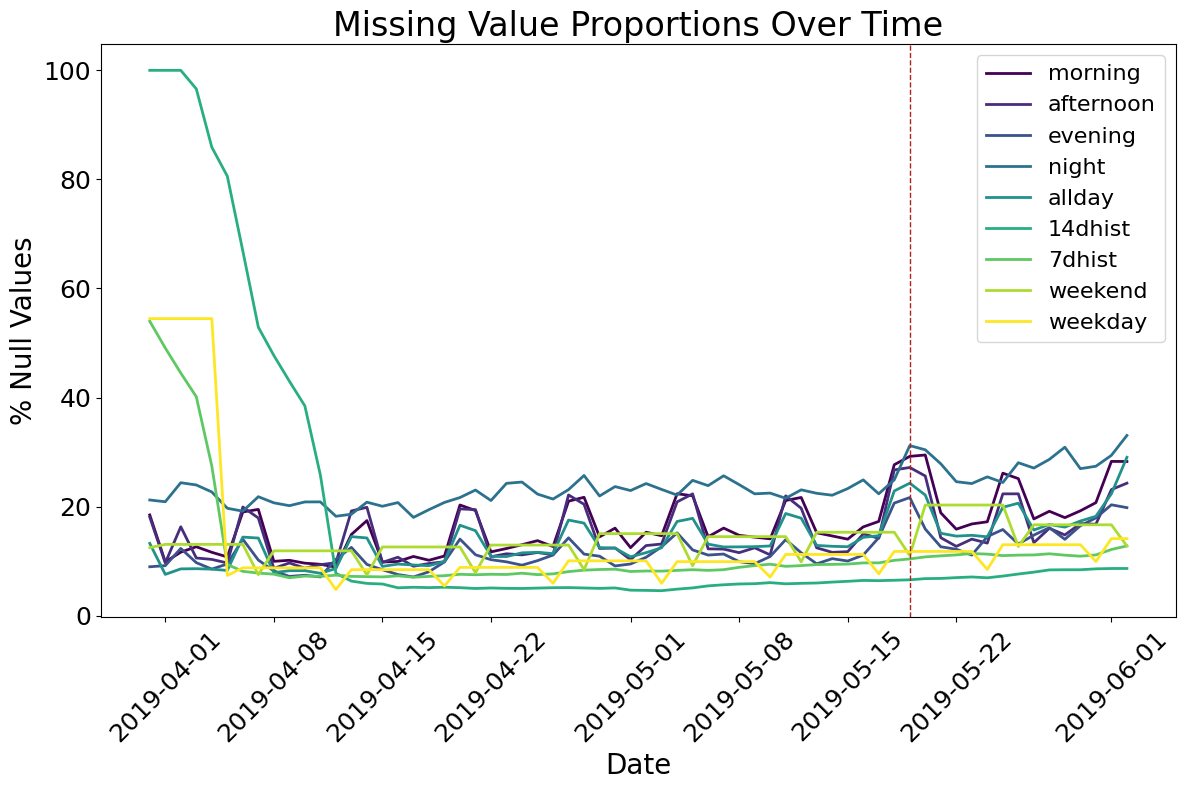

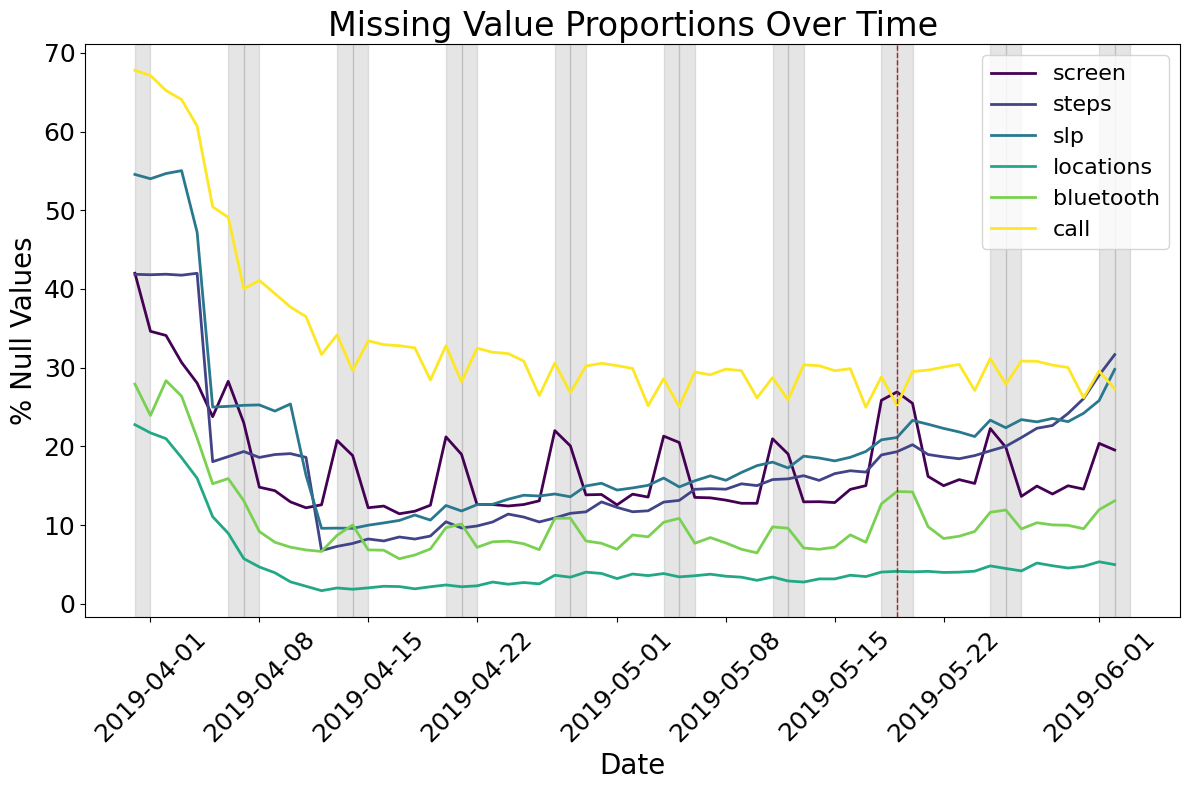

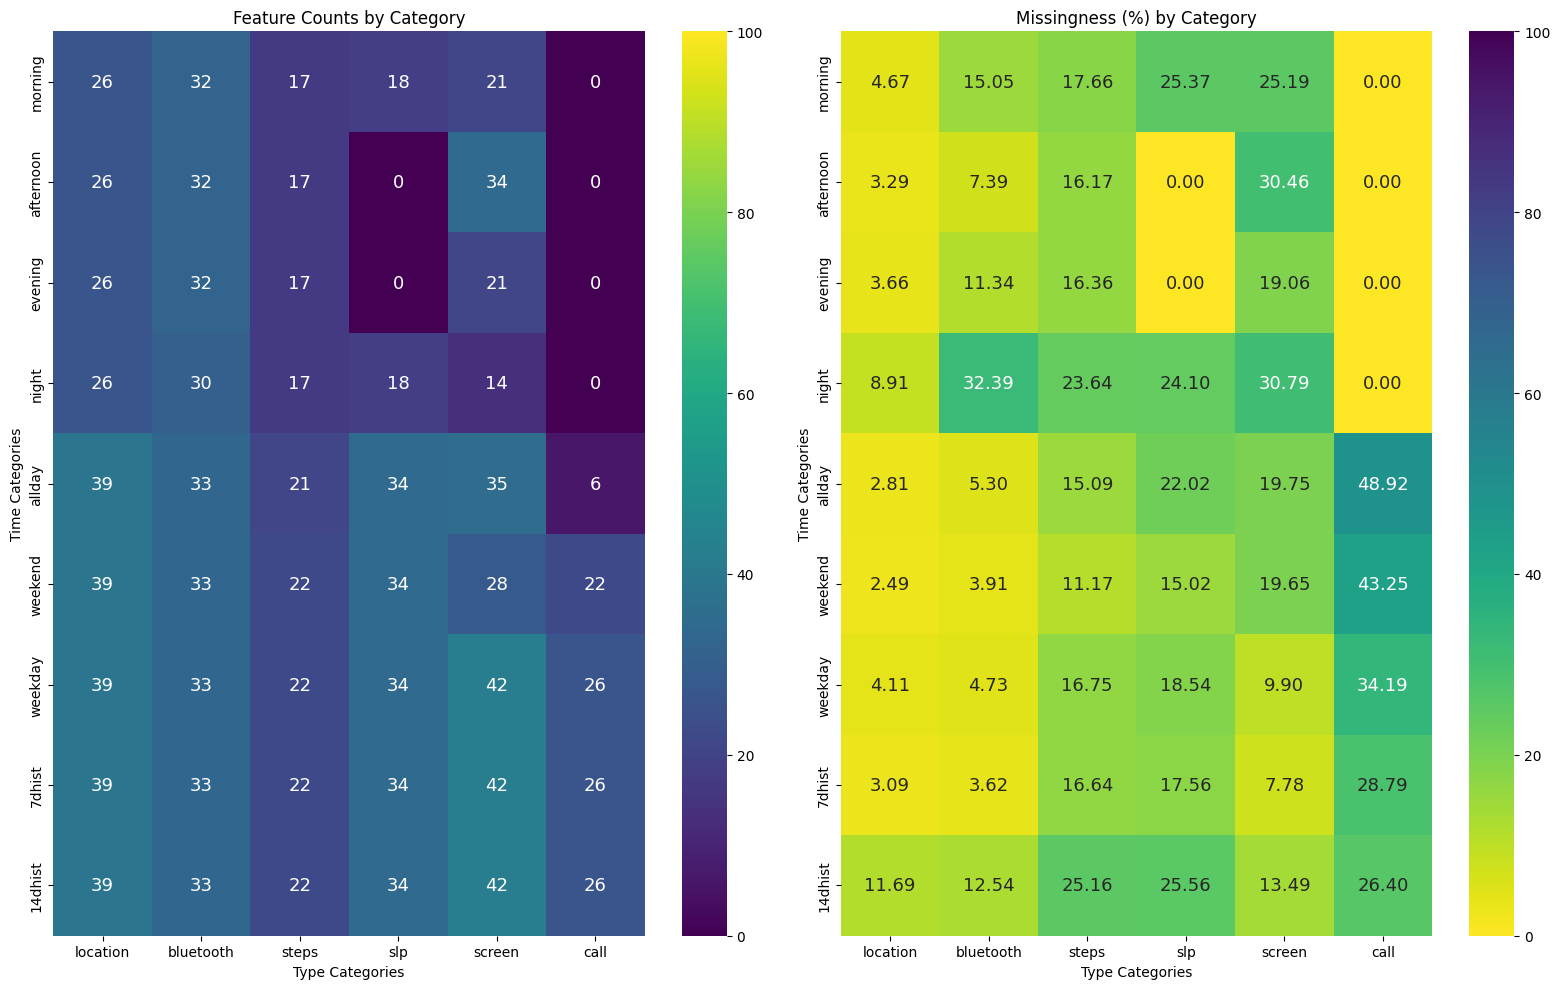

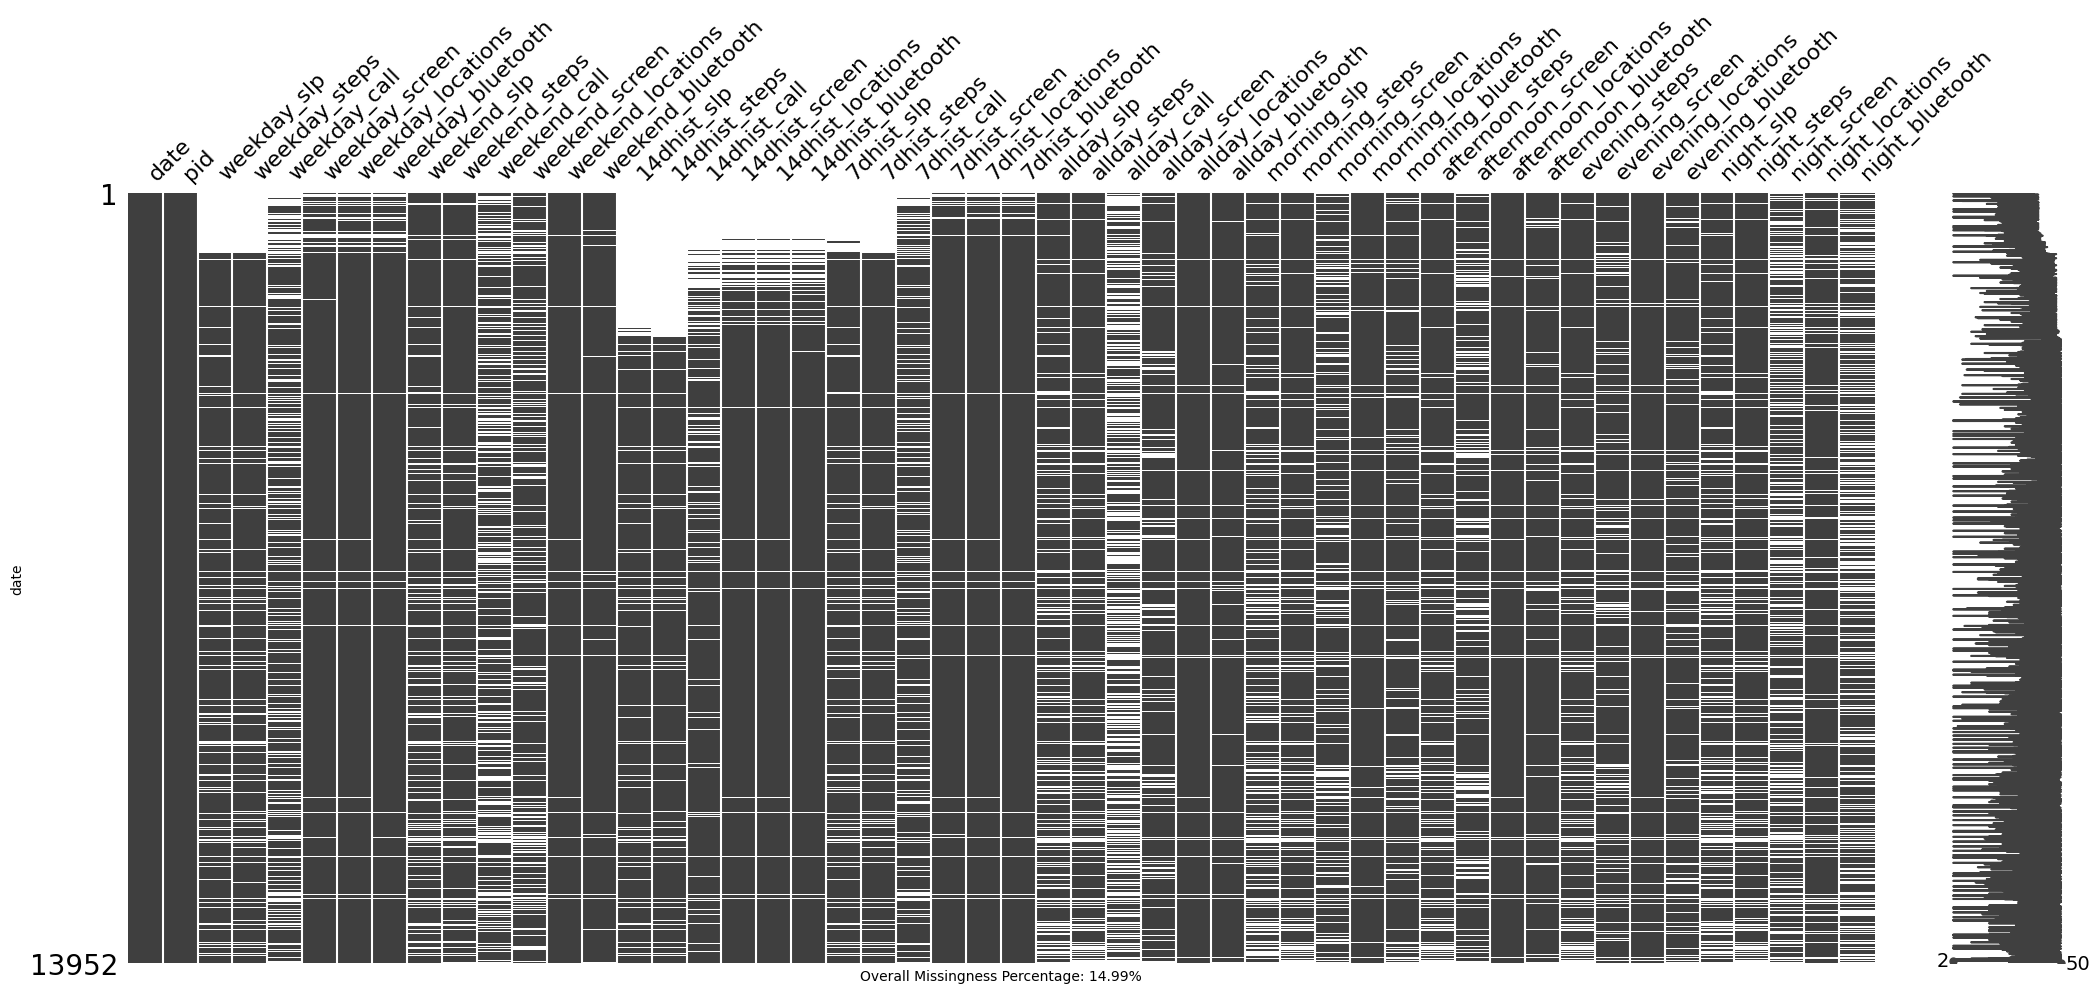

=== Row removal with 80.0% missingness threshold. === 

=== Participant removal with 30.0% missingness threshold. === 

Removed 14 participants (pids): ['INS-W_316', 'INS-W_361', 'INS-W_436', 'INS-W_460', 'INS-W_479', 'INS-W_485', 'INS-W_493', 'INS-W_502', 'INS-W_527', 'INS-W_535', 'INS-W_536', 'INS-W_555', 'INS-W_556', 'INS-W_569']
Shape before cleaning: (13806, 1360)
Shape after cleaning: (13045, 1360)
Shape: (13045, 1360)


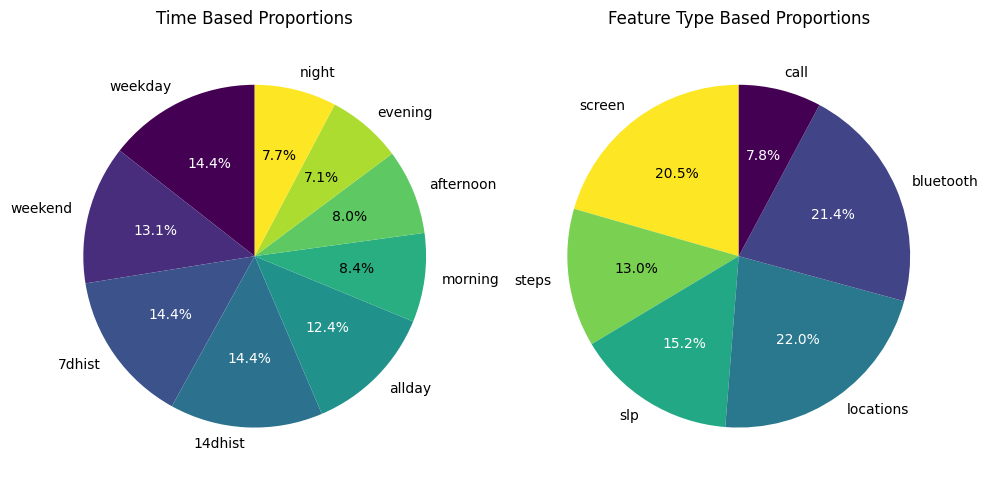

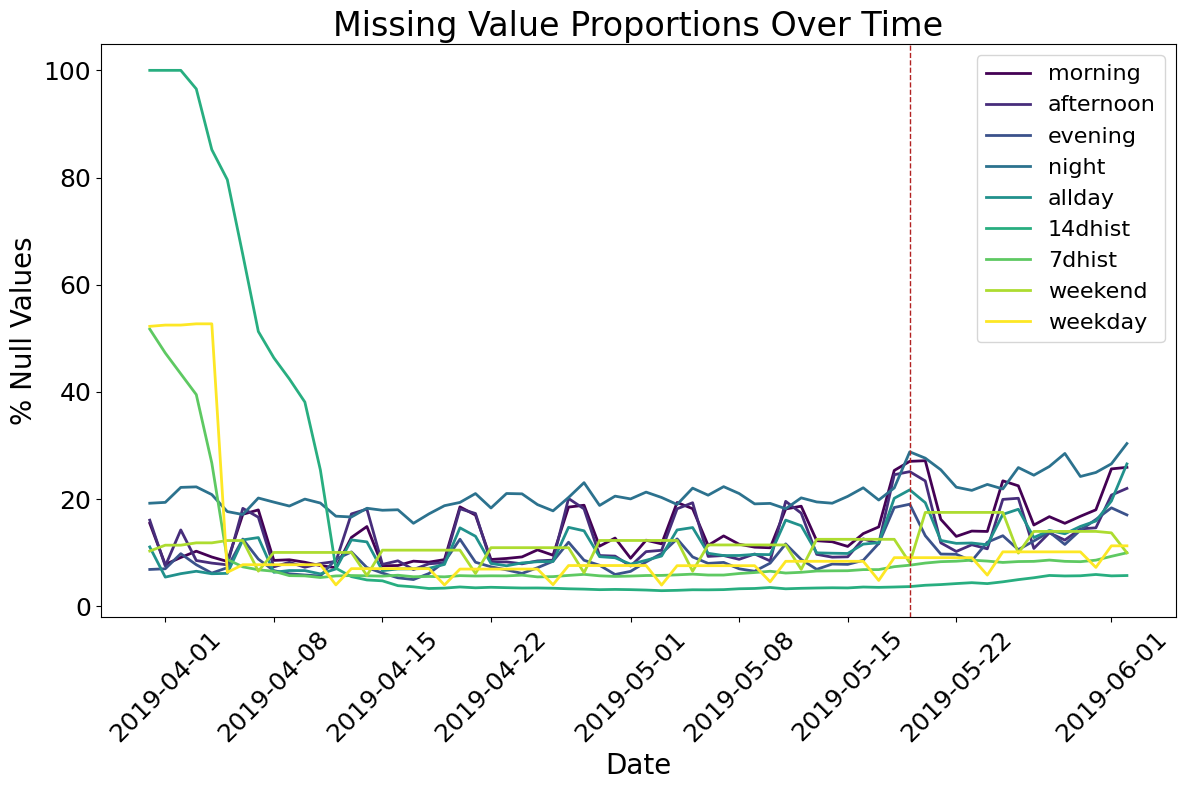

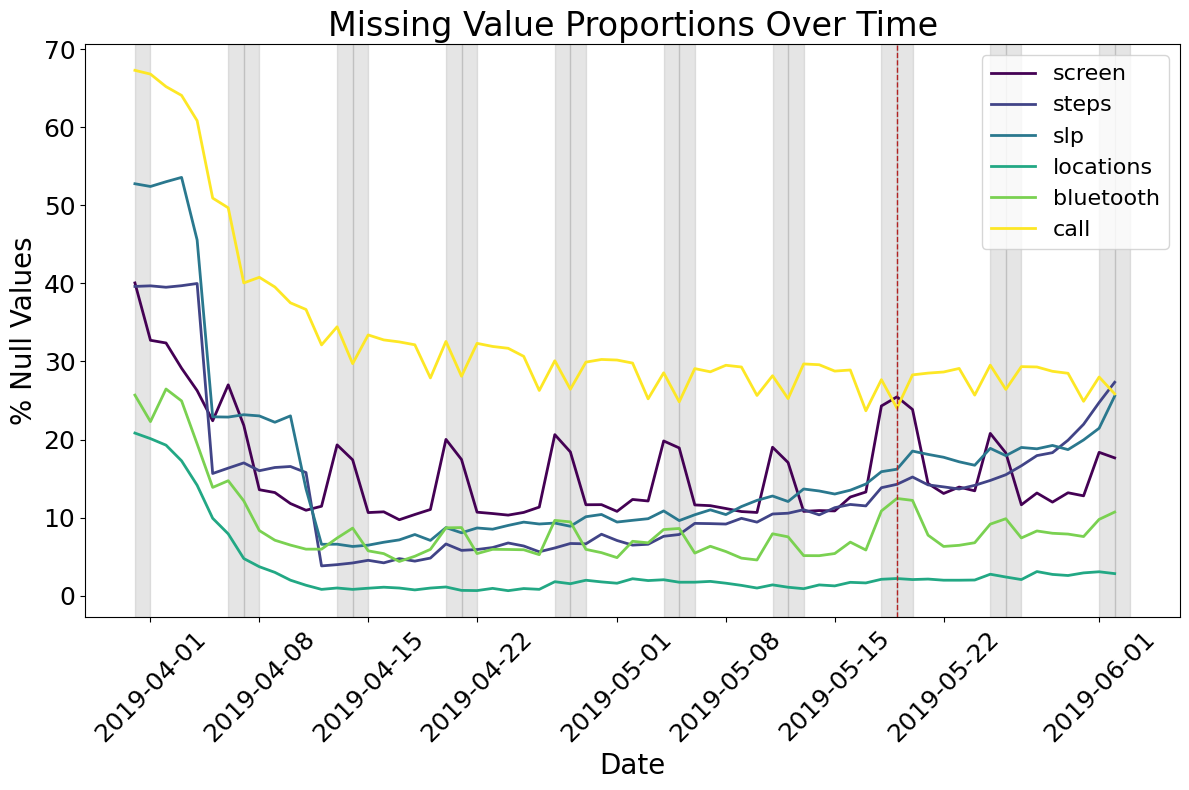

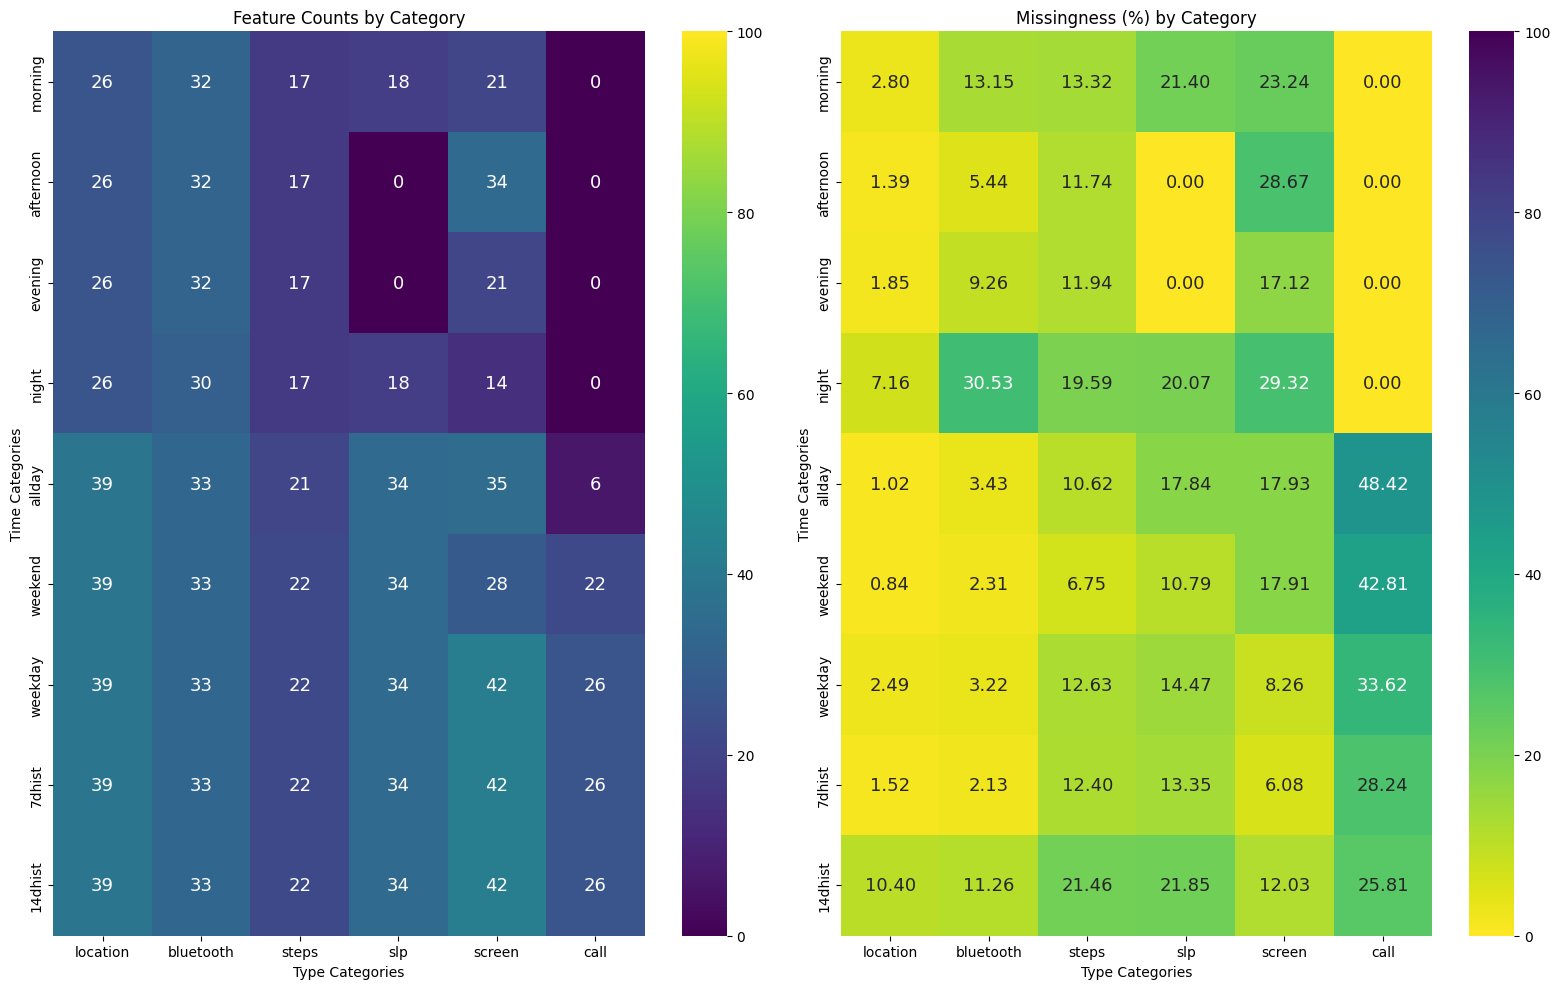

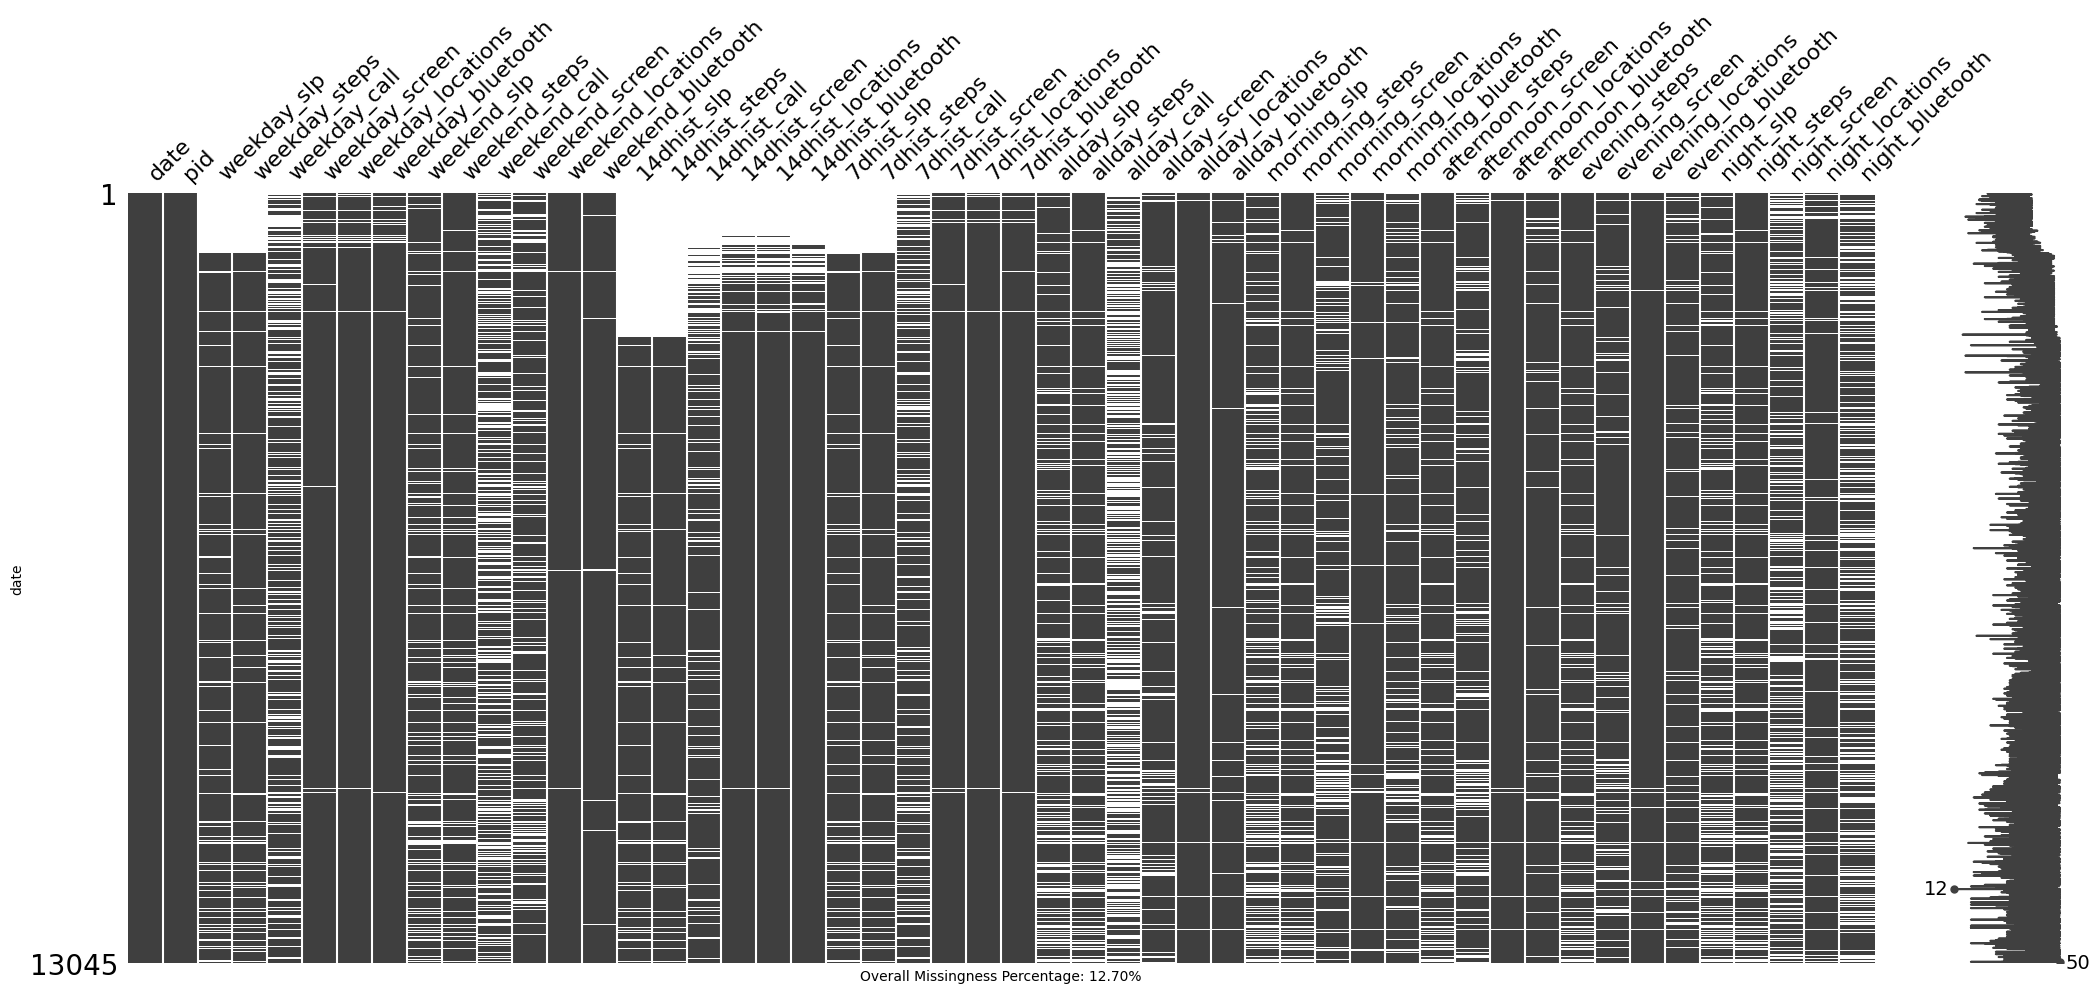


=== Starting participant-wise KNN imputation ===

Initially missing 2252640 values across 1358 features and 204 participants

=== Imputation Summary ===
Values imputed using participant KNN: 2252640
Remaining missing values: 0

=== After Removing Missing Labels ===
Total rows in dataset: 12819
Rows with missing phq4 depression: 0

=== Missing Data Analysis ===

Overall Summary:
Total participants: 204
Total missing days: 0
Total number of gaps: 0

Missing Data Statistics:
       missing_percentage  number_of_gaps  max_gap_size
count               204.0           204.0         204.0
mean                  0.0             0.0           0.0
std                   0.0             0.0           0.0
min                   0.0             0.0           0.0
25%                   0.0             0.0           0.0
50%                   0.0             0.0           0.0
75%                   0.0             0.0           0.0
max                   0.0             0.0           0.0

Participants with

In [54]:
functions =  [weekly_ff_features, select_date_range, graphs, remove_features_with_high_missingness, graphs, remove_days_with_high_missingness, remove_pids_with_high_missingness, graphs, impute_by_participant, linearly_interpolate_labels, clean_dataset, verify_data_quality]

temp_df = features.copy()
for func in functions:
    temp_df = temp_df.pipe(func)
no_adjustment = temp_df

In [55]:
model2 = train_regression_model(no_adjustment, 'phq4_depression_EMA', 50) # no adjustment, remove features instead


=== Starting Feature Selection Process ===

Initial split information:
Total participants: 204
Participants with sufficient data: 198
Initial training samples: 9621
Initial test samples: 2961

Final data split summary:
Training participants: 198
Test participants: 198
Training set shape: (9621, 1358)
Test set shape: (2961, 1358)
Training proportion: 0.76

Using 5 cross-validation splits

Starting hyperparameter tuning with time series cross-validation...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Selected features: ['f_slp:fitbit_sleep_summary_rapids_countepisodemain:14dhist', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:14dhist', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain:14dhist', 'f_slp:fitbit_sleep_intraday_rapids_mindurationawakeunifiedmain:14dhist', 'f_slp:fitbit_sleep_intraday_rapids_mediandurationasleepunifiedmain:14dhist', 'f_slp:fitbit_sleep_intraday_rapids_ratiodurationawakeunifiedwithinmain:14dhist', 'f_call:phone

In [56]:
list(model2['selected_features']['feature'])

['f_call:phone_calls_rapids_outgoing_maxduration:14dhist',
 'f_screen:phone_screen_rapids_stddurationunlock_locmap_home:afternoon',
 'f_call:phone_calls_rapids_incoming_minduration:14dhist',
 'f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:14dhist',
 'f_blue:phone_bluetooth_doryab_countscansall:14dhist',
 'f_loc:phone_locations_doryab_locationentropy:afternoon',
 'f_blue:phone_bluetooth_rapids_countscansmostuniquedevice:14dhist',
 'f_call:phone_calls_rapids_incoming_sumduration:14dhist',
 'f_screen:phone_screen_rapids_maxdurationunlock_locmap_living:14dhist',
 'f_screen:phone_screen_rapids_maxdurationunlock_locmap_study:afternoon',
 'f_slp:fitbit_sleep_intraday_rapids_mindurationawakeunifiedmain:14dhist',
 'f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_home:afternoon',
 'f_steps:fitbit_steps_intraday_rapids_mindurationactivebout:afternoon',
 'f_call:phone_calls_rapids_missed_timefirstcall:14dhist',
 'f_steps:fitbit_steps_intraday_rapids_avgdurationactivebo

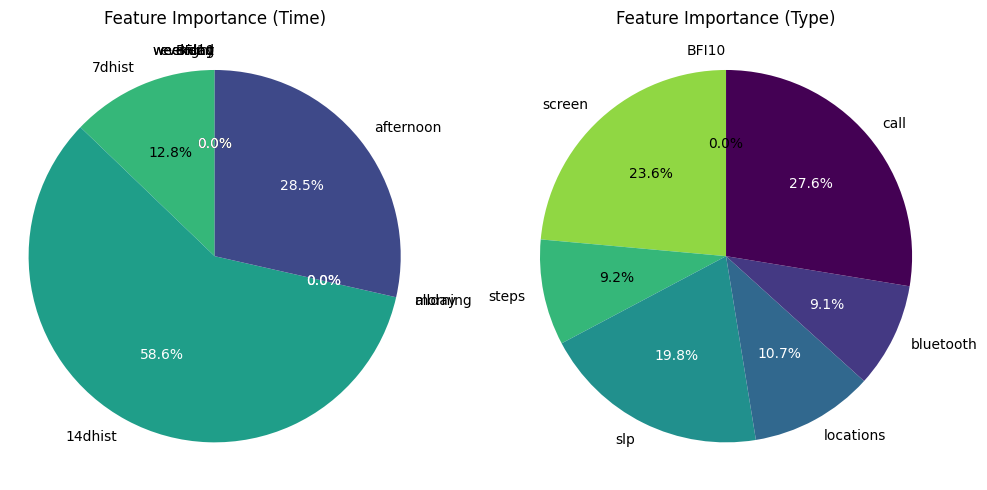

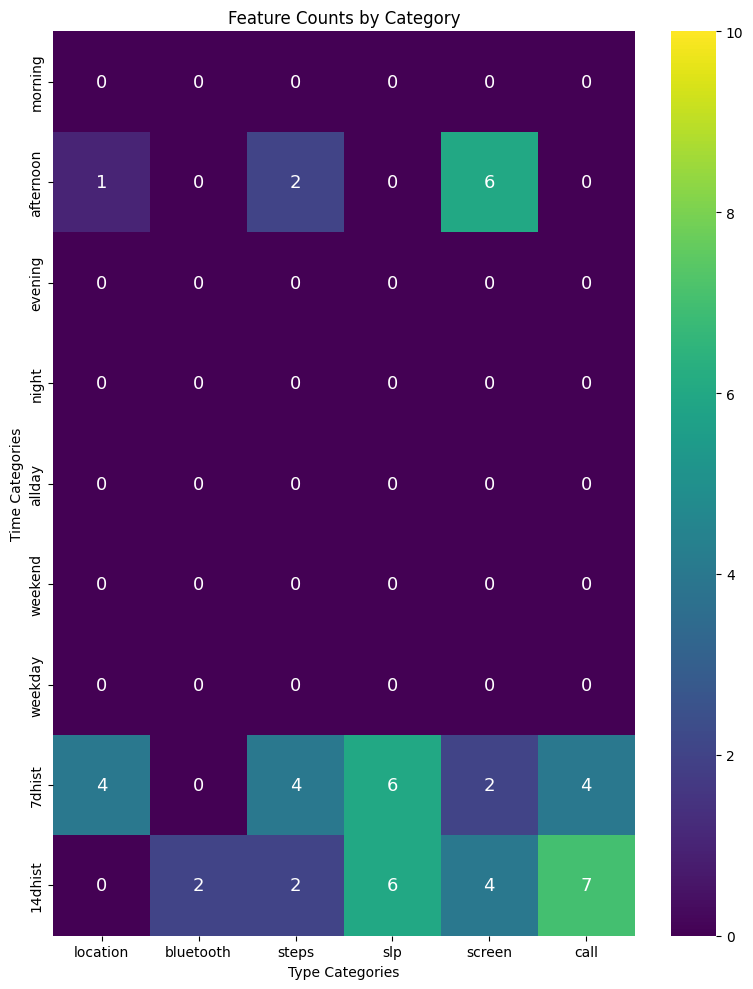

({'BFI10': 0,
  'weekday': 0,
  'weekend': 0,
  '7dhist': np.float64(0.12825903236106564),
  '14dhist': np.float64(0.586328491968081),
  'allday': 0,
  'morning': 0,
  'afternoon': np.float64(0.28541247567085337),
  'evening': 0,
  'night': 0},
 ['BFI10', 'screen', 'steps', 'slp', 'locations', 'bluetooth', 'call'])

In [57]:
categorise_feature_importance(model2['selected_features'])

### Add personality features

In [58]:
w_null_adjustment_w_personality = add_personality(w_null_adjustment)

In [59]:
model3 = train_regression_model(w_null_adjustment_w_personality, 'phq4_depression_EMA', 50) # no adjustment, remove features instead


=== Starting Feature Selection Process ===

Initial split information:
Total participants: 208
Participants with sufficient data: 202
Initial training samples: 9796
Initial test samples: 3023

Final data split summary:
Training participants: 202
Test participants: 202
Training set shape: (9796, 1632)
Test set shape: (3023, 1632)
Training proportion: 0.76

Using 5 cross-validation splits

Starting hyperparameter tuning with time series cross-validation...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Selected features: ['f_slp:fitbit_sleep_intraday_rapids_ratiocountawakeunifiedwithinmain:afternoon', 'f_slp:fitbit_sleep_intraday_rapids_ratiodurationawakeunifiedwithinmain:afternoon', 'f_call:phone_calls_rapids_outgoing_minduration:afternoon', 'f_blue:phone_bluetooth_rapids_countscansmostuniquedevice:afternoon', 'f_screen:phone_screen_rapids_sumdurationunlock_locmap_living:afternoon', 'f_screen:phone_screen_rapids_maxdurationunlock_locmap_living:afternoon', 'f_screen:phone_s

In [60]:
list(model3['selected_features']['feature'])

['f_screen:phone_screen_rapids_avgdurationunlock:morning',
 'f_screen:phone_screen_rapids_stddurationunlock:morning',
 'f_screen:phone_screen_rapids_mindurationunlock_locmap_study:allday',
 'f_call:phone_calls_rapids_incoming_entropyduration:morning',
 'f_loc:phone_locations_doryab_timeattop2location:afternoon',
 'f_call:phone_calls_rapids_outgoing_minduration:afternoon',
 'f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:morning',
 'f_screen:phone_screen_rapids_maxdurationunlock:morning',
 'f_screen:phone_screen_rapids_mindurationunlock:morning',
 'f_call:phone_calls_rapids_incoming_meanduration:evening',
 'f_slp:fitbit_sleep_intraday_rapids_stddurationasleepunifiedmain:allday',
 'f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout:evening',
 'f_slp:fitbit_sleep_intraday_rapids_avgdurationasleepunifiedmain:morning',
 'f_slp:fitbit_sleep_intraday_rapids_ratiodurationasleepunifiedwithinmain:evening',
 'f_call:phone_calls_rapids_incoming_sumduration:evening',
 'f_sc

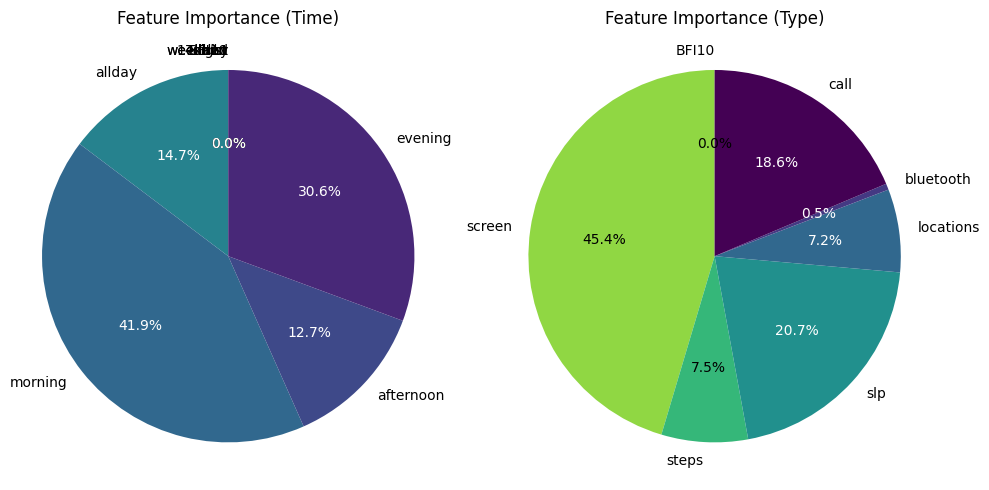

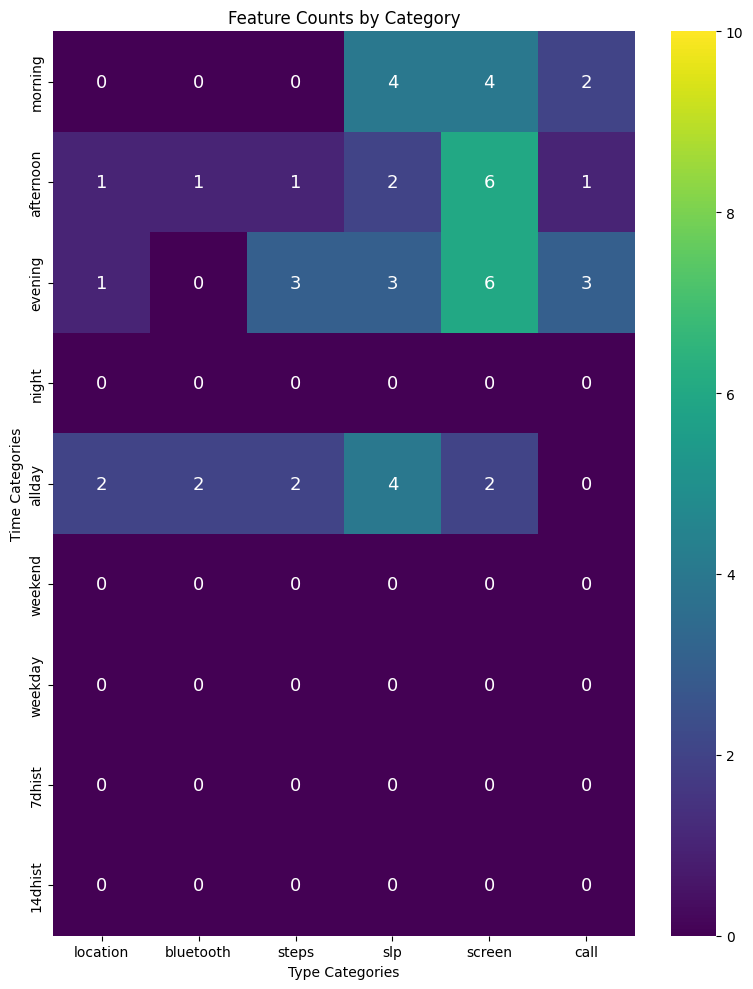

({'BFI10': 0,
  'weekday': 0,
  'weekend': 0,
  '7dhist': 0,
  '14dhist': 0,
  'allday': np.float64(0.147016472750247),
  'morning': np.float64(0.4193653781354641),
  'afternoon': np.float64(0.12722091224877952),
  'evening': np.float64(0.30639723686550935),
  'night': 0},
 ['BFI10', 'screen', 'steps', 'slp', 'locations', 'bluetooth', 'call'])

In [61]:
categorise_feature_importance(model3['selected_features'])

In [62]:
no_adjustment_w_personality = add_personality(no_adjustment)

In [63]:
model4 = train_regression_model(no_adjustment_w_personality, 'phq4_depression_EMA', 50) # no adjustment, remove features instead


=== Starting Feature Selection Process ===

Initial split information:
Total participants: 204
Participants with sufficient data: 198
Initial training samples: 9621
Initial test samples: 2961

Final data split summary:
Training participants: 198
Test participants: 198
Training set shape: (9621, 1363)
Test set shape: (2961, 1363)
Training proportion: 0.76

Using 5 cross-validation splits

Starting hyperparameter tuning with time series cross-validation...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Selected features: ['f_slp:fitbit_sleep_summary_rapids_countepisodemain:14dhist', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:14dhist', 'f_slp:fitbit_sleep_intraday_rapids_mindurationawakeunifiedmain:14dhist', 'f_slp:fitbit_sleep_intraday_rapids_mediandurationasleepunifiedmain:14dhist', 'f_slp:fitbit_sleep_intraday_rapids_ratiodurationawakeunifiedwithinmain:14dhist', 'f_call:phone_calls_rapids_missed_count:14dhist', 'f_call:phone_calls_rapids_missed_time

In [64]:
list(model4['selected_features']['feature'])

['f_loc:phone_locations_locmap_percent_in_locmap_greens:afternoon',
 'f_slp:fitbit_sleep_summary_rapids_sumdurationafterwakeupmain:allday',
 'f_call:phone_calls_rapids_outgoing_maxduration:14dhist',
 'f_loc:phone_locations_locmap_duration_in_locmap_greens:afternoon',
 'f_loc:phone_locations_locmap_percent_in_locmap_exercise:afternoon',
 'f_call:phone_calls_rapids_incoming_sumduration:14dhist',
 'f_steps:fitbit_steps_intraday_rapids_mindurationactivebout:afternoon',
 'f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:14dhist',
 'f_blue:phone_bluetooth_rapids_countscansmostuniquedevice:14dhist',
 'f_call:phone_calls_rapids_incoming_minduration:14dhist',
 'f_slp:fitbit_sleep_intraday_rapids_mindurationawakeunifiedmain:14dhist',
 'f_loc:phone_locations_doryab_locationentropy:afternoon',
 'f_call:phone_calls_rapids_missed_timefirstcall:14dhist',
 'f_screen:phone_screen_rapids_stddurationunlock_locmap_home:afternoon',
 'f_screen:phone_screen_rapids_maxdurationunlock_locmap_stu